In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/Post_PREDICT_Train_with_TRUE_85500inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=190)
(2479500, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']>8])
print(view_1hot_df.shape[0]/20)
# Take 85500 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:, :-7].values)
print(train_v.shape)
print(train_v.shape[0]/20)

Number of inds: 85500
85500.0
85500.0
(1710000, 182)
85500.0


In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [6]:
print('LL_PDC:', view_1hot_df.columns.get_loc('LL_PDC'))
#print('Unique LL_PDC:', np.unique(train_v[:, 28]))

LL_PDC: 28


In [7]:
'''
def setup_xy(time_series, scaled_time_series):
    num_of_inds = time_series.shape[0]//20
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*15), 
                   dtype='float')
    _y = np.empty((num_of_inds, 2), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*20):((i+1)*20), :])
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, 16):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
        ind_v = copy.deepcopy(time_series[(i*20):((i+1)*20), :])
        if sum(ind_v[16:20, 28])/4 >= 80:
            _y[i, 0] = 0.0
            _y[i, 1] = 1.0
        else:
            _y[i, 0] = 1.0
            _y[i, 1] = 0.0
    return _x, _y
'''

In [7]:
# update
def setup_xy(time_series, scaled_time_series, obs_steps):
    num_of_inds = time_series.shape[0]//20
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*(obs_steps-1)), 
                   dtype='float')
    _y = np.empty((num_of_inds, 2), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*20):((i+1)*20), :])
        scaled_ind_v = scaled_ind_v[(16-obs_steps):16, :]
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, (obs_steps)):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
        ind_v = copy.deepcopy(time_series[(i*20):((i+1)*20), :])
        if sum(ind_v[16:20, 28])/4 >= 80:
            _y[i, 0] = 0.0
            _y[i, 1] = 1.0
        else:
            _y[i, 0] = 1.0
            _y[i, 1] = 0.0
    return _x, _y

In [8]:
print(train_v.shape)
print(scaled_train.shape)

x_train, y_train = setup_xy(train_v, scaled_train, 8)

#x_train, y_train = set_up_xy_aggregate(scaled_train)
#x_test, y_test = set_up_xy_aggregate(scaled_test)
print("x train", x_train.shape)
print("y train", y_train.shape)

(1710000, 182)
(1710000, 182)
x train (85500, 1449)
y train (85500, 2)


In [9]:
def setup_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #2897 2173 1449, 725
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss'])

8550
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.5883 - acc: 0.7684 - val_loss: 0.4395 - val_acc: 0.8437

Epoch 00001: val_loss improved from inf to 0.43949, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4950 - acc: 0.7888 - val_loss: 0.3960 - val_acc: 0.8519

Epoch 00002: val_loss improved from 0.43949 to 0.39604, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4858 - acc: 0.7927 - val_loss: 0.3947 - val_acc: 0.8511

Epoch 00003: val_loss improved from 0.39604 to 0.39466, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4839 - acc: 0.7933 - val_loss: 0.3930 - val_acc: 0.8515

Epoch 00004: val_loss improved from 0.39466 to 0.39298, saving model to MLP_val_weights.hdf5
Epoch 5

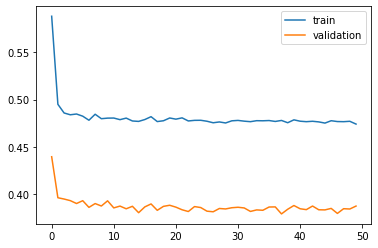

#################################
Number of units: 2
Batch size: 64
Fold: 0
best val loss: 0.3789040412819176
#################################
Time to train MLP:  157.16861605644226
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.5843 - acc: 0.7681 - val_loss: 0.4301 - val_acc: 0.8487

Epoch 00001: val_loss improved from inf to 0.43010, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.5003 - acc: 0.7854 - val_loss: 0.3927 - val_acc: 0.8539

Epoch 00002: val_loss improved from 0.43010 to 0.39269, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4880 - acc: 0.7910 - val_loss: 0.3893 - val_acc: 0.8531

Epoch 00003: val_loss improved from 0.39269 to 0.38925, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4829 - acc: 0.7936 - val_loss: 0.3847 - val_acc: 0.8575

Epoch 00004: val_loss improved from 0.38925 to 0.38472, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.4863 - acc: 0.7916 - val_loss: 0.3855

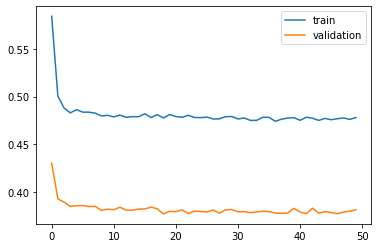

#################################
Number of units: 2
Batch size: 64
Fold: 1
best val loss: 0.37687108649845014
#################################
Time to train MLP:  157.20334768295288
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.5976 - acc: 0.7658 - val_loss: 0.4417 - val_acc: 0.8388

Epoch 00001: val_loss improved from inf to 0.44165, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4953 - acc: 0.7890 - val_loss: 0.4009 - val_acc: 0.8494

Epoch 00002: val_loss improved from 0.44165 to 0.40087, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4870 - acc: 0.7915 - val_loss: 0.3972 - val_acc: 0.8513

Epoch 00003: val_loss improved from 0.40087 to 0.39724, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4841 - acc: 0.7938 - val_loss: 0.3966 - val_acc: 0.8497

Epoch 00004: val_loss improved from 0.39724 to 0.39656, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.4832 - acc: 0.7938 - val_loss: 0.392

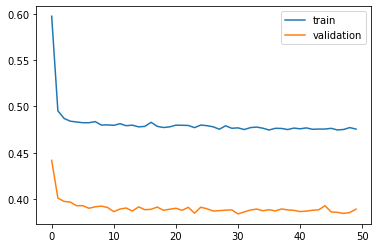

#################################
Number of units: 2
Batch size: 64
Fold: 2
best val loss: 0.38371927933386196
#################################
Time to train MLP:  158.53695511817932
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.5935 - acc: 0.7662 - val_loss: 0.4286 - val_acc: 0.8451

Epoch 00001: val_loss improved from inf to 0.42856, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4956 - acc: 0.7887 - val_loss: 0.3950 - val_acc: 0.8553

Epoch 00002: val_loss improved from 0.42856 to 0.39496, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4894 - acc: 0.7900 - val_loss: 0.3927 - val_acc: 0.8585

Epoch 00003: val_loss improved from 0.39496 to 0.39274, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4830 - acc: 0.7947 - val_loss: 0.3870 - val_acc: 0.8602

Epoch 00004: val_loss improved from 0.39274 to 0.38697, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.4845 - acc: 0.7937 - val_loss: 0.389

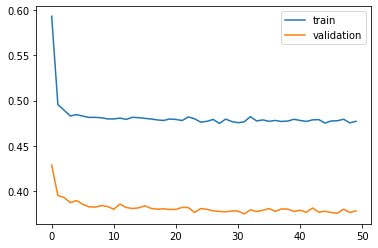

#################################
Number of units: 2
Batch size: 64
Fold: 3
best val loss: 0.3745232618203637
#################################
Time to train MLP:  159.24659824371338
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.5889 - acc: 0.7682 - val_loss: 0.4418 - val_acc: 0.8386

Epoch 00001: val_loss improved from inf to 0.44181, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4975 - acc: 0.7883 - val_loss: 0.3986 - val_acc: 0.8491

Epoch 00002: val_loss improved from 0.44181 to 0.39856, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4863 - acc: 0.7927 - val_loss: 0.3913 - val_acc: 0.8516

Epoch 00003: val_loss improved from 0.39856 to 0.39132, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4849 - acc: 0.7935 - val_loss: 0.3912 - val_acc: 0.8523

Epoch 00004: val_loss improved from 0.39132 to 0.39118, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.4826 - acc: 0.7948 - val_loss: 0.3894

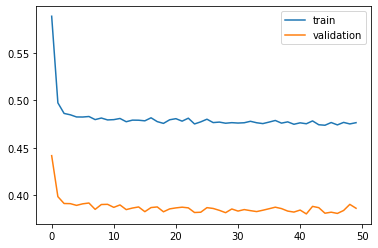

#################################
Number of units: 2
Batch size: 64
Fold: 4
best val loss: 0.38033992089723284
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284]]
Time to train MLP:  160.389639377594
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.6075 - acc: 0.7654 - val_loss: 0.4657 - val_acc: 0.8434

Epoch 00001: val_loss improved from inf to 0.46568, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.5079 - acc: 0.7884 - val_loss: 0.4104 - val_acc: 0.8498

Epoch 00002: val_loss improved from 0.46568 to 0.41037, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4906 - acc: 0.7905 - val_loss: 0.3976 - val_acc: 0.8505

Epoch 00003: val_loss improved from 0.41037 to 0.39762, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4847 - acc: 0.7927 - val_loss: 0.3940 - val_acc: 0.

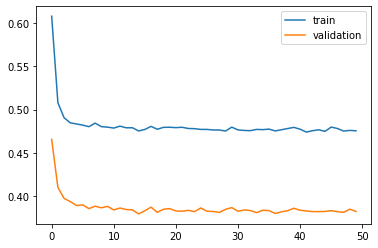

#################################
Number of units: 2
Batch size: 128
Fold: 0
best val loss: 0.37976353998072665
#################################
Time to train MLP:  93.85564661026001
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.6076 - acc: 0.7623 - val_loss: 0.4690 - val_acc: 0.8473

Epoch 00001: val_loss improved from inf to 0.46895, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.5112 - acc: 0.7867 - val_loss: 0.4092 - val_acc: 0.8488

Epoch 00002: val_loss improved from 0.46895 to 0.40916, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4910 - acc: 0.7902 - val_loss: 0.3931 - val_acc: 0.8532

Epoch 00003: val_loss improved from 0.40916 to 0.39311, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4829 - acc: 0.7946 - val_loss: 0.3885 - val_acc: 0.8529

Epoch 00004: val_loss improved from 0.39311 to 0.38853, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.4872 - acc: 0.7910 - val_loss: 0.386

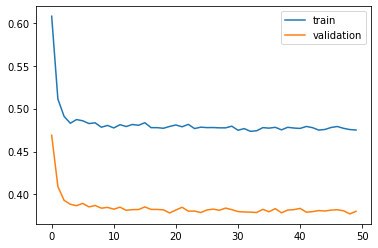

#################################
Number of units: 2
Batch size: 128
Fold: 1
best val loss: 0.3773087516305042
#################################
Time to train MLP:  94.11703038215637
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.6072 - acc: 0.7642 - val_loss: 0.4722 - val_acc: 0.8441

Epoch 00001: val_loss improved from inf to 0.47218, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.5108 - acc: 0.7860 - val_loss: 0.4198 - val_acc: 0.8449

Epoch 00002: val_loss improved from 0.47218 to 0.41975, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4887 - acc: 0.7909 - val_loss: 0.3990 - val_acc: 0.8485

Epoch 00003: val_loss improved from 0.41975 to 0.39904, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4834 - acc: 0.7934 - val_loss: 0.3973 - val_acc: 0.8483

Epoch 00004: val_loss improved from 0.39904 to 0.39735, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.4816 - acc: 0.7944 - val_loss: 0.3911

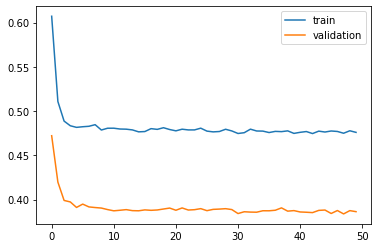

#################################
Number of units: 2
Batch size: 128
Fold: 2
best val loss: 0.38381051242002967
#################################
Time to train MLP:  95.0446949005127
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.6156 - acc: 0.7618 - val_loss: 0.4738 - val_acc: 0.8447

Epoch 00001: val_loss improved from inf to 0.47379, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.5139 - acc: 0.7871 - val_loss: 0.4092 - val_acc: 0.8517

Epoch 00002: val_loss improved from 0.47379 to 0.40923, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4932 - acc: 0.7893 - val_loss: 0.3945 - val_acc: 0.8546

Epoch 00003: val_loss improved from 0.40923 to 0.39455, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4864 - acc: 0.7920 - val_loss: 0.3907 - val_acc: 0.8564

Epoch 00004: val_loss improved from 0.39455 to 0.39074, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.4858 - acc: 0.7923 - val_loss: 0.3900

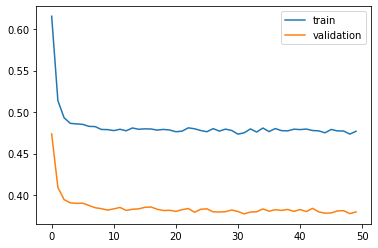

#################################
Number of units: 2
Batch size: 128
Fold: 3
best val loss: 0.37732015612529735
#################################
Time to train MLP:  96.1644651889801
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.6078 - acc: 0.7646 - val_loss: 0.4741 - val_acc: 0.8378

Epoch 00001: val_loss improved from inf to 0.47413, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.5085 - acc: 0.7876 - val_loss: 0.4141 - val_acc: 0.8442

Epoch 00002: val_loss improved from 0.47413 to 0.41410, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4893 - acc: 0.7920 - val_loss: 0.3964 - val_acc: 0.8489

Epoch 00003: val_loss improved from 0.41410 to 0.39639, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4863 - acc: 0.7925 - val_loss: 0.3951 - val_acc: 0.8496

Epoch 00004: val_loss improved from 0.39639 to 0.39510, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.4829 - acc: 0.7943 - val_loss: 0.3917

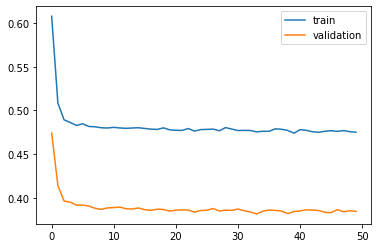

#################################
Number of units: 2
Batch size: 128
Fold: 4
best val loss: 0.38165430828841806
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806]]
Time to train MLP:  95.84460210800171
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.6331 - acc: 0.7550 - val_loss: 0.5153 - val_acc: 0.8461

Epoch 00001: val_loss improved from inf to 0.51526, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5389 - acc: 0.7855 - val_loss: 0.4607 - val_acc: 0.8491

Epoch 00002: val_loss improved from 0.51526 to 0.46068, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5067 - acc: 0.7897 - val_loss: 0.4228 - val_acc: 0.8523



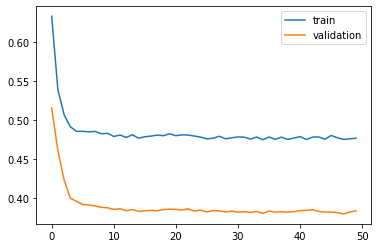

#################################
Number of units: 2
Batch size: 256
Fold: 0
best val loss: 0.37918320519882337
#################################
Time to train MLP:  66.35049247741699


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f92f055cdd8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f92f0427828>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.6361 - acc: 0.7511 - val_loss: 0.5184 - val_acc: 0.8458

Epoch 00001: val_loss improved from inf to 0.51841, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5344 - acc: 0.7851 - val_loss: 0.4461 - val_acc: 0.8485

Epoch 00002: val_loss improved from 0.51841 to 0.44606, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5114 - acc: 0.7877 - val_loss: 0.4171 - val_acc: 0.8497

Epoch 00003: val_loss improved from 0.44606 to 0.41710, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4921 - acc: 0.7928 - val_loss: 0.3953 - val_acc: 0.8539

Epoch 00004: val_loss improved from 0.41710 to 0.39530, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4898 - acc: 0.7895 - val_loss: 0.3924 - val_acc: 0.8538

Epoch 00005: val_loss improved from 0.39530 to 0.39245, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 1s - loss: 0.4865 - acc: 0.7921 - val_loss: 0.3916 - val

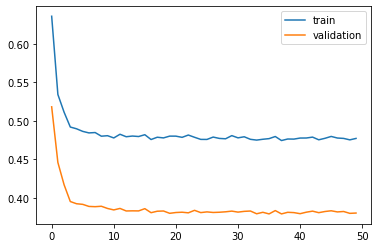

#################################
Number of units: 2
Batch size: 256
Fold: 1
best val loss: 0.3792138594284392
#################################
Time to train MLP:  66.45773148536682
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.6373 - acc: 0.7519 - val_loss: 0.5189 - val_acc: 0.8421

Epoch 00001: val_loss improved from inf to 0.51886, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5335 - acc: 0.7858 - val_loss: 0.4621 - val_acc: 0.8482

Epoch 00002: val_loss improved from 0.51886 to 0.46214, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5102 - acc: 0.7864 - val_loss: 0.4237 - val_acc: 0.8467

Epoch 00003: val_loss improved from 0.46214 to 0.42368, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4892 - acc: 0.7919 - val_loss: 0.4109 - val_acc: 0.8460

Epoch 00004: val_loss improved from 0.42368 to 0.41085, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4841 - acc: 0.7940 - val_loss: 0.3983

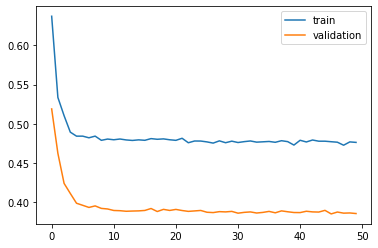

#################################
Number of units: 2
Batch size: 256
Fold: 2
best val loss: 0.38468724450172737
#################################
Time to train MLP:  63.748186111450195
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.6378 - acc: 0.7532 - val_loss: 0.5173 - val_acc: 0.8458

Epoch 00001: val_loss improved from inf to 0.51734, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5376 - acc: 0.7848 - val_loss: 0.4489 - val_acc: 0.8494

Epoch 00002: val_loss improved from 0.51734 to 0.44887, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5050 - acc: 0.7895 - val_loss: 0.4132 - val_acc: 0.8538

Epoch 00003: val_loss improved from 0.44887 to 0.41320, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4895 - acc: 0.7923 - val_loss: 0.4005 - val_acc: 0.8547

Epoch 00004: val_loss improved from 0.41320 to 0.40050, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4862 - acc: 0.7920 - val_loss: 0.39

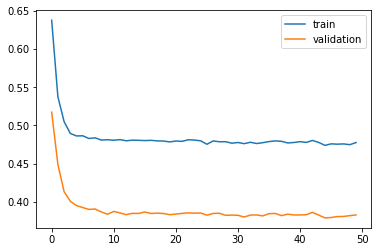

#################################
Number of units: 2
Batch size: 256
Fold: 3
best val loss: 0.3787614169525124
#################################
Time to train MLP:  67.14412379264832
Train on 76950 samples, validate on 8550 samples
Epoch 1/50


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f9230174d68>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f9230174e80>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

 - 4s - loss: 0.6386 - acc: 0.7532 - val_loss: 0.5207 - val_acc: 0.8422

Epoch 00001: val_loss improved from inf to 0.52071, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5344 - acc: 0.7871 - val_loss: 0.4562 - val_acc: 0.8443

Epoch 00002: val_loss improved from 0.52071 to 0.45616, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5063 - acc: 0.7880 - val_loss: 0.4208 - val_acc: 0.8458

Epoch 00003: val_loss improved from 0.45616 to 0.42084, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4919 - acc: 0.7914 - val_loss: 0.4031 - val_acc: 0.8463

Epoch 00004: val_loss improved from 0.42084 to 0.40311, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4859 - acc: 0.7929 - val_loss: 0.3982 - val_acc: 0.8481

Epoch 00005: val_loss improved from 0.40311 to 0.39821, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 1s - loss: 0.4849 - acc: 0.7929 - val_loss: 0.3975 - val_acc: 0.8477

Epoch 00006: val_loss improved from 0.39821 to

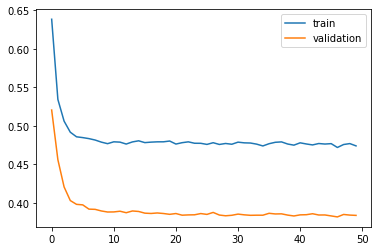

#################################
Number of units: 2
Batch size: 256
Fold: 4
best val loss: 0.3818769124237417
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417]]
Time to train MLP:  65.87344527244568
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.6584 - acc: 0.7382 - val_loss: 0.5502 - val_acc: 0.8474

Epoch 00001: val_loss improved from inf to 0.55015, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5679 - acc: 0.7850 - val_loss: 0.4971 - val_acc: 0.8537

Epoch 00002

 - 1s - loss: 0.4770 - acc: 0.7976 - val_loss: 0.3833 - val_acc: 0.8564

Epoch 00050: val_loss did not improve from 0.38082


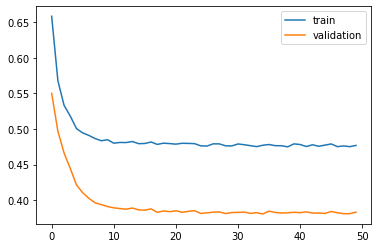

#################################
Number of units: 2
Batch size: 512
Fold: 0
best val loss: 0.38081676958597194
#################################
Time to train MLP:  46.374048471450806
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.6635 - acc: 0.7338 - val_loss: 0.5627 - val_acc: 0.8416

Epoch 00001: val_loss improved from inf to 0.56271, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5672 - acc: 0.7842 - val_loss: 0.5038 - val_acc: 0.8517

Epoch 00002: val_loss improved from 0.56271 to 0.50383, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5341 - acc: 0.7870 - val_loss: 0.4669 - val_acc: 0.8530

Epoch 00003: val_loss improved from 0.50383 to 0.46691, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5115 - acc: 0.7912 - val_loss: 0.4307 - val_acc: 0.8553

Epoch 00004: val_loss improved from 0.46691 to 0.43066, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.5021 - acc: 0.7894 - val_loss: 0.41

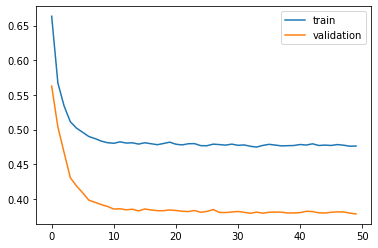

#################################
Number of units: 2
Batch size: 512
Fold: 1
best val loss: 0.3784373574159299
#################################
Time to train MLP:  46.75399446487427
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.6645 - acc: 0.7330 - val_loss: 0.5577 - val_acc: 0.8419

Epoch 00001: val_loss improved from inf to 0.55768, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5654 - acc: 0.7841 - val_loss: 0.4998 - val_acc: 0.8478

Epoch 00002: val_loss improved from 0.55768 to 0.49978, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5300 - acc: 0.7885 - val_loss: 0.4662 - val_acc: 0.8484

Epoch 00003: val_loss improved from 0.49978 to 0.46619, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5081 - acc: 0.7918 - val_loss: 0.4417 - val_acc: 0.8483

Epoch 00004: val_loss improved from 0.46619 to 0.44170, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4988 - acc: 0.7915 - val_loss: 0.4262

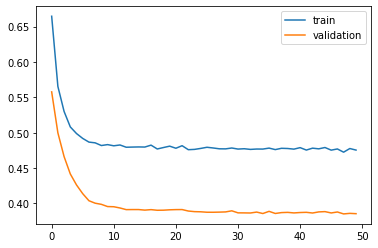

#################################
Number of units: 2
Batch size: 512
Fold: 2
best val loss: 0.3852234473284225
#################################
Time to train MLP:  49.61528134346008
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.6654 - acc: 0.7345 - val_loss: 0.5588 - val_acc: 0.8428

Epoch 00001: val_loss improved from inf to 0.55881, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5700 - acc: 0.7847 - val_loss: 0.5022 - val_acc: 0.8502

Epoch 00002: val_loss improved from 0.55881 to 0.50218, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5357 - acc: 0.7885 - val_loss: 0.4653 - val_acc: 0.8524

Epoch 00003: val_loss improved from 0.50218 to 0.46532, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5157 - acc: 0.7904 - val_loss: 0.4411 - val_acc: 0.8538

Epoch 00004: val_loss improved from 0.46532 to 0.44112, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.5019 - acc: 0.7910 - val_loss: 0.4213

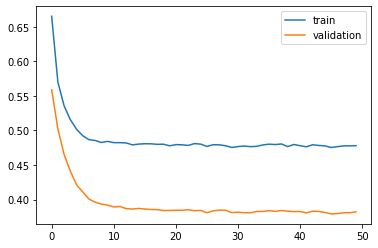

#################################
Number of units: 2
Batch size: 512
Fold: 3
best val loss: 0.37912433074928864
#################################
Time to train MLP:  48.000205755233765
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 7s - loss: 0.6651 - acc: 0.7338 - val_loss: 0.5587 - val_acc: 0.8401

Epoch 00001: val_loss improved from inf to 0.55869, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5616 - acc: 0.7854 - val_loss: 0.5037 - val_acc: 0.8457

Epoch 00002: val_loss improved from 0.55869 to 0.50374, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5323 - acc: 0.7873 - val_loss: 0.4680 - val_acc: 0.8481

Epoch 00003: val_loss improved from 0.50374 to 0.46797, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5138 - acc: 0.7903 - val_loss: 0.4437 - val_acc: 0.8473

Epoch 00004: val_loss improved from 0.46797 to 0.44372, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4995 - acc: 0.7914 - val_loss: 0.42

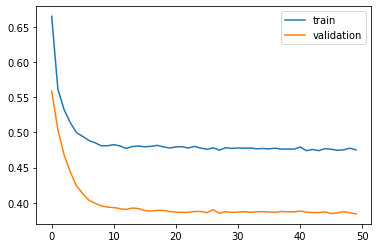

#################################
Number of units: 2
Batch size: 512
Fold: 4
best val loss: 0.3840542383221855
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855]]
Time to train MLP:  50.74100589752197
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.6979 - acc: 0.7057 - val_loss: 0.5820 - val_acc: 0.8345

Epoch 00001: val_

 - 1s - loss: 0.4812 - acc: 0.7955 - val_loss: 0.3829 - val_acc: 0.8573

Epoch 00046: val_loss did not improve from 0.38123
Epoch 47/50
 - 1s - loss: 0.4767 - acc: 0.7980 - val_loss: 0.3832 - val_acc: 0.8564

Epoch 00047: val_loss did not improve from 0.38123
Epoch 48/50
 - 1s - loss: 0.4780 - acc: 0.7977 - val_loss: 0.3837 - val_acc: 0.8559

Epoch 00048: val_loss did not improve from 0.38123
Epoch 49/50
 - 1s - loss: 0.4732 - acc: 0.8002 - val_loss: 0.3805 - val_acc: 0.8586

Epoch 00049: val_loss improved from 0.38123 to 0.38045, saving model to MLP_val_weights.hdf5
Epoch 50/50
 - 1s - loss: 0.4781 - acc: 0.7987 - val_loss: 0.3833 - val_acc: 0.8557

Epoch 00050: val_loss did not improve from 0.38045


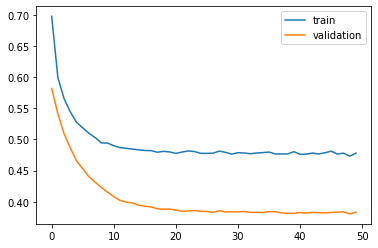

#################################
Number of units: 2
Batch size: 1024
Fold: 0
best val loss: 0.38045362697010154
#################################
Time to train MLP:  37.38894081115723
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.6985 - acc: 0.7055 - val_loss: 0.5849 - val_acc: 0.8290

Epoch 00001: val_loss improved from inf to 0.58493, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5962 - acc: 0.7764 - val_loss: 0.5384 - val_acc: 0.8523

Epoch 00002: val_loss improved from 0.58493 to 0.53842, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5653 - acc: 0.7844 - val_loss: 0.5044 - val_acc: 0.8560

Epoch 00003: val_loss improved from 0.53842 to 0.50440, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5434 - acc: 0.7887 - val_loss: 0.4823 - val_acc: 0.8571

Epoch 00004: val_loss improved from 0.50440 to 0.48232, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.5270 - acc: 0.7910 - val_loss: 0.46

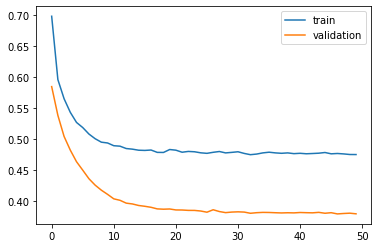

#################################
Number of units: 2
Batch size: 1024
Fold: 1
best val loss: 0.379316124762708
#################################
Time to train MLP:  36.63929104804993
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.6980 - acc: 0.7052 - val_loss: 0.5851 - val_acc: 0.8249

Epoch 00001: val_loss improved from inf to 0.58513, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5953 - acc: 0.7765 - val_loss: 0.5439 - val_acc: 0.8449

Epoch 00002: val_loss improved from 0.58513 to 0.54394, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5656 - acc: 0.7843 - val_loss: 0.5160 - val_acc: 0.8475

Epoch 00003: val_loss improved from 0.54394 to 0.51603, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5404 - acc: 0.7903 - val_loss: 0.4903 - val_acc: 0.8488

Epoch 00004: val_loss improved from 0.51603 to 0.49027, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.5267 - acc: 0.7910 - val_loss: 0.4738

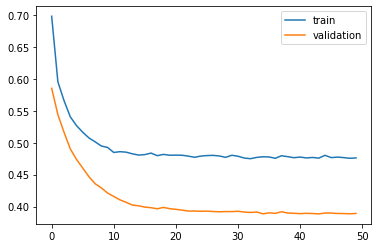

#################################
Number of units: 2
Batch size: 1024
Fold: 2
best val loss: 0.38844973953146683
#################################
Time to train MLP:  36.391724586486816
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 8s - loss: 0.7019 - acc: 0.7064 - val_loss: 0.5888 - val_acc: 0.8287

Epoch 00001: val_loss improved from inf to 0.58884, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5976 - acc: 0.7766 - val_loss: 0.5430 - val_acc: 0.8475

Epoch 00002: val_loss improved from 0.58884 to 0.54296, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5665 - acc: 0.7838 - val_loss: 0.5098 - val_acc: 0.8509

Epoch 00003: val_loss improved from 0.54296 to 0.50981, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5415 - acc: 0.7898 - val_loss: 0.4848 - val_acc: 0.8544

Epoch 00004: val_loss improved from 0.50981 to 0.48477, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.5286 - acc: 0.7901 - val_loss: 0.4

 - 1s - loss: 0.4764 - acc: 0.7983 - val_loss: 0.3811 - val_acc: 0.8620

Epoch 00050: val_loss did not improve from 0.38061


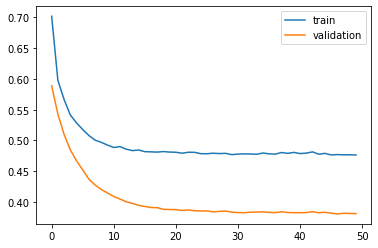

#################################
Number of units: 2
Batch size: 1024
Fold: 3
best val loss: 0.38060520439817197
#################################
Time to train MLP:  40.132954120635986
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.6993 - acc: 0.7042 - val_loss: 0.5922 - val_acc: 0.8258

Epoch 00001: val_loss improved from inf to 0.59220, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5955 - acc: 0.7774 - val_loss: 0.5491 - val_acc: 0.8426

Epoch 00002: val_loss improved from 0.59220 to 0.54910, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5667 - acc: 0.7853 - val_loss: 0.5172 - val_acc: 0.8489

Epoch 00003: val_loss improved from 0.54910 to 0.51716, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5467 - acc: 0.7888 - val_loss: 0.4939 - val_acc: 0.8461

Epoch 00004: val_loss improved from 0.51716 to 0.49386, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.5297 - acc: 0.7902 - val_loss: 0.4


Epoch 00050: val_loss did not improve from 0.38483


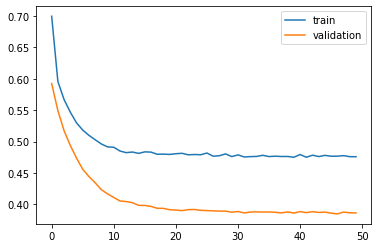

#################################
Number of units: 2
Batch size: 1024
Fold: 4
best val loss: 0.38482770297959534
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534]]
Time to train


Epoch 00050: val_loss did not improve from 0.33892


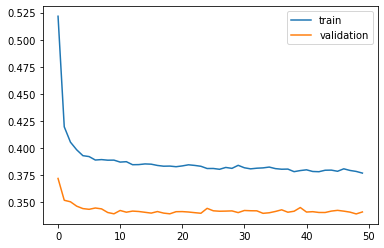

#################################
Number of units: 4
Batch size: 64
Fold: 0
best val loss: 0.33891734394413686
#################################
Time to train MLP:  186.53502249717712
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.5268 - acc: 0.7914 - val_loss: 0.3729 - val_acc: 0.8552

Epoch 00001: val_loss improved from inf to 0.37293, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.4194 - acc: 0.8320 - val_loss: 0.3475 - val_acc: 0.8647

Epoch 00002: val_loss improved from 0.37293 to 0.34753, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.4050 - acc: 0.8382 - val_loss: 0.3414 - val_acc: 0.8643

Epoch 00003: val_loss improved from 0.34753 to 0.34135, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3970 - acc: 0.8427 - val_loss: 0.3405 - val_acc: 0.8660

Epoch 00004: val_loss improved from 0.34135 to 0.34045, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3970 - acc: 0.8415 - val_loss: 0.337

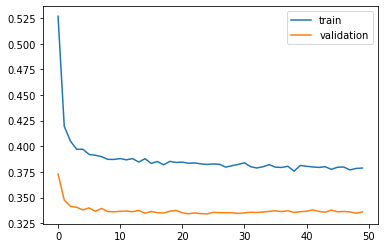

#################################
Number of units: 4
Batch size: 64
Fold: 1
best val loss: 0.33399041097066556
#################################
Time to train MLP:  185.17794275283813
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 12s - loss: 0.5297 - acc: 0.7973 - val_loss: 0.4085 - val_acc: 0.8481

Epoch 00001: val_loss improved from inf to 0.40852, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.4185 - acc: 0.8383 - val_loss: 0.3770 - val_acc: 0.8527

Epoch 00002: val_loss improved from 0.40852 to 0.37700, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.4024 - acc: 0.8442 - val_loss: 0.3704 - val_acc: 0.8572

Epoch 00003: val_loss improved from 0.37700 to 0.37036, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3939 - acc: 0.8469 - val_loss: 0.3670 - val_acc: 0.8580

Epoch 00004: val_loss improved from 0.37036 to 0.36697, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3912 - acc: 0.8475 - val_loss: 0.36

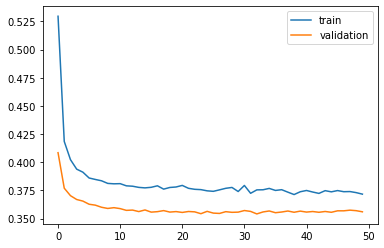

#################################
Number of units: 4
Batch size: 64
Fold: 2
best val loss: 0.3541750359116939
#################################
Time to train MLP:  189.39614486694336
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.5234 - acc: 0.7947 - val_loss: 0.3735 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.37354, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.4173 - acc: 0.8322 - val_loss: 0.3535 - val_acc: 0.8625

Epoch 00002: val_loss improved from 0.37354 to 0.35348, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.4017 - acc: 0.8383 - val_loss: 0.3505 - val_acc: 0.8634

Epoch 00003: val_loss improved from 0.35348 to 0.35046, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3966 - acc: 0.8406 - val_loss: 0.3471 - val_acc: 0.8640

Epoch 00004: val_loss improved from 0.35046 to 0.34707, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3972 - acc: 0.8413 - val_loss: 0.3462

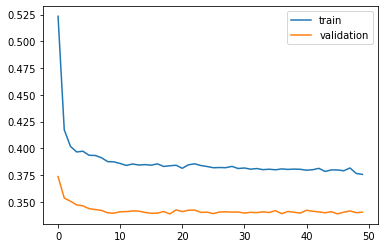

#################################
Number of units: 4
Batch size: 64
Fold: 3
best val loss: 0.33862062837645324
#################################
Time to train MLP:  186.7291762828827
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.5333 - acc: 0.7901 - val_loss: 0.3817 - val_acc: 0.8497

Epoch 00001: val_loss improved from inf to 0.38166, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.4184 - acc: 0.8327 - val_loss: 0.3599 - val_acc: 0.8559

Epoch 00002: val_loss improved from 0.38166 to 0.35985, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.4047 - acc: 0.8378 - val_loss: 0.3527 - val_acc: 0.8578

Epoch 00003: val_loss improved from 0.35985 to 0.35271, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3969 - acc: 0.8420 - val_loss: 0.3500 - val_acc: 0.8599

Epoch 00004: val_loss improved from 0.35271 to 0.34998, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3939 - acc: 0.8433 - val_loss: 0.349

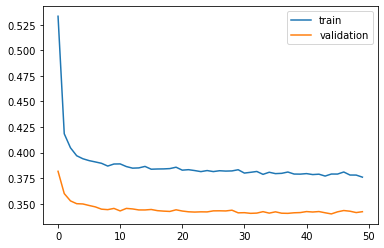

#################################
Number of units: 4
Batch size: 64
Fold: 4
best val loss: 0.33997286873951293
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.33


Epoch 00047: val_loss did not improve from 0.35160
Epoch 48/50
 - 2s - loss: 0.3735 - acc: 0.8551 - val_loss: 0.3512 - val_acc: 0.8619

Epoch 00048: val_loss improved from 0.35160 to 0.35118, saving model to MLP_val_weights.hdf5
Epoch 49/50
 - 2s - loss: 0.3735 - acc: 0.8556 - val_loss: 0.3513 - val_acc: 0.8627

Epoch 00049: val_loss did not improve from 0.35118
Epoch 50/50
 - 2s - loss: 0.3754 - acc: 0.8548 - val_loss: 0.3529 - val_acc: 0.8621

Epoch 00050: val_loss did not improve from 0.35118


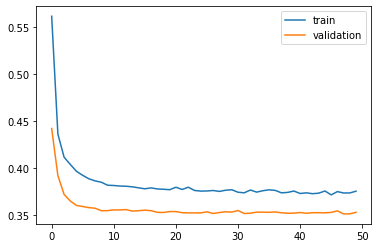

#################################
Number of units: 4
Batch size: 128
Fold: 0
best val loss: 0.3511824462915722
#################################
Time to train MLP:  115.53410315513611
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 19s - loss: 0.5660 - acc: 0.7861 - val_loss: 0.4365 - val_acc: 0.8532

Epoch 00001: val_loss improved from inf to 0.43648, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4394 - acc: 0.8361 - val_loss: 0.3826 - val_acc: 0.8570

Epoch 00002: val_loss improved from 0.43648 to 0.38261, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4123 - acc: 0.8406 - val_loss: 0.3658 - val_acc: 0.8582

Epoch 00003: val_loss improved from 0.38261 to 0.36578, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4001 - acc: 0.8450 - val_loss: 0.3608 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.36578 to 0.36080, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3965 - acc: 0.8453 - val_loss: 0.35

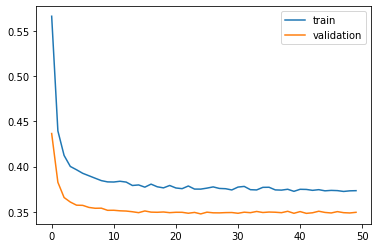

#################################
Number of units: 4
Batch size: 128
Fold: 1
best val loss: 0.34768506629425183
#################################
Time to train MLP:  126.48434591293335


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f9218c10f60>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f9218b31e10>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 12s - loss: 0.5650 - acc: 0.7883 - val_loss: 0.4475 - val_acc: 0.8490

Epoch 00001: val_loss improved from inf to 0.44748, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4345 - acc: 0.8389 - val_loss: 0.3938 - val_acc: 0.8533

Epoch 00002: val_loss improved from 0.44748 to 0.39381, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4097 - acc: 0.8426 - val_loss: 0.3774 - val_acc: 0.8542

Epoch 00003: val_loss improved from 0.39381 to 0.37744, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3999 - acc: 0.8451 - val_loss: 0.3712 - val_acc: 0.8584

Epoch 00004: val_loss improved from 0.37744 to 0.37117, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3937 - acc: 0.8467 - val_loss: 0.3686 - val_acc: 0.8579

Epoch 00005: val_loss improved from 0.37117 to 0.36859, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 2s - loss: 0.3909 - acc: 0.8482 - val_loss: 0.3642 - va

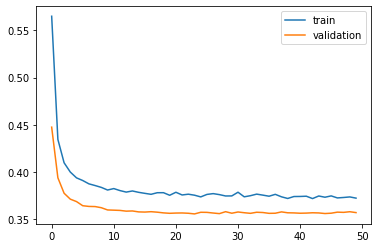

#################################
Number of units: 4
Batch size: 128
Fold: 2
best val loss: 0.3555216680353845
#################################
Time to train MLP:  119.23008489608765
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.5689 - acc: 0.7847 - val_loss: 0.4360 - val_acc: 0.8508

Epoch 00001: val_loss improved from inf to 0.43598, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4455 - acc: 0.8274 - val_loss: 0.3743 - val_acc: 0.8556

Epoch 00002: val_loss improved from 0.43598 to 0.37433, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4147 - acc: 0.8346 - val_loss: 0.3598 - val_acc: 0.8630

Epoch 00003: val_loss improved from 0.37433 to 0.35981, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4046 - acc: 0.8389 - val_loss: 0.3554 - val_acc: 0.8642

Epoch 00004: val_loss improved from 0.35981 to 0.35543, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.4001 - acc: 0.8414 - val_loss: 0.34

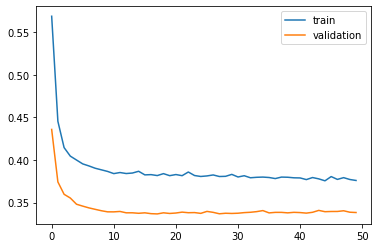

#################################
Number of units: 4
Batch size: 128
Fold: 3
best val loss: 0.33676380805801925
#################################
Time to train MLP:  117.27957844734192
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.5730 - acc: 0.7799 - val_loss: 0.4301 - val_acc: 0.8468

Epoch 00001: val_loss improved from inf to 0.43010, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4359 - acc: 0.8288 - val_loss: 0.3699 - val_acc: 0.8560

Epoch 00002: val_loss improved from 0.43010 to 0.36992, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4144 - acc: 0.8366 - val_loss: 0.3572 - val_acc: 0.8574

Epoch 00003: val_loss improved from 0.36992 to 0.35723, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4050 - acc: 0.8385 - val_loss: 0.3548 - val_acc: 0.8600

Epoch 00004: val_loss improved from 0.35723 to 0.35483, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3961 - acc: 0.8423 - val_loss: 0.35

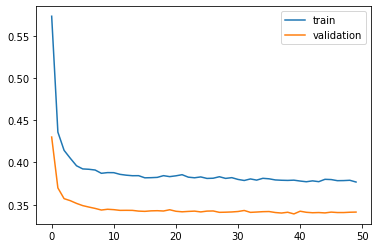

#################################
Number of units: 4
Batch size: 128
Fold: 4
best val loss: 0.3391746582204138
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.33

 - 1s - loss: 0.3739 - acc: 0.8553 - val_loss: 0.3537 - val_acc: 0.8616

Epoch 00045: val_loss did not improve from 0.35182
Epoch 46/50
 - 1s - loss: 0.3732 - acc: 0.8552 - val_loss: 0.3543 - val_acc: 0.8626

Epoch 00046: val_loss did not improve from 0.35182
Epoch 47/50
 - 1s - loss: 0.3730 - acc: 0.8551 - val_loss: 0.3555 - val_acc: 0.8637

Epoch 00047: val_loss did not improve from 0.35182
Epoch 48/50
 - 1s - loss: 0.3717 - acc: 0.8568 - val_loss: 0.3535 - val_acc: 0.8622

Epoch 00048: val_loss did not improve from 0.35182
Epoch 49/50
 - 1s - loss: 0.3730 - acc: 0.8559 - val_loss: 0.3538 - val_acc: 0.8622

Epoch 00049: val_loss did not improve from 0.35182
Epoch 50/50
 - 1s - loss: 0.3726 - acc: 0.8554 - val_loss: 0.3540 - val_acc: 0.8637

Epoch 00050: val_loss did not improve from 0.35182


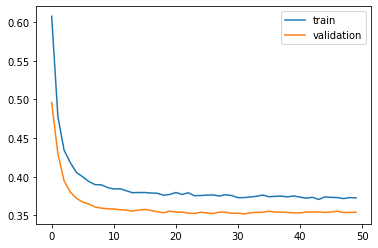

#################################
Number of units: 4
Batch size: 256
Fold: 0
best val loss: 0.3518235126015736
#################################
Time to train MLP:  81.51814699172974
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.6091 - acc: 0.7634 - val_loss: 0.4913 - val_acc: 0.8501

Epoch 00001: val_loss improved from inf to 0.49132, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4752 - acc: 0.8389 - val_loss: 0.4223 - val_acc: 0.8550

Epoch 00002: val_loss improved from 0.49132 to 0.42228, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4330 - acc: 0.8426 - val_loss: 0.3906 - val_acc: 0.8586

Epoch 00003: val_loss improved from 0.42228 to 0.39061, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4142 - acc: 0.8435 - val_loss: 0.3758 - val_acc: 0.8573

Epoch 00004: val_loss improved from 0.39061 to 0.37577, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4036 - acc: 0.8453 - val_loss: 0.365

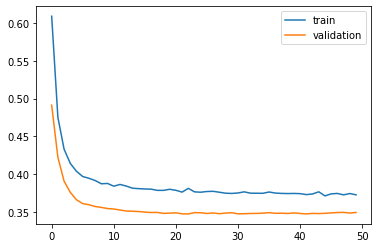

#################################
Number of units: 4
Batch size: 256
Fold: 1
best val loss: 0.34727124433768425
#################################
Time to train MLP:  79.39687156677246
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.6091 - acc: 0.7678 - val_loss: 0.5013 - val_acc: 0.8491

Epoch 00001: val_loss improved from inf to 0.50132, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4774 - acc: 0.8384 - val_loss: 0.4341 - val_acc: 0.8513

Epoch 00002: val_loss improved from 0.50132 to 0.43412, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4333 - acc: 0.8438 - val_loss: 0.4024 - val_acc: 0.8537

Epoch 00003: val_loss improved from 0.43412 to 0.40244, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4113 - acc: 0.8468 - val_loss: 0.3872 - val_acc: 0.8564

Epoch 00004: val_loss improved from 0.40244 to 0.38719, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4045 - acc: 0.8457 - val_loss: 0.379

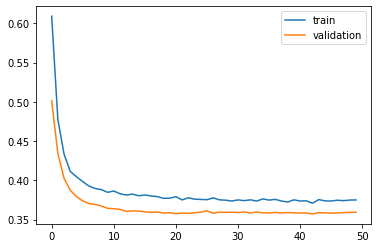

#################################
Number of units: 4
Batch size: 256
Fold: 2
best val loss: 0.35723006670935115
#################################
Time to train MLP:  79.60338020324707
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 13s - loss: 0.6064 - acc: 0.7685 - val_loss: 0.4971 - val_acc: 0.8488

Epoch 00001: val_loss improved from inf to 0.49711, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4775 - acc: 0.8365 - val_loss: 0.4250 - val_acc: 0.8566

Epoch 00002: val_loss improved from 0.49711 to 0.42495, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4335 - acc: 0.8432 - val_loss: 0.3939 - val_acc: 0.8559

Epoch 00003: val_loss improved from 0.42495 to 0.39390, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4144 - acc: 0.8438 - val_loss: 0.3787 - val_acc: 0.8596

Epoch 00004: val_loss improved from 0.39390 to 0.37866, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4029 - acc: 0.8462 - val_loss: 0.37

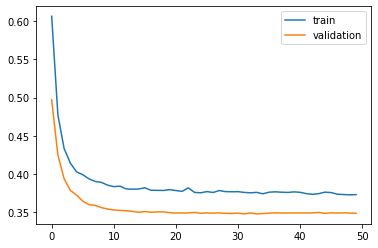

#################################
Number of units: 4
Batch size: 256
Fold: 3
best val loss: 0.3478706314619522
#################################
Time to train MLP:  83.68806576728821
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.6096 - acc: 0.7683 - val_loss: 0.5013 - val_acc: 0.8465

Epoch 00001: val_loss improved from inf to 0.50130, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4784 - acc: 0.8408 - val_loss: 0.4305 - val_acc: 0.8524

Epoch 00002: val_loss improved from 0.50130 to 0.43055, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4371 - acc: 0.8437 - val_loss: 0.3986 - val_acc: 0.8522

Epoch 00003: val_loss improved from 0.43055 to 0.39858, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4138 - acc: 0.8458 - val_loss: 0.3837 - val_acc: 0.8525

Epoch 00004: val_loss improved from 0.39858 to 0.38365, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4025 - acc: 0.8458 - val_loss: 0.375

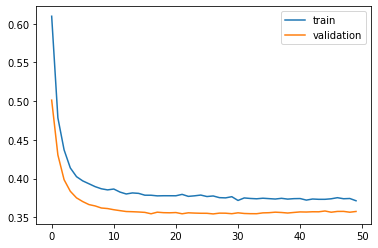

#################################
Number of units: 4
Batch size: 256
Fold: 4
best val loss: 0.35442588131330166
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f90855aaef0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f9085473748>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.6480 - acc: 0.7308 - val_loss: 0.5521 - val_acc: 0.8460

Epoch 00001: val_loss improved from inf to 0.55206, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5296 - acc: 0.8334 - val_loss: 0.4824 - val_acc: 0.8566

Epoch 00002: val_loss improved from 0.55206 to 0.48240, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4783 - acc: 0.8437 - val_loss: 0.4449 - val_acc: 0.8594

Epoch 00003: val_loss improved from 0.48240 to 0.44490, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4494 - acc: 0.8460 - val_loss: 0.4160 - val_acc: 0.8595

Epoch 00004: val_loss improved from 0.44490 to 0.41602, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4279 - acc: 0.8476 - val_loss: 0.3989 - val_acc: 0.8591

Epoch 00005: val_loss improved from 0.41602 to 0.39891, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 1s - loss: 0.4167 - acc: 0.8469 - val_loss: 0.3879 - va

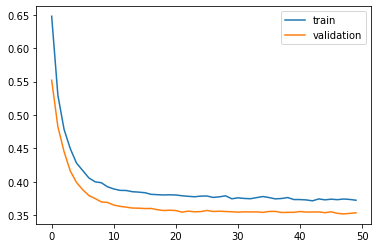

#################################
Number of units: 4
Batch size: 512
Fold: 0
best val loss: 0.3517016659354606
#################################
Time to train MLP:  58.914833068847656
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.6467 - acc: 0.7275 - val_loss: 0.5489 - val_acc: 0.8422

Epoch 00001: val_loss improved from inf to 0.54890, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5294 - acc: 0.8324 - val_loss: 0.4801 - val_acc: 0.8550

Epoch 00002: val_loss improved from 0.54890 to 0.48013, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4771 - acc: 0.8444 - val_loss: 0.4415 - val_acc: 0.8570

Epoch 00003: val_loss improved from 0.48013 to 0.44147, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4479 - acc: 0.8447 - val_loss: 0.4158 - val_acc: 0.8587

Epoch 00004: val_loss improved from 0.44147 to 0.41578, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4297 - acc: 0.8473 - val_loss: 0.39

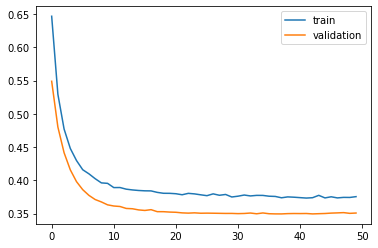

#################################
Number of units: 4
Batch size: 512
Fold: 1
best val loss: 0.34951644637431317
#################################
Time to train MLP:  58.484378814697266
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.6479 - acc: 0.7288 - val_loss: 0.5561 - val_acc: 0.8396

Epoch 00001: val_loss improved from inf to 0.55609, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5292 - acc: 0.8305 - val_loss: 0.4879 - val_acc: 0.8533

Epoch 00002: val_loss improved from 0.55609 to 0.48787, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4777 - acc: 0.8432 - val_loss: 0.4487 - val_acc: 0.8545

Epoch 00003: val_loss improved from 0.48787 to 0.44871, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4467 - acc: 0.8471 - val_loss: 0.4246 - val_acc: 0.8546

Epoch 00004: val_loss improved from 0.44871 to 0.42457, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4292 - acc: 0.8475 - val_loss: 0.4

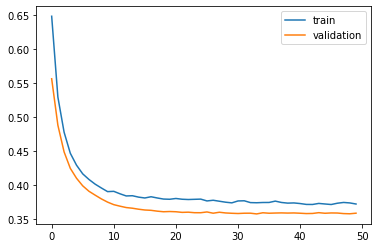

#################################
Number of units: 4
Batch size: 512
Fold: 2
best val loss: 0.35763992873548767
#################################
Time to train MLP:  59.57844567298889
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.6450 - acc: 0.7299 - val_loss: 0.5511 - val_acc: 0.8422

Epoch 00001: val_loss improved from inf to 0.55111, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5266 - acc: 0.8335 - val_loss: 0.4786 - val_acc: 0.8563

Epoch 00002: val_loss improved from 0.55111 to 0.47863, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4774 - acc: 0.8445 - val_loss: 0.4410 - val_acc: 0.8578

Epoch 00003: val_loss improved from 0.47863 to 0.44104, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4481 - acc: 0.8444 - val_loss: 0.4170 - val_acc: 0.8582

Epoch 00004: val_loss improved from 0.44104 to 0.41696, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4287 - acc: 0.8484 - val_loss: 0.39

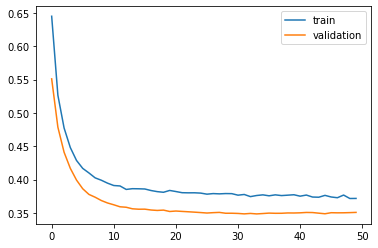

#################################
Number of units: 4
Batch size: 512
Fold: 3
best val loss: 0.3485683988827711
#################################
Time to train MLP:  64.69690299034119
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.6484 - acc: 0.7307 - val_loss: 0.5530 - val_acc: 0.8460

Epoch 00001: val_loss improved from inf to 0.55304, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5323 - acc: 0.8309 - val_loss: 0.4819 - val_acc: 0.8520

Epoch 00002: val_loss improved from 0.55304 to 0.48187, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4781 - acc: 0.8449 - val_loss: 0.4413 - val_acc: 0.8546

Epoch 00003: val_loss improved from 0.48187 to 0.44130, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4489 - acc: 0.8471 - val_loss: 0.4192 - val_acc: 0.8538

Epoch 00004: val_loss improved from 0.44130 to 0.41917, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4292 - acc: 0.8475 - val_loss: 0.403

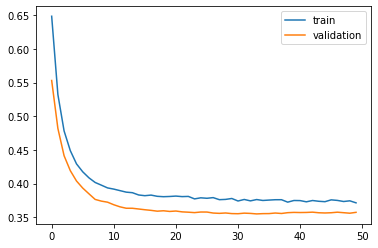

#################################
Number of units: 4
Batch size: 512
Fold: 4
best val loss: 0.3549094382712716
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.33


Epoch 00040: val_loss did not improve from 0.35635
Epoch 41/50
 - 1s - loss: 0.3749 - acc: 0.8546 - val_loss: 0.3573 - val_acc: 0.8619

Epoch 00041: val_loss did not improve from 0.35635
Epoch 42/50
 - 1s - loss: 0.3750 - acc: 0.8542 - val_loss: 0.3565 - val_acc: 0.8636

Epoch 00042: val_loss did not improve from 0.35635
Epoch 43/50
 - 1s - loss: 0.3733 - acc: 0.8558 - val_loss: 0.3572 - val_acc: 0.8639

Epoch 00043: val_loss did not improve from 0.35635
Epoch 44/50
 - 1s - loss: 0.3753 - acc: 0.8549 - val_loss: 0.3569 - val_acc: 0.8621

Epoch 00044: val_loss did not improve from 0.35635
Epoch 45/50
 - 1s - loss: 0.3751 - acc: 0.8543 - val_loss: 0.3568 - val_acc: 0.8633

Epoch 00045: val_loss did not improve from 0.35635
Epoch 46/50
 - 1s - loss: 0.3765 - acc: 0.8547 - val_loss: 0.3566 - val_acc: 0.8618

Epoch 00046: val_loss did not improve from 0.35635
Epoch 47/50
 - 1s - loss: 0.3757 - acc: 0.8544 - val_loss: 0.3554 - val_acc: 0.8636

Epoch 00047: val_loss improved from 0.35635 to 

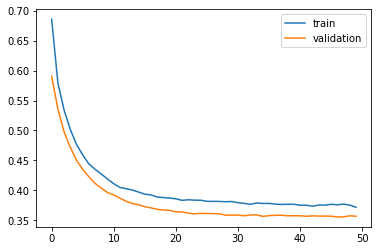

#################################
Number of units: 4
Batch size: 1024
Fold: 0
best val loss: 0.35542981449623556
#################################
Time to train MLP:  46.931554317474365
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.6834 - acc: 0.6818 - val_loss: 0.5926 - val_acc: 0.8165

Epoch 00001: val_loss improved from inf to 0.59260, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5788 - acc: 0.8016 - val_loss: 0.5386 - val_acc: 0.8485

Epoch 00002: val_loss improved from 0.59260 to 0.53859, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5326 - acc: 0.8361 - val_loss: 0.4983 - val_acc: 0.8571

Epoch 00003: val_loss improved from 0.53859 to 0.49832, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5007 - acc: 0.8445 - val_loss: 0.4710 - val_acc: 0.8626

Epoch 00004: val_loss improved from 0.49832 to 0.47096, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4768 - acc: 0.8475 - val_loss: 0.


Epoch 00049: val_loss did not improve from 0.35391
Epoch 50/50
 - 1s - loss: 0.3755 - acc: 0.8533 - val_loss: 0.3548 - val_acc: 0.8628

Epoch 00050: val_loss did not improve from 0.35391


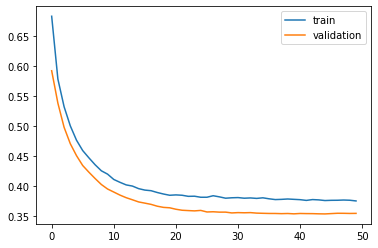

#################################
Number of units: 4
Batch size: 1024
Fold: 1
best val loss: 0.3539115259731025
#################################
Time to train MLP:  46.71577215194702
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.6836 - acc: 0.6834 - val_loss: 0.5990 - val_acc: 0.8133

Epoch 00001: val_loss improved from inf to 0.59904, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5774 - acc: 0.8052 - val_loss: 0.5415 - val_acc: 0.8494

Epoch 00002: val_loss improved from 0.59904 to 0.54149, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5332 - acc: 0.8344 - val_loss: 0.5070 - val_acc: 0.8512

Epoch 00003: val_loss improved from 0.54149 to 0.50699, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5009 - acc: 0.8451 - val_loss: 0.4810 - val_acc: 0.8542

Epoch 00004: val_loss improved from 0.50699 to 0.48099, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4778 - acc: 0.8474 - val_loss: 0.46


Epoch 00049: val_loss improved from 0.36173 to 0.36147, saving model to MLP_val_weights.hdf5
Epoch 50/50
 - 1s - loss: 0.3767 - acc: 0.8525 - val_loss: 0.3626 - val_acc: 0.8611

Epoch 00050: val_loss did not improve from 0.36147


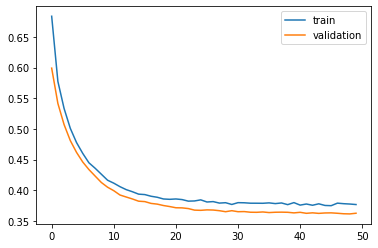

#################################
Number of units: 4
Batch size: 1024
Fold: 2
best val loss: 0.36147154988601193
#################################
Time to train MLP:  46.46255016326904
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 12s - loss: 0.6823 - acc: 0.6861 - val_loss: 0.5980 - val_acc: 0.8139

Epoch 00001: val_loss improved from inf to 0.59803, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5757 - acc: 0.8072 - val_loss: 0.5361 - val_acc: 0.8485

Epoch 00002: val_loss improved from 0.59803 to 0.53612, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5314 - acc: 0.8365 - val_loss: 0.5000 - val_acc: 0.8558

Epoch 00003: val_loss improved from 0.53612 to 0.50004, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.4984 - acc: 0.8440 - val_loss: 0.4737 - val_acc: 0.8575

Epoch 00004: val_loss improved from 0.50004 to 0.47374, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4760 - acc: 0.8487 - val_loss: 0.4


Epoch 00049: val_loss did not improve from 0.35172
Epoch 50/50
 - 1s - loss: 0.3755 - acc: 0.8533 - val_loss: 0.3524 - val_acc: 0.8646

Epoch 00050: val_loss did not improve from 0.35172


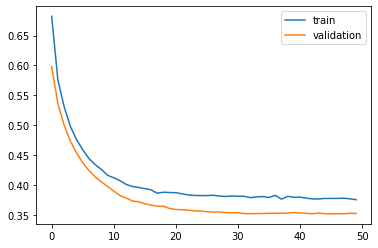

#################################
Number of units: 4
Batch size: 1024
Fold: 3
best val loss: 0.35171704196093373
#################################
Time to train MLP:  47.86226725578308
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 12s - loss: 0.6852 - acc: 0.6836 - val_loss: 0.5949 - val_acc: 0.8193

Epoch 00001: val_loss improved from inf to 0.59486, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.5796 - acc: 0.7995 - val_loss: 0.5393 - val_acc: 0.8491

Epoch 00002: val_loss improved from 0.59486 to 0.53925, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.5347 - acc: 0.8364 - val_loss: 0.4985 - val_acc: 0.8556

Epoch 00003: val_loss improved from 0.53925 to 0.49853, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.5022 - acc: 0.8453 - val_loss: 0.4728 - val_acc: 0.8552

Epoch 00004: val_loss improved from 0.49853 to 0.47279, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.4785 - acc: 0.8471 - val_loss: 0.4

 - 1s - loss: 0.3760 - acc: 0.8540 - val_loss: 0.3608 - val_acc: 0.8570

Epoch 00050: val_loss improved from 0.36097 to 0.36085, saving model to MLP_val_weights.hdf5


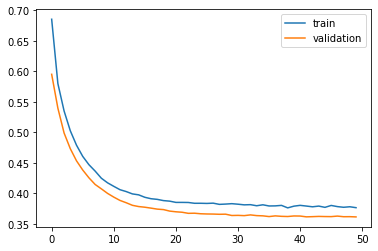

#################################
Number of units: 4
Batch size: 1024
Fold: 4
best val loss: 0.3608499501392855
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3

 - 4s - loss: 0.3292 - acc: 0.8714 - val_loss: 0.3332 - val_acc: 0.8687

Epoch 00045: val_loss did not improve from 0.32957
Epoch 46/50
 - 4s - loss: 0.3287 - acc: 0.8719 - val_loss: 0.3325 - val_acc: 0.8702

Epoch 00046: val_loss did not improve from 0.32957
Epoch 47/50
 - 4s - loss: 0.3266 - acc: 0.8722 - val_loss: 0.3332 - val_acc: 0.8694

Epoch 00047: val_loss did not improve from 0.32957
Epoch 48/50
 - 4s - loss: 0.3275 - acc: 0.8714 - val_loss: 0.3354 - val_acc: 0.8705

Epoch 00048: val_loss did not improve from 0.32957
Epoch 49/50
 - 4s - loss: 0.3263 - acc: 0.8734 - val_loss: 0.3346 - val_acc: 0.8706

Epoch 00049: val_loss did not improve from 0.32957
Epoch 50/50
 - 4s - loss: 0.3263 - acc: 0.8727 - val_loss: 0.3346 - val_acc: 0.8704

Epoch 00050: val_loss did not improve from 0.32957


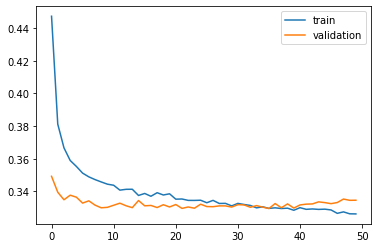

#################################
Number of units: 8
Batch size: 64
Fold: 0
best val loss: 0.3295652441462578
#################################
Time to train MLP:  220.47865223884583
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 21s - loss: 0.4422 - acc: 0.8073 - val_loss: 0.3460 - val_acc: 0.8607

Epoch 00001: val_loss improved from inf to 0.34603, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3825 - acc: 0.8405 - val_loss: 0.3367 - val_acc: 0.8677

Epoch 00002: val_loss improved from 0.34603 to 0.33673, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3678 - acc: 0.8515 - val_loss: 0.3337 - val_acc: 0.8661

Epoch 00003: val_loss improved from 0.33673 to 0.33374, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3618 - acc: 0.8578 - val_loss: 0.3296 - val_acc: 0.8671

Epoch 00004: val_loss improved from 0.33374 to 0.32963, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3576 - acc: 0.8603 - val_loss: 0.328

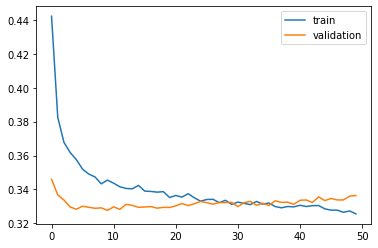

#################################
Number of units: 8
Batch size: 64
Fold: 1
best val loss: 0.3276826430133909
#################################
Time to train MLP:  219.71211123466492
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.4458 - acc: 0.8050 - val_loss: 0.3533 - val_acc: 0.8577

Epoch 00001: val_loss improved from inf to 0.35335, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3802 - acc: 0.8425 - val_loss: 0.3456 - val_acc: 0.8599

Epoch 00002: val_loss improved from 0.35335 to 0.34560, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3680 - acc: 0.8530 - val_loss: 0.3406 - val_acc: 0.8625

Epoch 00003: val_loss improved from 0.34560 to 0.34056, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3630 - acc: 0.8563 - val_loss: 0.3381 - val_acc: 0.8636

Epoch 00004: val_loss improved from 0.34056 to 0.33807, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3599 - acc: 0.8560 - val_loss: 0.337

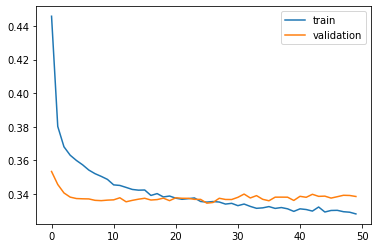

#################################
Number of units: 8
Batch size: 64
Fold: 2
best val loss: 0.3344785308001334
#################################
Time to train MLP:  216.54046511650085
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4446 - acc: 0.8048 - val_loss: 0.3472 - val_acc: 0.8607

Epoch 00001: val_loss improved from inf to 0.34719, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3774 - acc: 0.8451 - val_loss: 0.3367 - val_acc: 0.8660

Epoch 00002: val_loss improved from 0.34719 to 0.33671, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3673 - acc: 0.8535 - val_loss: 0.3334 - val_acc: 0.8680

Epoch 00003: val_loss improved from 0.33671 to 0.33342, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3615 - acc: 0.8563 - val_loss: 0.3309 - val_acc: 0.8696

Epoch 00004: val_loss improved from 0.33342 to 0.33088, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3573 - acc: 0.8596 - val_loss: 0.332

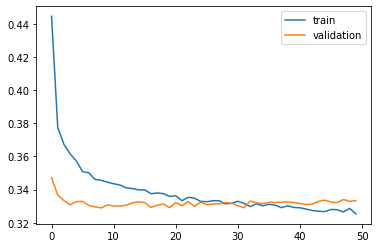

#################################
Number of units: 8
Batch size: 64
Fold: 3
best val loss: 0.3289671560965086
#################################
Time to train MLP:  216.68796491622925
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.4441 - acc: 0.8067 - val_loss: 0.3507 - val_acc: 0.8575

Epoch 00001: val_loss improved from inf to 0.35067, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3776 - acc: 0.8446 - val_loss: 0.3387 - val_acc: 0.8614

Epoch 00002: val_loss improved from 0.35067 to 0.33871, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3643 - acc: 0.8549 - val_loss: 0.3394 - val_acc: 0.8615

Epoch 00003: val_loss did not improve from 0.33871
Epoch 4/50
 - 4s - loss: 0.3604 - acc: 0.8565 - val_loss: 0.3369 - val_acc: 0.8611

Epoch 00004: val_loss improved from 0.33871 to 0.33685, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3538 - acc: 0.8601 - val_loss: 0.3382 - val_acc: 0.8599

Epoch 00005: val_loss

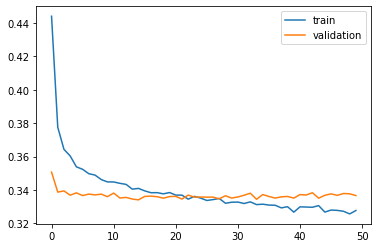

#################################
Number of units: 8
Batch size: 64
Fold: 4
best val loss: 0.334044300931239
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3389


Epoch 00043: val_loss did not improve from 0.32881
Epoch 44/50
 - 3s - loss: 0.3294 - acc: 0.8671 - val_loss: 0.3337 - val_acc: 0.8691

Epoch 00044: val_loss did not improve from 0.32881
Epoch 45/50
 - 3s - loss: 0.3294 - acc: 0.8682 - val_loss: 0.3343 - val_acc: 0.8669

Epoch 00045: val_loss did not improve from 0.32881
Epoch 46/50
 - 3s - loss: 0.3293 - acc: 0.8676 - val_loss: 0.3333 - val_acc: 0.8692

Epoch 00046: val_loss did not improve from 0.32881
Epoch 47/50
 - 2s - loss: 0.3274 - acc: 0.8692 - val_loss: 0.3331 - val_acc: 0.8688

Epoch 00047: val_loss did not improve from 0.32881
Epoch 48/50
 - 2s - loss: 0.3276 - acc: 0.8693 - val_loss: 0.3333 - val_acc: 0.8687

Epoch 00048: val_loss did not improve from 0.32881
Epoch 49/50
 - 3s - loss: 0.3268 - acc: 0.8708 - val_loss: 0.3350 - val_acc: 0.8678

Epoch 00049: val_loss did not improve from 0.32881
Epoch 50/50
 - 3s - loss: 0.3282 - acc: 0.8687 - val_loss: 0.3360 - val_acc: 0.8670

Epoch 00050: val_loss did not improve from 0.32

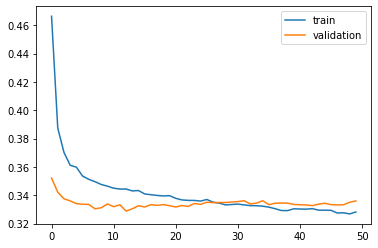

#################################
Number of units: 8
Batch size: 128
Fold: 0
best val loss: 0.32881316136895566
#################################
Time to train MLP:  140.49091792106628
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 14s - loss: 0.4642 - acc: 0.7929 - val_loss: 0.3517 - val_acc: 0.8615

Epoch 00001: val_loss improved from inf to 0.35165, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3870 - acc: 0.8361 - val_loss: 0.3388 - val_acc: 0.8655

Epoch 00002: val_loss improved from 0.35165 to 0.33877, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3707 - acc: 0.8460 - val_loss: 0.3344 - val_acc: 0.8670

Epoch 00003: val_loss improved from 0.33877 to 0.33441, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3632 - acc: 0.8544 - val_loss: 0.3328 - val_acc: 0.8678

Epoch 00004: val_loss improved from 0.33441 to 0.33285, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3582 - acc: 0.8563 - val_loss: 0.3

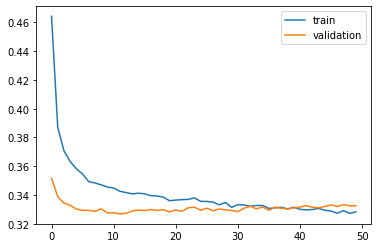

#################################
Number of units: 8
Batch size: 128
Fold: 1
best val loss: 0.3268593524631701
#################################
Time to train MLP:  138.05754208564758
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4647 - acc: 0.7953 - val_loss: 0.3560 - val_acc: 0.8557

Epoch 00001: val_loss improved from inf to 0.35598, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3895 - acc: 0.8348 - val_loss: 0.3465 - val_acc: 0.8615

Epoch 00002: val_loss improved from 0.35598 to 0.34650, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3734 - acc: 0.8431 - val_loss: 0.3430 - val_acc: 0.8644

Epoch 00003: val_loss improved from 0.34650 to 0.34299, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3650 - acc: 0.8532 - val_loss: 0.3393 - val_acc: 0.8613

Epoch 00004: val_loss improved from 0.34299 to 0.33933, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3595 - acc: 0.8573 - val_loss: 0.33

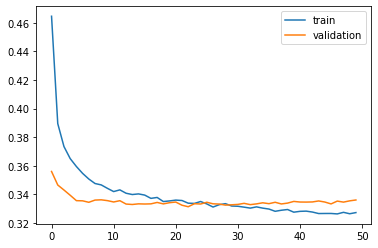

#################################
Number of units: 8
Batch size: 128
Fold: 2
best val loss: 0.33128507831640414
#################################
Time to train MLP:  138.40111660957336
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4630 - acc: 0.7941 - val_loss: 0.3524 - val_acc: 0.8584

Epoch 00001: val_loss improved from inf to 0.35241, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3868 - acc: 0.8392 - val_loss: 0.3415 - val_acc: 0.8655

Epoch 00002: val_loss improved from 0.35241 to 0.34147, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3693 - acc: 0.8511 - val_loss: 0.3368 - val_acc: 0.8664

Epoch 00003: val_loss improved from 0.34147 to 0.33684, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3622 - acc: 0.8563 - val_loss: 0.3340 - val_acc: 0.8667

Epoch 00004: val_loss improved from 0.33684 to 0.33399, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3587 - acc: 0.8592 - val_loss: 0.3

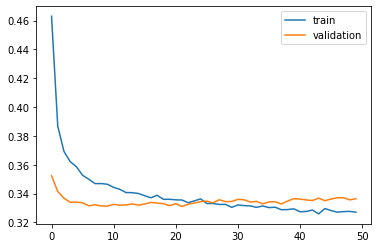

#################################
Number of units: 8
Batch size: 128
Fold: 3
best val loss: 0.33106614080786007
#################################
Time to train MLP:  138.7936146259308
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.4630 - acc: 0.7941 - val_loss: 0.3570 - val_acc: 0.8580

Epoch 00001: val_loss improved from inf to 0.35703, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3839 - acc: 0.8410 - val_loss: 0.3444 - val_acc: 0.8618

Epoch 00002: val_loss improved from 0.35703 to 0.34441, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3696 - acc: 0.8508 - val_loss: 0.3407 - val_acc: 0.8625

Epoch 00003: val_loss improved from 0.34441 to 0.34072, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3614 - acc: 0.8557 - val_loss: 0.3376 - val_acc: 0.8632

Epoch 00004: val_loss improved from 0.34072 to 0.33758, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3581 - acc: 0.8568 - val_loss: 0.33

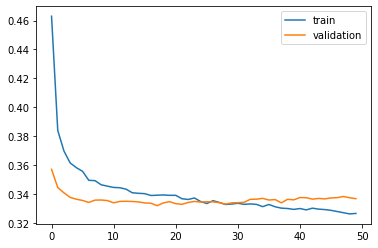

#################################
Number of units: 8
Batch size: 128
Fold: 4
best val loss: 0.33184724300925494
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3

 - 2s - loss: 0.3312 - acc: 0.8687 - val_loss: 0.3359 - val_acc: 0.8685

Epoch 00042: val_loss did not improve from 0.32854
Epoch 43/50
 - 2s - loss: 0.3300 - acc: 0.8692 - val_loss: 0.3372 - val_acc: 0.8687

Epoch 00043: val_loss did not improve from 0.32854
Epoch 44/50
 - 2s - loss: 0.3305 - acc: 0.8677 - val_loss: 0.3365 - val_acc: 0.8680

Epoch 00044: val_loss did not improve from 0.32854
Epoch 45/50
 - 2s - loss: 0.3299 - acc: 0.8688 - val_loss: 0.3380 - val_acc: 0.8670

Epoch 00045: val_loss did not improve from 0.32854
Epoch 46/50
 - 2s - loss: 0.3297 - acc: 0.8684 - val_loss: 0.3367 - val_acc: 0.8673

Epoch 00046: val_loss did not improve from 0.32854
Epoch 47/50
 - 2s - loss: 0.3290 - acc: 0.8688 - val_loss: 0.3364 - val_acc: 0.8669

Epoch 00047: val_loss did not improve from 0.32854
Epoch 48/50
 - 2s - loss: 0.3281 - acc: 0.8697 - val_loss: 0.3363 - val_acc: 0.8690

Epoch 00048: val_loss did not improve from 0.32854
Epoch 49/50
 - 2s - loss: 0.3285 - acc: 0.8695 - val_loss: 0

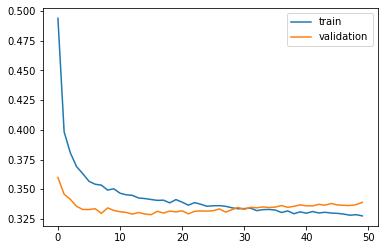

#################################
Number of units: 8
Batch size: 256
Fold: 0
best val loss: 0.32854024846651403
#################################
Time to train MLP:  97.20357155799866
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4940 - acc: 0.7739 - val_loss: 0.3598 - val_acc: 0.8568

Epoch 00001: val_loss improved from inf to 0.35983, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3972 - acc: 0.8330 - val_loss: 0.3441 - val_acc: 0.8618

Epoch 00002: val_loss improved from 0.35983 to 0.34414, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3785 - acc: 0.8432 - val_loss: 0.3376 - val_acc: 0.8634

Epoch 00003: val_loss improved from 0.34414 to 0.33760, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3691 - acc: 0.8488 - val_loss: 0.3347 - val_acc: 0.8669

Epoch 00004: val_loss improved from 0.33760 to 0.33468, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3623 - acc: 0.8542 - val_loss: 0.33

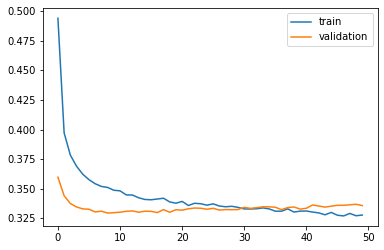

#################################
Number of units: 8
Batch size: 256
Fold: 1
best val loss: 0.3295160407141635
#################################
Time to train MLP:  96.76350927352905
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4926 - acc: 0.7751 - val_loss: 0.3608 - val_acc: 0.8549

Epoch 00001: val_loss improved from inf to 0.36084, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4002 - acc: 0.8314 - val_loss: 0.3475 - val_acc: 0.8601

Epoch 00002: val_loss improved from 0.36084 to 0.34749, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3793 - acc: 0.8409 - val_loss: 0.3442 - val_acc: 0.8626

Epoch 00003: val_loss improved from 0.34749 to 0.34420, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3707 - acc: 0.8483 - val_loss: 0.3408 - val_acc: 0.8614

Epoch 00004: val_loss improved from 0.34420 to 0.34080, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3619 - acc: 0.8534 - val_loss: 0.339

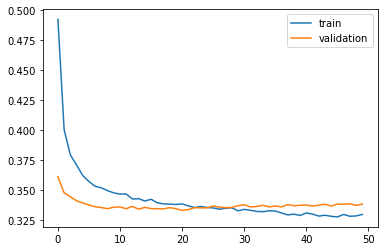

#################################
Number of units: 8
Batch size: 256
Fold: 2
best val loss: 0.3328127431067807
#################################
Time to train MLP:  96.73208570480347
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.4898 - acc: 0.7764 - val_loss: 0.3621 - val_acc: 0.8568

Epoch 00001: val_loss improved from inf to 0.36211, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3969 - acc: 0.8327 - val_loss: 0.3468 - val_acc: 0.8623

Epoch 00002: val_loss improved from 0.36211 to 0.34683, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3795 - acc: 0.8416 - val_loss: 0.3405 - val_acc: 0.8662

Epoch 00003: val_loss improved from 0.34683 to 0.34050, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3693 - acc: 0.8478 - val_loss: 0.3359 - val_acc: 0.8681

Epoch 00004: val_loss improved from 0.34050 to 0.33592, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3632 - acc: 0.8540 - val_loss: 0.335

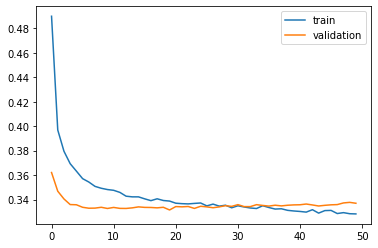

#################################
Number of units: 8
Batch size: 256
Fold: 3
best val loss: 0.33150248866332205
#################################
Time to train MLP:  99.77236413955688
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 18s - loss: 0.4912 - acc: 0.7758 - val_loss: 0.3670 - val_acc: 0.8554

Epoch 00001: val_loss improved from inf to 0.36699, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3963 - acc: 0.8325 - val_loss: 0.3482 - val_acc: 0.8600

Epoch 00002: val_loss improved from 0.36699 to 0.34818, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3789 - acc: 0.8426 - val_loss: 0.3435 - val_acc: 0.8622

Epoch 00003: val_loss improved from 0.34818 to 0.34355, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3673 - acc: 0.8509 - val_loss: 0.3401 - val_acc: 0.8615

Epoch 00004: val_loss improved from 0.34355 to 0.34007, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3627 - acc: 0.8555 - val_loss: 0.33

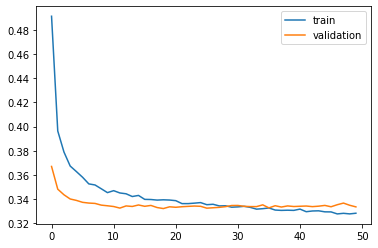

#################################
Number of units: 8
Batch size: 256
Fold: 4
best val loss: 0.3321554691052576
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.33

 - 1s - loss: 0.3311 - acc: 0.8743 - val_loss: 0.3370 - val_acc: 0.8684

Epoch 00040: val_loss did not improve from 0.33183
Epoch 41/50
 - 1s - loss: 0.3319 - acc: 0.8728 - val_loss: 0.3341 - val_acc: 0.8675

Epoch 00041: val_loss did not improve from 0.33183
Epoch 42/50
 - 1s - loss: 0.3291 - acc: 0.8741 - val_loss: 0.3372 - val_acc: 0.8667

Epoch 00042: val_loss did not improve from 0.33183
Epoch 43/50
 - 1s - loss: 0.3306 - acc: 0.8748 - val_loss: 0.3346 - val_acc: 0.8653

Epoch 00043: val_loss did not improve from 0.33183
Epoch 44/50
 - 1s - loss: 0.3294 - acc: 0.8742 - val_loss: 0.3352 - val_acc: 0.8668

Epoch 00044: val_loss did not improve from 0.33183
Epoch 45/50
 - 1s - loss: 0.3293 - acc: 0.8739 - val_loss: 0.3362 - val_acc: 0.8676

Epoch 00045: val_loss did not improve from 0.33183
Epoch 46/50
 - 1s - loss: 0.3290 - acc: 0.8748 - val_loss: 0.3361 - val_acc: 0.8670

Epoch 00046: val_loss did not improve from 0.33183
Epoch 47/50
 - 1s - loss: 0.3288 - acc: 0.8751 - val_loss: 0

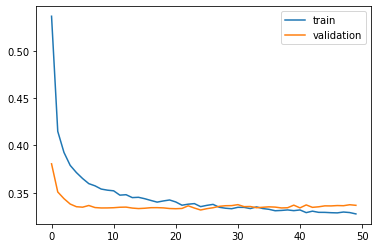

#################################
Number of units: 8
Batch size: 512
Fold: 0
best val loss: 0.33182906958094815
#################################
Time to train MLP:  70.24765419960022
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.5366 - acc: 0.7375 - val_loss: 0.3793 - val_acc: 0.8516

Epoch 00001: val_loss improved from inf to 0.37931, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4182 - acc: 0.8246 - val_loss: 0.3497 - val_acc: 0.8613

Epoch 00002: val_loss improved from 0.37931 to 0.34971, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3939 - acc: 0.8331 - val_loss: 0.3411 - val_acc: 0.8636

Epoch 00003: val_loss improved from 0.34971 to 0.34110, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3793 - acc: 0.8404 - val_loss: 0.3380 - val_acc: 0.8651

Epoch 00004: val_loss improved from 0.34110 to 0.33805, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3721 - acc: 0.8456 - val_loss: 0.33

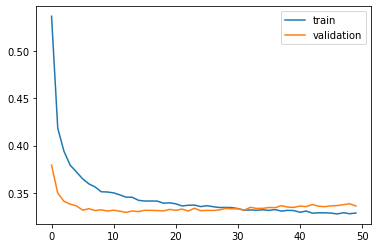

#################################
Number of units: 8
Batch size: 512
Fold: 1
best val loss: 0.329389640030108
#################################
Time to train MLP:  70.50638580322266
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.5377 - acc: 0.7390 - val_loss: 0.3865 - val_acc: 0.8463

Epoch 00001: val_loss improved from inf to 0.38649, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4163 - acc: 0.8263 - val_loss: 0.3565 - val_acc: 0.8537

Epoch 00002: val_loss improved from 0.38649 to 0.35651, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3906 - acc: 0.8364 - val_loss: 0.3467 - val_acc: 0.8604

Epoch 00003: val_loss improved from 0.35651 to 0.34669, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3783 - acc: 0.8422 - val_loss: 0.3439 - val_acc: 0.8621

Epoch 00004: val_loss improved from 0.34669 to 0.34395, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3706 - acc: 0.8469 - val_loss: 0.3431

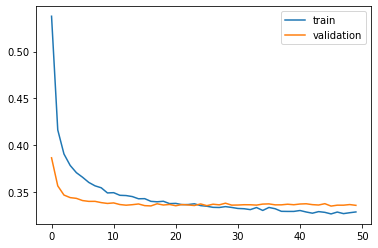

#################################
Number of units: 8
Batch size: 512
Fold: 2
best val loss: 0.3348969116615273
#################################
Time to train MLP:  71.88623785972595
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.5324 - acc: 0.7424 - val_loss: 0.3826 - val_acc: 0.8508

Epoch 00001: val_loss improved from inf to 0.38261, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4163 - acc: 0.8260 - val_loss: 0.3522 - val_acc: 0.8584

Epoch 00002: val_loss improved from 0.38261 to 0.35222, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3922 - acc: 0.8352 - val_loss: 0.3416 - val_acc: 0.8656

Epoch 00003: val_loss improved from 0.35222 to 0.34155, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3781 - acc: 0.8425 - val_loss: 0.3378 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.34155 to 0.33784, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3710 - acc: 0.8451 - val_loss: 0.337

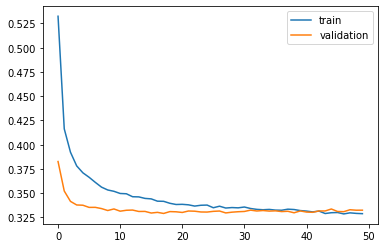

#################################
Number of units: 8
Batch size: 512
Fold: 3
best val loss: 0.3290945730920424
#################################
Time to train MLP:  71.31529355049133
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 19s - loss: 0.5344 - acc: 0.7386 - val_loss: 0.3880 - val_acc: 0.8460

Epoch 00001: val_loss improved from inf to 0.38805, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4157 - acc: 0.8248 - val_loss: 0.3570 - val_acc: 0.8571

Epoch 00002: val_loss improved from 0.38805 to 0.35695, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3916 - acc: 0.8369 - val_loss: 0.3501 - val_acc: 0.8584

Epoch 00003: val_loss improved from 0.35695 to 0.35005, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3790 - acc: 0.8428 - val_loss: 0.3446 - val_acc: 0.8587

Epoch 00004: val_loss improved from 0.35005 to 0.34464, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3699 - acc: 0.8483 - val_loss: 0.342

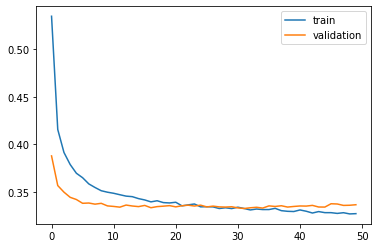

#################################
Number of units: 8
Batch size: 512
Fold: 4
best val loss: 0.33292791203448646
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3

 - 1s - loss: 0.3315 - acc: 0.8712 - val_loss: 0.3384 - val_acc: 0.8657

Epoch 00040: val_loss did not improve from 0.33243
Epoch 41/50
 - 1s - loss: 0.3320 - acc: 0.8706 - val_loss: 0.3389 - val_acc: 0.8675

Epoch 00041: val_loss did not improve from 0.33243
Epoch 42/50
 - 1s - loss: 0.3318 - acc: 0.8742 - val_loss: 0.3389 - val_acc: 0.8674

Epoch 00042: val_loss did not improve from 0.33243
Epoch 43/50
 - 1s - loss: 0.3312 - acc: 0.8737 - val_loss: 0.3385 - val_acc: 0.8646

Epoch 00043: val_loss did not improve from 0.33243
Epoch 44/50
 - 1s - loss: 0.3300 - acc: 0.8748 - val_loss: 0.3385 - val_acc: 0.8668

Epoch 00044: val_loss did not improve from 0.33243
Epoch 45/50
 - 1s - loss: 0.3297 - acc: 0.8741 - val_loss: 0.3379 - val_acc: 0.8667

Epoch 00045: val_loss did not improve from 0.33243
Epoch 46/50
 - 1s - loss: 0.3286 - acc: 0.8746 - val_loss: 0.3383 - val_acc: 0.8674

Epoch 00046: val_loss did not improve from 0.33243
Epoch 47/50
 - 1s - loss: 0.3277 - acc: 0.8726 - val_loss: 0

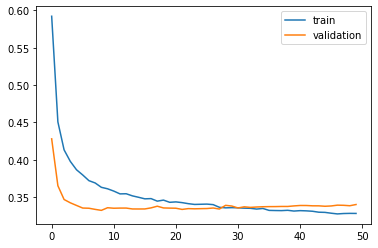

#################################
Number of units: 8
Batch size: 1024
Fold: 0
best val loss: 0.3324285872498451
#################################
Time to train MLP:  57.02451038360596
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.5919 - acc: 0.6853 - val_loss: 0.4315 - val_acc: 0.8402

Epoch 00001: val_loss improved from inf to 0.43152, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4535 - acc: 0.8085 - val_loss: 0.3684 - val_acc: 0.8553

Epoch 00002: val_loss improved from 0.43152 to 0.36838, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4132 - acc: 0.8281 - val_loss: 0.3504 - val_acc: 0.8608

Epoch 00003: val_loss improved from 0.36838 to 0.35042, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3986 - acc: 0.8334 - val_loss: 0.3431 - val_acc: 0.8625

Epoch 00004: val_loss improved from 0.35042 to 0.34311, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3880 - acc: 0.8355 - val_loss: 0.34

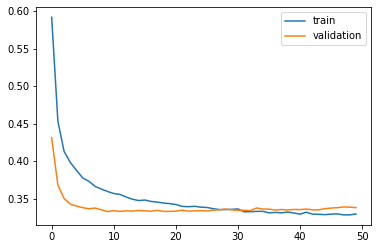

#################################
Number of units: 8
Batch size: 1024
Fold: 1
best val loss: 0.33319622500598084
#################################
Time to train MLP:  55.295708417892456
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.5902 - acc: 0.6853 - val_loss: 0.4334 - val_acc: 0.8310

Epoch 00001: val_loss improved from inf to 0.43341, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4502 - acc: 0.8094 - val_loss: 0.3690 - val_acc: 0.8506

Epoch 00002: val_loss improved from 0.43341 to 0.36896, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4130 - acc: 0.8295 - val_loss: 0.3539 - val_acc: 0.8542

Epoch 00003: val_loss improved from 0.36896 to 0.35394, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3926 - acc: 0.8358 - val_loss: 0.3469 - val_acc: 0.8604

Epoch 00004: val_loss improved from 0.35394 to 0.34686, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3872 - acc: 0.8383 - val_loss: 0.

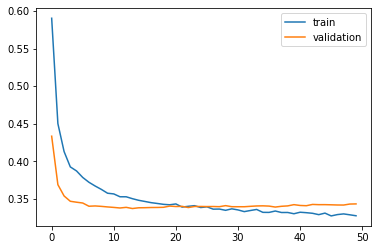

#################################
Number of units: 8
Batch size: 1024
Fold: 2
best val loss: 0.33722839867162424
#################################
Time to train MLP:  55.36440300941467
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.5872 - acc: 0.6859 - val_loss: 0.4298 - val_acc: 0.8416

Epoch 00001: val_loss improved from inf to 0.42984, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4499 - acc: 0.8090 - val_loss: 0.3657 - val_acc: 0.8579

Epoch 00002: val_loss improved from 0.42984 to 0.36572, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4131 - acc: 0.8284 - val_loss: 0.3500 - val_acc: 0.8627

Epoch 00003: val_loss improved from 0.36572 to 0.34998, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3963 - acc: 0.8339 - val_loss: 0.3428 - val_acc: 0.8639

Epoch 00004: val_loss improved from 0.34998 to 0.34284, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3871 - acc: 0.8363 - val_loss: 0.3

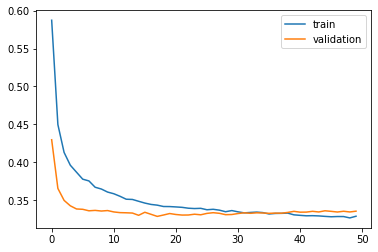

#################################
Number of units: 8
Batch size: 1024
Fold: 3
best val loss: 0.3288919578309645
#################################
Time to train MLP:  54.6611385345459
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 18s - loss: 0.5873 - acc: 0.6851 - val_loss: 0.4337 - val_acc: 0.8351

Epoch 00001: val_loss improved from inf to 0.43370, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4489 - acc: 0.8078 - val_loss: 0.3754 - val_acc: 0.8504

Epoch 00002: val_loss improved from 0.43370 to 0.37537, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.4136 - acc: 0.8274 - val_loss: 0.3583 - val_acc: 0.8539

Epoch 00003: val_loss improved from 0.37537 to 0.35828, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3958 - acc: 0.8360 - val_loss: 0.3533 - val_acc: 0.8558

Epoch 00004: val_loss improved from 0.35828 to 0.35335, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3851 - acc: 0.8382 - val_loss: 0.352

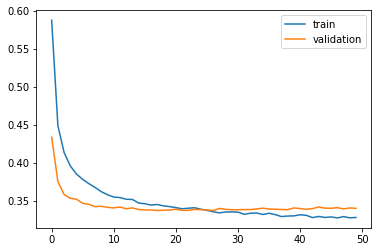

#################################
Number of units: 8
Batch size: 1024
Fold: 4
best val loss: 0.33724856507708456
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.

 - 5s - loss: 0.3016 - acc: 0.8809 - val_loss: 0.3442 - val_acc: 0.8698

Epoch 00040: val_loss did not improve from 0.33016
Epoch 41/50
 - 4s - loss: 0.2987 - acc: 0.8817 - val_loss: 0.3447 - val_acc: 0.8691

Epoch 00041: val_loss did not improve from 0.33016
Epoch 42/50
 - 5s - loss: 0.3004 - acc: 0.8813 - val_loss: 0.3424 - val_acc: 0.8690

Epoch 00042: val_loss did not improve from 0.33016
Epoch 43/50
 - 5s - loss: 0.2995 - acc: 0.8817 - val_loss: 0.3412 - val_acc: 0.8694

Epoch 00043: val_loss did not improve from 0.33016
Epoch 44/50
 - 4s - loss: 0.2987 - acc: 0.8823 - val_loss: 0.3396 - val_acc: 0.8702

Epoch 00044: val_loss did not improve from 0.33016
Epoch 45/50
 - 4s - loss: 0.2968 - acc: 0.8825 - val_loss: 0.3446 - val_acc: 0.8691

Epoch 00045: val_loss did not improve from 0.33016
Epoch 46/50
 - 5s - loss: 0.3000 - acc: 0.8821 - val_loss: 0.3451 - val_acc: 0.8696

Epoch 00046: val_loss did not improve from 0.33016
Epoch 47/50
 - 5s - loss: 0.2985 - acc: 0.8823 - val_loss: 0

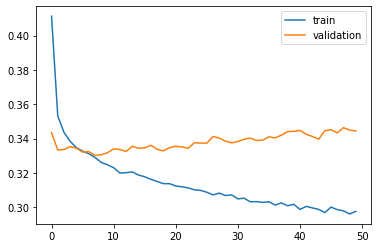

#################################
Number of units: 16
Batch size: 64
Fold: 0
best val loss: 0.33015596666531255
#################################
Time to train MLP:  251.02990055084229
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4084 - acc: 0.8355 - val_loss: 0.3394 - val_acc: 0.8633

Epoch 00001: val_loss improved from inf to 0.33942, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3537 - acc: 0.8621 - val_loss: 0.3324 - val_acc: 0.8670

Epoch 00002: val_loss improved from 0.33942 to 0.33238, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3435 - acc: 0.8664 - val_loss: 0.3299 - val_acc: 0.8670

Epoch 00003: val_loss improved from 0.33238 to 0.32986, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3383 - acc: 0.8683 - val_loss: 0.3297 - val_acc: 0.8701

Epoch 00004: val_loss improved from 0.32986 to 0.32972, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3356 - acc: 0.8681 - val_loss: 0.3

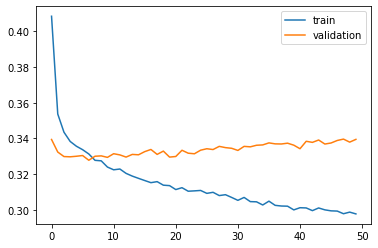

#################################
Number of units: 16
Batch size: 64
Fold: 1
best val loss: 0.32778858105341596
#################################
Time to train MLP:  248.47627019882202
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4107 - acc: 0.8363 - val_loss: 0.3460 - val_acc: 0.8587

Epoch 00001: val_loss improved from inf to 0.34600, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3522 - acc: 0.8630 - val_loss: 0.3360 - val_acc: 0.8650

Epoch 00002: val_loss improved from 0.34600 to 0.33601, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3431 - acc: 0.8664 - val_loss: 0.3384 - val_acc: 0.8626

Epoch 00003: val_loss did not improve from 0.33601
Epoch 4/50
 - 5s - loss: 0.3398 - acc: 0.8686 - val_loss: 0.3357 - val_acc: 0.8643

Epoch 00004: val_loss improved from 0.33601 to 0.33568, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3356 - acc: 0.8690 - val_loss: 0.3344 - val_acc: 0.8640

Epoch 00005: val_lo

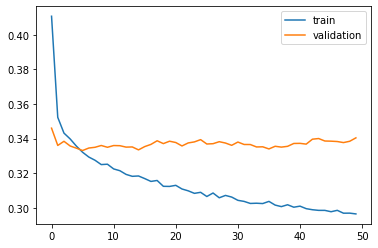

#################################
Number of units: 16
Batch size: 64
Fold: 2
best val loss: 0.3330685358368165
#################################
Time to train MLP:  256.5300934314728
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4128 - acc: 0.8346 - val_loss: 0.3427 - val_acc: 0.8660

Epoch 00001: val_loss improved from inf to 0.34273, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3551 - acc: 0.8621 - val_loss: 0.3380 - val_acc: 0.8694

Epoch 00002: val_loss improved from 0.34273 to 0.33804, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3453 - acc: 0.8648 - val_loss: 0.3355 - val_acc: 0.8695

Epoch 00003: val_loss improved from 0.33804 to 0.33547, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3397 - acc: 0.8678 - val_loss: 0.3339 - val_acc: 0.8696

Epoch 00004: val_loss improved from 0.33547 to 0.33393, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3359 - acc: 0.8685 - val_loss: 0.331

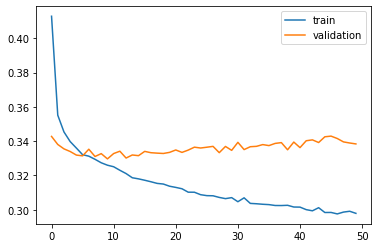

#################################
Number of units: 16
Batch size: 64
Fold: 3
best val loss: 0.3296283411282545
#################################
Time to train MLP:  258.70145773887634
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.4104 - acc: 0.8359 - val_loss: 0.3449 - val_acc: 0.8599

Epoch 00001: val_loss improved from inf to 0.34487, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3519 - acc: 0.8634 - val_loss: 0.3391 - val_acc: 0.8629

Epoch 00002: val_loss improved from 0.34487 to 0.33912, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3441 - acc: 0.8665 - val_loss: 0.3360 - val_acc: 0.8636

Epoch 00003: val_loss improved from 0.33912 to 0.33604, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3386 - acc: 0.8691 - val_loss: 0.3382 - val_acc: 0.8635

Epoch 00004: val_loss did not improve from 0.33604
Epoch 5/50
 - 5s - loss: 0.3344 - acc: 0.8697 - val_loss: 0.3352 - val_acc: 0.8630

Epoch 00005: val_los

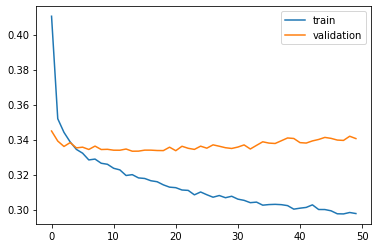

#################################
Number of units: 16
Batch size: 64
Fold: 4
best val loss: 0.3333245563576793
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.33

 - 3s - loss: 0.3018 - acc: 0.8816 - val_loss: 0.3403 - val_acc: 0.8653

Epoch 00038: val_loss did not improve from 0.33240
Epoch 39/50
 - 3s - loss: 0.2994 - acc: 0.8825 - val_loss: 0.3380 - val_acc: 0.8650

Epoch 00039: val_loss did not improve from 0.33240
Epoch 40/50
 - 3s - loss: 0.3014 - acc: 0.8821 - val_loss: 0.3395 - val_acc: 0.8651

Epoch 00040: val_loss did not improve from 0.33240
Epoch 41/50
 - 3s - loss: 0.2992 - acc: 0.8824 - val_loss: 0.3429 - val_acc: 0.8662

Epoch 00041: val_loss did not improve from 0.33240
Epoch 42/50
 - 3s - loss: 0.2997 - acc: 0.8819 - val_loss: 0.3396 - val_acc: 0.8656

Epoch 00042: val_loss did not improve from 0.33240
Epoch 43/50
 - 3s - loss: 0.2994 - acc: 0.8817 - val_loss: 0.3403 - val_acc: 0.8663

Epoch 00043: val_loss did not improve from 0.33240
Epoch 44/50
 - 3s - loss: 0.2985 - acc: 0.8824 - val_loss: 0.3399 - val_acc: 0.8657

Epoch 00044: val_loss did not improve from 0.33240
Epoch 45/50
 - 3s - loss: 0.2985 - acc: 0.8825 - val_loss: 0

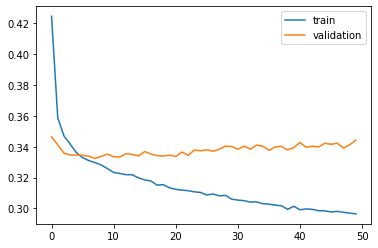

#################################
Number of units: 16
Batch size: 128
Fold: 0
best val loss: 0.3323976531293657
#################################
Time to train MLP:  161.59785556793213
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4231 - acc: 0.8258 - val_loss: 0.3402 - val_acc: 0.8635

Epoch 00001: val_loss improved from inf to 0.34016, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3572 - acc: 0.8620 - val_loss: 0.3330 - val_acc: 0.8646

Epoch 00002: val_loss improved from 0.34016 to 0.33304, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3449 - acc: 0.8668 - val_loss: 0.3309 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.33304 to 0.33089, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3409 - acc: 0.8676 - val_loss: 0.3306 - val_acc: 0.8671

Epoch 00004: val_loss improved from 0.33089 to 0.33062, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3359 - acc: 0.8690 - val_loss: 0.3

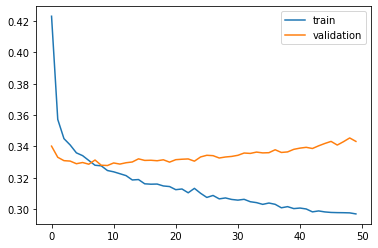

#################################
Number of units: 16
Batch size: 128
Fold: 1
best val loss: 0.32779355684219047
#################################
Time to train MLP:  164.94546699523926
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 24s - loss: 0.4260 - acc: 0.8279 - val_loss: 0.3477 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.34773, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3556 - acc: 0.8624 - val_loss: 0.3398 - val_acc: 0.8627

Epoch 00002: val_loss improved from 0.34773 to 0.33978, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3469 - acc: 0.8664 - val_loss: 0.3371 - val_acc: 0.8628

Epoch 00003: val_loss improved from 0.33978 to 0.33711, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3408 - acc: 0.8684 - val_loss: 0.3362 - val_acc: 0.8654

Epoch 00004: val_loss improved from 0.33711 to 0.33624, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3375 - acc: 0.8686 - val_loss: 0.

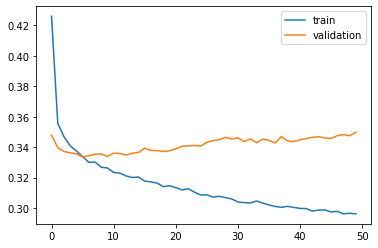

#################################
Number of units: 16
Batch size: 128
Fold: 2
best val loss: 0.33359577397854007
#################################
Time to train MLP:  166.62281608581543
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4276 - acc: 0.8259 - val_loss: 0.3471 - val_acc: 0.8598

Epoch 00001: val_loss improved from inf to 0.34712, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3576 - acc: 0.8618 - val_loss: 0.3373 - val_acc: 0.8660

Epoch 00002: val_loss improved from 0.34712 to 0.33730, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3455 - acc: 0.8657 - val_loss: 0.3373 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.33730 to 0.33726, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3399 - acc: 0.8678 - val_loss: 0.3349 - val_acc: 0.8683

Epoch 00004: val_loss improved from 0.33726 to 0.33487, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3355 - acc: 0.8697 - val_loss: 0.

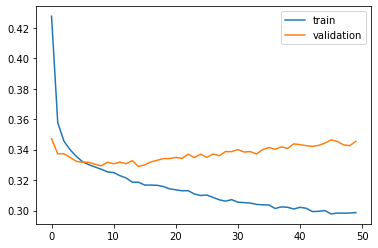

#################################
Number of units: 16
Batch size: 128
Fold: 3
best val loss: 0.3289028340891788
#################################
Time to train MLP:  167.89631509780884
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 69s - loss: 0.4257 - acc: 0.8258 - val_loss: 0.3500 - val_acc: 0.8584

Epoch 00001: val_loss improved from inf to 0.35005, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3576 - acc: 0.8627 - val_loss: 0.3405 - val_acc: 0.8623

Epoch 00002: val_loss improved from 0.35005 to 0.34053, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3457 - acc: 0.8659 - val_loss: 0.3394 - val_acc: 0.8623

Epoch 00003: val_loss improved from 0.34053 to 0.33938, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3405 - acc: 0.8683 - val_loss: 0.3373 - val_acc: 0.8636

Epoch 00004: val_loss improved from 0.33938 to 0.33728, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3358 - acc: 0.8693 - val_loss: 0.3

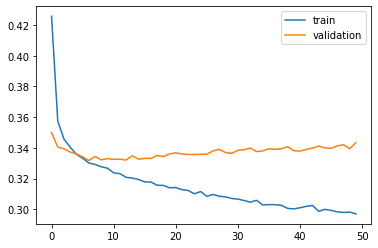

#################################
Number of units: 16
Batch size: 128
Fold: 4
best val loss: 0.33177631551062153
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.


Epoch 00036: val_loss did not improve from 0.33020
Epoch 37/50
 - 2s - loss: 0.3025 - acc: 0.8803 - val_loss: 0.3440 - val_acc: 0.8682

Epoch 00037: val_loss did not improve from 0.33020
Epoch 38/50
 - 2s - loss: 0.3040 - acc: 0.8794 - val_loss: 0.3423 - val_acc: 0.8684

Epoch 00038: val_loss did not improve from 0.33020
Epoch 39/50
 - 2s - loss: 0.3012 - acc: 0.8806 - val_loss: 0.3423 - val_acc: 0.8676

Epoch 00039: val_loss did not improve from 0.33020
Epoch 40/50
 - 2s - loss: 0.3024 - acc: 0.8801 - val_loss: 0.3427 - val_acc: 0.8697

Epoch 00040: val_loss did not improve from 0.33020
Epoch 41/50
 - 2s - loss: 0.3010 - acc: 0.8816 - val_loss: 0.3431 - val_acc: 0.8688

Epoch 00041: val_loss did not improve from 0.33020
Epoch 42/50
 - 2s - loss: 0.3011 - acc: 0.8802 - val_loss: 0.3420 - val_acc: 0.8688

Epoch 00042: val_loss did not improve from 0.33020
Epoch 43/50
 - 2s - loss: 0.3013 - acc: 0.8818 - val_loss: 0.3426 - val_acc: 0.8677

Epoch 00043: val_loss did not improve from 0.33

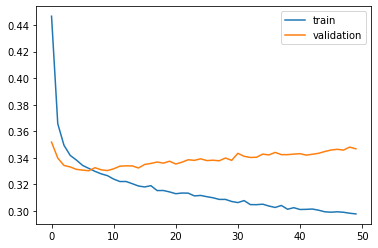

#################################
Number of units: 16
Batch size: 256
Fold: 0
best val loss: 0.330196454803846
#################################
Time to train MLP:  111.51249742507935
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 25s - loss: 0.4488 - acc: 0.8110 - val_loss: 0.3442 - val_acc: 0.8618

Epoch 00001: val_loss improved from inf to 0.34421, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3640 - acc: 0.8591 - val_loss: 0.3356 - val_acc: 0.8655

Epoch 00002: val_loss improved from 0.34421 to 0.33559, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3485 - acc: 0.8650 - val_loss: 0.3299 - val_acc: 0.8703

Epoch 00003: val_loss improved from 0.33559 to 0.32989, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3425 - acc: 0.8677 - val_loss: 0.3299 - val_acc: 0.8675

Epoch 00004: val_loss did not improve from 0.32989
Epoch 5/50
 - 2s - loss: 0.3375 - acc: 0.8689 - val_loss: 0.3316 - val_acc: 0.8671

Epoch 00005: val_los

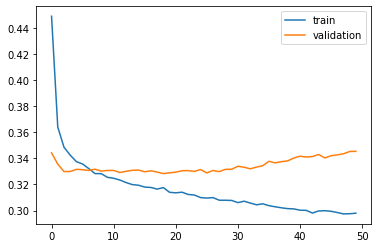

#################################
Number of units: 16
Batch size: 256
Fold: 1
best val loss: 0.3283192617293687
#################################
Time to train MLP:  116.48844718933105
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 28s - loss: 0.4443 - acc: 0.8112 - val_loss: 0.3529 - val_acc: 0.8559

Epoch 00001: val_loss improved from inf to 0.35293, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3640 - acc: 0.8590 - val_loss: 0.3443 - val_acc: 0.8616

Epoch 00002: val_loss improved from 0.35293 to 0.34433, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3485 - acc: 0.8661 - val_loss: 0.3386 - val_acc: 0.8630

Epoch 00003: val_loss improved from 0.34433 to 0.33858, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3408 - acc: 0.8677 - val_loss: 0.3349 - val_acc: 0.8661

Epoch 00004: val_loss improved from 0.33858 to 0.33487, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3373 - acc: 0.8690 - val_loss: 0.3

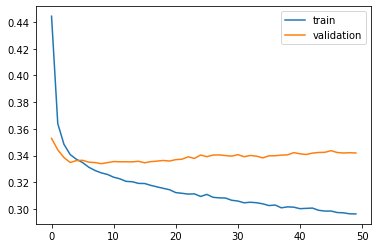

#################################
Number of units: 16
Batch size: 256
Fold: 2
best val loss: 0.33399633233658754
#################################
Time to train MLP:  119.63978743553162
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4488 - acc: 0.8112 - val_loss: 0.3517 - val_acc: 0.8591

Epoch 00001: val_loss improved from inf to 0.35165, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3661 - acc: 0.8597 - val_loss: 0.3380 - val_acc: 0.8654

Epoch 00002: val_loss improved from 0.35165 to 0.33804, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3496 - acc: 0.8640 - val_loss: 0.3365 - val_acc: 0.8664

Epoch 00003: val_loss improved from 0.33804 to 0.33654, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3417 - acc: 0.8667 - val_loss: 0.3348 - val_acc: 0.8681

Epoch 00004: val_loss improved from 0.33654 to 0.33485, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3374 - acc: 0.8687 - val_loss: 0.

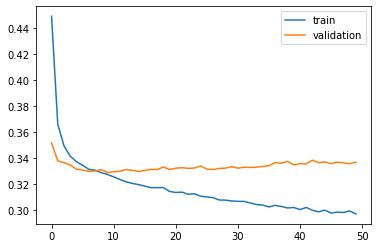

#################################
Number of units: 16
Batch size: 256
Fold: 3
best val loss: 0.329102048957557
#################################
Time to train MLP:  115.07215309143066
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 23s - loss: 0.4488 - acc: 0.8118 - val_loss: 0.3553 - val_acc: 0.8559

Epoch 00001: val_loss improved from inf to 0.35527, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3650 - acc: 0.8591 - val_loss: 0.3424 - val_acc: 0.8618

Epoch 00002: val_loss improved from 0.35527 to 0.34242, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3492 - acc: 0.8645 - val_loss: 0.3398 - val_acc: 0.8594

Epoch 00003: val_loss improved from 0.34242 to 0.33977, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3425 - acc: 0.8680 - val_loss: 0.3393 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.33977 to 0.33926, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3359 - acc: 0.8691 - val_loss: 0.33

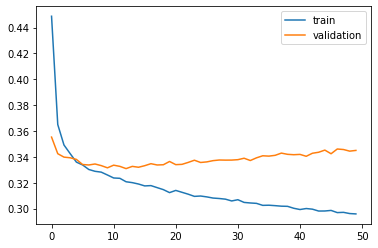

#################################
Number of units: 16
Batch size: 256
Fold: 4
best val loss: 0.33088360762038427
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.


Epoch 00035: val_loss did not improve from 0.32993
Epoch 36/50
 - 1s - loss: 0.3032 - acc: 0.8798 - val_loss: 0.3403 - val_acc: 0.8681

Epoch 00036: val_loss did not improve from 0.32993
Epoch 37/50
 - 1s - loss: 0.3027 - acc: 0.8797 - val_loss: 0.3405 - val_acc: 0.8680

Epoch 00037: val_loss did not improve from 0.32993
Epoch 38/50
 - 1s - loss: 0.3033 - acc: 0.8789 - val_loss: 0.3394 - val_acc: 0.8692

Epoch 00038: val_loss did not improve from 0.32993
Epoch 39/50
 - 1s - loss: 0.3026 - acc: 0.8794 - val_loss: 0.3403 - val_acc: 0.8683

Epoch 00039: val_loss did not improve from 0.32993
Epoch 40/50
 - 1s - loss: 0.3030 - acc: 0.8798 - val_loss: 0.3402 - val_acc: 0.8674

Epoch 00040: val_loss did not improve from 0.32993
Epoch 41/50
 - 1s - loss: 0.3024 - acc: 0.8800 - val_loss: 0.3408 - val_acc: 0.8675

Epoch 00041: val_loss did not improve from 0.32993
Epoch 42/50
 - 1s - loss: 0.3021 - acc: 0.8802 - val_loss: 0.3396 - val_acc: 0.8678

Epoch 00042: val_loss did not improve from 0.32

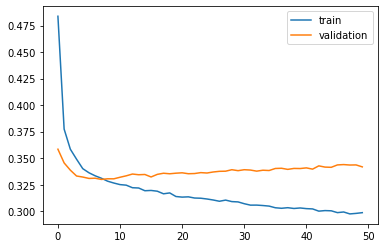

#################################
Number of units: 16
Batch size: 512
Fold: 0
best val loss: 0.32992821349735146
#################################
Time to train MLP:  81.28789687156677
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4824 - acc: 0.7852 - val_loss: 0.3590 - val_acc: 0.8549

Epoch 00001: val_loss improved from inf to 0.35898, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3787 - acc: 0.8526 - val_loss: 0.3410 - val_acc: 0.8628

Epoch 00002: val_loss improved from 0.35898 to 0.34102, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3575 - acc: 0.8614 - val_loss: 0.3353 - val_acc: 0.8637

Epoch 00003: val_loss improved from 0.34102 to 0.33527, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3485 - acc: 0.8658 - val_loss: 0.3342 - val_acc: 0.8661

Epoch 00004: val_loss improved from 0.33527 to 0.33418, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3403 - acc: 0.8668 - val_loss: 0.3

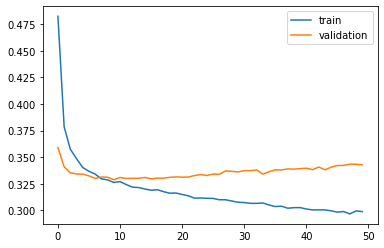

#################################
Number of units: 16
Batch size: 512
Fold: 1
best val loss: 0.3287671861523076
#################################
Time to train MLP:  83.51737117767334
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4829 - acc: 0.7861 - val_loss: 0.3657 - val_acc: 0.8526

Epoch 00001: val_loss improved from inf to 0.36575, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3770 - acc: 0.8552 - val_loss: 0.3495 - val_acc: 0.8575

Epoch 00002: val_loss improved from 0.36575 to 0.34951, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3577 - acc: 0.8635 - val_loss: 0.3420 - val_acc: 0.8622

Epoch 00003: val_loss improved from 0.34951 to 0.34205, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3473 - acc: 0.8663 - val_loss: 0.3419 - val_acc: 0.8623

Epoch 00004: val_loss improved from 0.34205 to 0.34186, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3407 - acc: 0.8677 - val_loss: 0.33

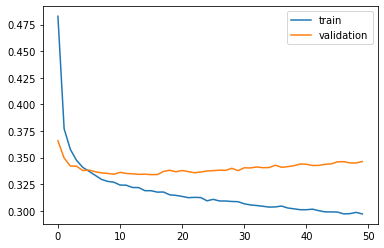

#################################
Number of units: 16
Batch size: 512
Fold: 2
best val loss: 0.33391421566929735
#################################
Time to train MLP:  85.0096960067749
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4826 - acc: 0.7868 - val_loss: 0.3622 - val_acc: 0.8546

Epoch 00001: val_loss improved from inf to 0.36224, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3775 - acc: 0.8551 - val_loss: 0.3440 - val_acc: 0.8613

Epoch 00002: val_loss improved from 0.36224 to 0.34395, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3567 - acc: 0.8621 - val_loss: 0.3399 - val_acc: 0.8642

Epoch 00003: val_loss improved from 0.34395 to 0.33987, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3474 - acc: 0.8657 - val_loss: 0.3346 - val_acc: 0.8661

Epoch 00004: val_loss improved from 0.33987 to 0.33462, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3434 - acc: 0.8672 - val_loss: 0.33

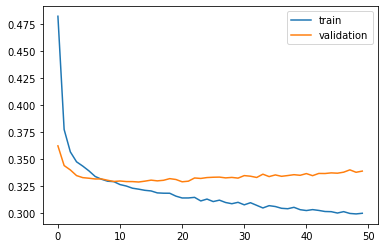

#################################
Number of units: 16
Batch size: 512
Fold: 3
best val loss: 0.3286702935667763
#################################
Time to train MLP:  89.49079132080078
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 23s - loss: 0.4825 - acc: 0.7842 - val_loss: 0.3634 - val_acc: 0.8542

Epoch 00001: val_loss improved from inf to 0.36343, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3777 - acc: 0.8542 - val_loss: 0.3509 - val_acc: 0.8566

Epoch 00002: val_loss improved from 0.36343 to 0.35087, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3587 - acc: 0.8628 - val_loss: 0.3432 - val_acc: 0.8614

Epoch 00003: val_loss improved from 0.35087 to 0.34318, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3489 - acc: 0.8651 - val_loss: 0.3405 - val_acc: 0.8606

Epoch 00004: val_loss improved from 0.34318 to 0.34055, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3403 - acc: 0.8670 - val_loss: 0.33

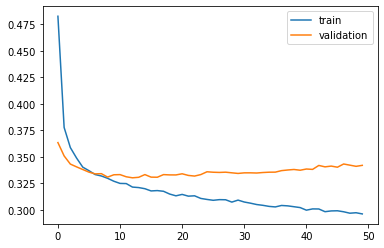

#################################
Number of units: 16
Batch size: 512
Fold: 4
best val loss: 0.3302383265788095
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3


Epoch 00033: val_loss did not improve from 0.32794
Epoch 34/50
 - 1s - loss: 0.3069 - acc: 0.8794 - val_loss: 0.3362 - val_acc: 0.8673

Epoch 00034: val_loss did not improve from 0.32794
Epoch 35/50
 - 1s - loss: 0.3082 - acc: 0.8782 - val_loss: 0.3371 - val_acc: 0.8688

Epoch 00035: val_loss did not improve from 0.32794
Epoch 36/50
 - 1s - loss: 0.3062 - acc: 0.8794 - val_loss: 0.3359 - val_acc: 0.8695

Epoch 00036: val_loss did not improve from 0.32794
Epoch 37/50
 - 1s - loss: 0.3067 - acc: 0.8781 - val_loss: 0.3361 - val_acc: 0.8667

Epoch 00037: val_loss did not improve from 0.32794
Epoch 38/50
 - 1s - loss: 0.3064 - acc: 0.8784 - val_loss: 0.3376 - val_acc: 0.8699

Epoch 00038: val_loss did not improve from 0.32794
Epoch 39/50
 - 1s - loss: 0.3052 - acc: 0.8778 - val_loss: 0.3363 - val_acc: 0.8680

Epoch 00039: val_loss did not improve from 0.32794
Epoch 40/50
 - 1s - loss: 0.3047 - acc: 0.8787 - val_loss: 0.3365 - val_acc: 0.8683

Epoch 00040: val_loss did not improve from 0.32

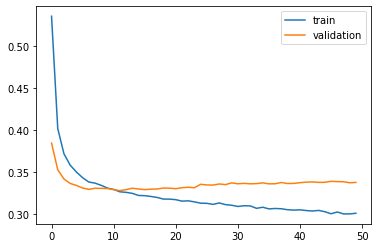

#################################
Number of units: 16
Batch size: 1024
Fold: 0
best val loss: 0.32793641987599825
#################################
Time to train MLP:  64.73312044143677
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 24s - loss: 0.5327 - acc: 0.7466 - val_loss: 0.3857 - val_acc: 0.8434

Epoch 00001: val_loss improved from inf to 0.38572, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4040 - acc: 0.8418 - val_loss: 0.3490 - val_acc: 0.8578

Epoch 00002: val_loss improved from 0.38572 to 0.34905, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3729 - acc: 0.8552 - val_loss: 0.3382 - val_acc: 0.8630

Epoch 00003: val_loss improved from 0.34905 to 0.33818, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3581 - acc: 0.8620 - val_loss: 0.3351 - val_acc: 0.8640

Epoch 00004: val_loss improved from 0.33818 to 0.33507, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3481 - acc: 0.8647 - val_loss: 0.

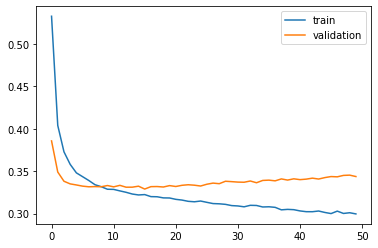

#################################
Number of units: 16
Batch size: 1024
Fold: 1
best val loss: 0.3289820458735639
#################################
Time to train MLP:  68.13582134246826
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.5332 - acc: 0.7460 - val_loss: 0.3940 - val_acc: 0.8413

Epoch 00001: val_loss improved from inf to 0.39398, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.4007 - acc: 0.8443 - val_loss: 0.3576 - val_acc: 0.8552

Epoch 00002: val_loss improved from 0.39398 to 0.35765, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3707 - acc: 0.8581 - val_loss: 0.3481 - val_acc: 0.8578

Epoch 00003: val_loss improved from 0.35765 to 0.34807, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3555 - acc: 0.8633 - val_loss: 0.3444 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.34807 to 0.34437, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3467 - acc: 0.8654 - val_loss: 0.3

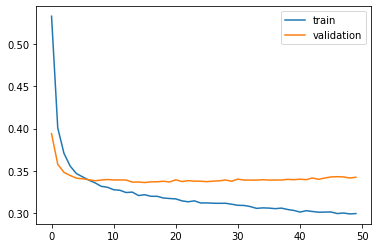

#################################
Number of units: 16
Batch size: 1024
Fold: 2
best val loss: 0.3359924804885485
#################################
Time to train MLP:  69.78346872329712
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 24s - loss: 0.5301 - acc: 0.7465 - val_loss: 0.3894 - val_acc: 0.8448

Epoch 00001: val_loss improved from inf to 0.38941, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3989 - acc: 0.8440 - val_loss: 0.3532 - val_acc: 0.8571

Epoch 00002: val_loss improved from 0.38941 to 0.35322, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3717 - acc: 0.8563 - val_loss: 0.3457 - val_acc: 0.8623

Epoch 00003: val_loss improved from 0.35322 to 0.34568, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3563 - acc: 0.8625 - val_loss: 0.3395 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.34568 to 0.33954, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3510 - acc: 0.8641 - val_loss: 0.3

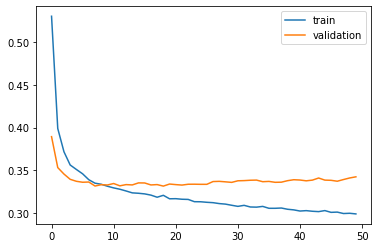

#################################
Number of units: 16
Batch size: 1024
Fold: 3
best val loss: 0.33159886178217435
#################################
Time to train MLP:  66.69372177124023
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 25s - loss: 0.5334 - acc: 0.7431 - val_loss: 0.3923 - val_acc: 0.8416

Epoch 00001: val_loss improved from inf to 0.39228, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3996 - acc: 0.8426 - val_loss: 0.3596 - val_acc: 0.8545

Epoch 00002: val_loss improved from 0.39228 to 0.35961, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3722 - acc: 0.8567 - val_loss: 0.3496 - val_acc: 0.8561

Epoch 00003: val_loss improved from 0.35961 to 0.34961, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3586 - acc: 0.8623 - val_loss: 0.3440 - val_acc: 0.8615

Epoch 00004: val_loss improved from 0.34961 to 0.34401, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3499 - acc: 0.8646 - val_loss: 0.

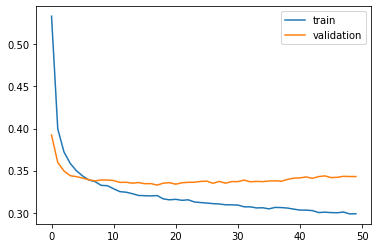

#################################
Number of units: 16
Batch size: 1024
Fold: 4
best val loss: 0.33280106957892924
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0


Epoch 00033: val_loss did not improve from 0.33208
Epoch 34/50
 - 5s - loss: 0.2834 - acc: 0.8873 - val_loss: 0.3554 - val_acc: 0.8605

Epoch 00034: val_loss did not improve from 0.33208
Epoch 35/50
 - 5s - loss: 0.2835 - acc: 0.8885 - val_loss: 0.3580 - val_acc: 0.8604

Epoch 00035: val_loss did not improve from 0.33208
Epoch 36/50
 - 5s - loss: 0.2826 - acc: 0.8884 - val_loss: 0.3599 - val_acc: 0.8586

Epoch 00036: val_loss did not improve from 0.33208
Epoch 37/50
 - 5s - loss: 0.2816 - acc: 0.8882 - val_loss: 0.3635 - val_acc: 0.8601

Epoch 00037: val_loss did not improve from 0.33208
Epoch 38/50
 - 5s - loss: 0.2813 - acc: 0.8894 - val_loss: 0.3600 - val_acc: 0.8602

Epoch 00038: val_loss did not improve from 0.33208
Epoch 39/50
 - 5s - loss: 0.2805 - acc: 0.8895 - val_loss: 0.3614 - val_acc: 0.8595

Epoch 00039: val_loss did not improve from 0.33208
Epoch 40/50
 - 5s - loss: 0.2804 - acc: 0.8896 - val_loss: 0.3588 - val_acc: 0.8602

Epoch 00040: val_loss did not improve from 0.33

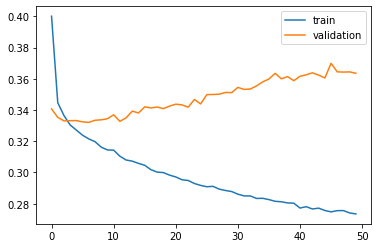

#################################
Number of units: 32
Batch size: 64
Fold: 0
best val loss: 0.33207720440730715
#################################
Time to train MLP:  288.1840133666992
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 39s - loss: 0.3986 - acc: 0.8430 - val_loss: 0.3414 - val_acc: 0.8642

Epoch 00001: val_loss improved from inf to 0.34138, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3441 - acc: 0.8652 - val_loss: 0.3337 - val_acc: 0.8667

Epoch 00002: val_loss improved from 0.34138 to 0.33374, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3342 - acc: 0.8685 - val_loss: 0.3320 - val_acc: 0.8674

Epoch 00003: val_loss improved from 0.33374 to 0.33195, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3313 - acc: 0.8702 - val_loss: 0.3329 - val_acc: 0.8681

Epoch 00004: val_loss did not improve from 0.33195
Epoch 5/50
 - 5s - loss: 0.3281 - acc: 0.8703 - val_loss: 0.3322 - val_acc: 0.8685

Epoch 00005: val_los

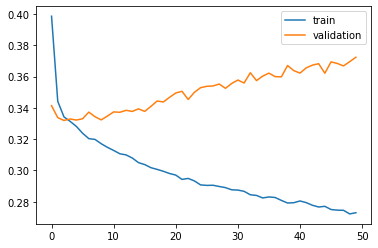

#################################
Number of units: 32
Batch size: 64
Fold: 1
best val loss: 0.3319536462304188
#################################
Time to train MLP:  297.9999361038208
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 34s - loss: 0.3972 - acc: 0.8437 - val_loss: 0.3462 - val_acc: 0.8607

Epoch 00001: val_loss improved from inf to 0.34624, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3428 - acc: 0.8654 - val_loss: 0.3358 - val_acc: 0.8629

Epoch 00002: val_loss improved from 0.34624 to 0.33580, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3343 - acc: 0.8686 - val_loss: 0.3366 - val_acc: 0.8630

Epoch 00003: val_loss did not improve from 0.33580
Epoch 4/50
 - 5s - loss: 0.3291 - acc: 0.8710 - val_loss: 0.3360 - val_acc: 0.8629

Epoch 00004: val_loss did not improve from 0.33580
Epoch 5/50
 - 5s - loss: 0.3266 - acc: 0.8710 - val_loss: 0.3370 - val_acc: 0.8612

Epoch 00005: val_loss did not improve from 0.33580
Epoch 6/50
 

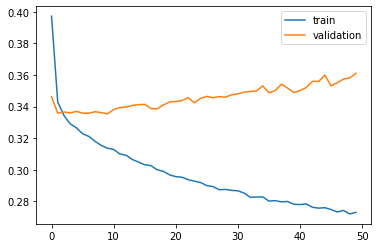

#################################
Number of units: 32
Batch size: 64
Fold: 2
best val loss: 0.33538044194729005
#################################
Time to train MLP:  296.18430733680725
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 70s - loss: 0.3985 - acc: 0.8432 - val_loss: 0.3437 - val_acc: 0.8658

Epoch 00001: val_loss improved from inf to 0.34372, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3444 - acc: 0.8655 - val_loss: 0.3357 - val_acc: 0.8687

Epoch 00002: val_loss improved from 0.34372 to 0.33566, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3357 - acc: 0.8686 - val_loss: 0.3347 - val_acc: 0.8698

Epoch 00003: val_loss improved from 0.33566 to 0.33471, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3292 - acc: 0.8703 - val_loss: 0.3342 - val_acc: 0.8712

Epoch 00004: val_loss improved from 0.33471 to 0.33417, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3268 - acc: 0.8711 - val_loss: 0.3

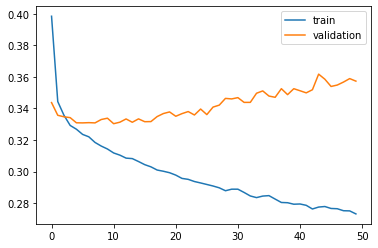

#################################
Number of units: 32
Batch size: 64
Fold: 3
best val loss: 0.330328071528708
#################################
Time to train MLP:  332.2159686088562
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 54s - loss: 0.3973 - acc: 0.8431 - val_loss: 0.3483 - val_acc: 0.8593

Epoch 00001: val_loss improved from inf to 0.34829, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3446 - acc: 0.8651 - val_loss: 0.3404 - val_acc: 0.8602

Epoch 00002: val_loss improved from 0.34829 to 0.34044, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3337 - acc: 0.8699 - val_loss: 0.3393 - val_acc: 0.8611

Epoch 00003: val_loss improved from 0.34044 to 0.33933, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3298 - acc: 0.8707 - val_loss: 0.3403 - val_acc: 0.8630

Epoch 00004: val_loss did not improve from 0.33933
Epoch 5/50
 - 5s - loss: 0.3262 - acc: 0.8720 - val_loss: 0.3389 - val_acc: 0.8621

Epoch 00005: val_loss 

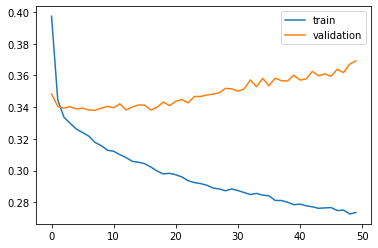

#################################
Number of units: 32
Batch size: 64
Fold: 4
best val loss: 0.33808212985072217
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3

 - 3s - loss: 0.2842 - acc: 0.8871 - val_loss: 0.3477 - val_acc: 0.8598

Epoch 00033: val_loss did not improve from 0.33343
Epoch 34/50
 - 3s - loss: 0.2829 - acc: 0.8873 - val_loss: 0.3485 - val_acc: 0.8618

Epoch 00034: val_loss did not improve from 0.33343
Epoch 35/50
 - 3s - loss: 0.2828 - acc: 0.8881 - val_loss: 0.3493 - val_acc: 0.8622

Epoch 00035: val_loss did not improve from 0.33343
Epoch 36/50
 - 3s - loss: 0.2817 - acc: 0.8881 - val_loss: 0.3460 - val_acc: 0.8627

Epoch 00036: val_loss did not improve from 0.33343
Epoch 37/50
 - 3s - loss: 0.2817 - acc: 0.8883 - val_loss: 0.3511 - val_acc: 0.8615

Epoch 00037: val_loss did not improve from 0.33343
Epoch 38/50
 - 3s - loss: 0.2801 - acc: 0.8886 - val_loss: 0.3519 - val_acc: 0.8627

Epoch 00038: val_loss did not improve from 0.33343
Epoch 39/50
 - 3s - loss: 0.2801 - acc: 0.8885 - val_loss: 0.3510 - val_acc: 0.8619

Epoch 00039: val_loss did not improve from 0.33343
Epoch 40/50
 - 3s - loss: 0.2791 - acc: 0.8893 - val_loss: 0

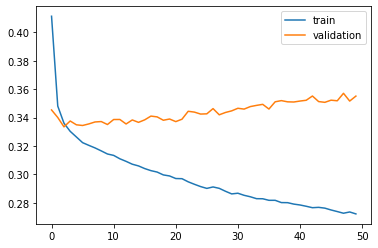

#################################
Number of units: 32
Batch size: 128
Fold: 0
best val loss: 0.33342662733897827
#################################
Time to train MLP:  221.53998398780823
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 39s - loss: 0.4118 - acc: 0.8351 - val_loss: 0.3394 - val_acc: 0.8646

Epoch 00001: val_loss improved from inf to 0.33943, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3492 - acc: 0.8637 - val_loss: 0.3340 - val_acc: 0.8684

Epoch 00002: val_loss improved from 0.33943 to 0.33400, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3369 - acc: 0.8676 - val_loss: 0.3322 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.33400 to 0.33223, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3310 - acc: 0.8697 - val_loss: 0.3301 - val_acc: 0.8681

Epoch 00004: val_loss improved from 0.33223 to 0.33014, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3272 - acc: 0.8717 - val_loss: 0.

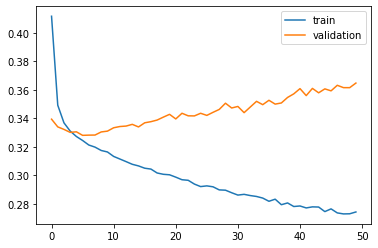

#################################
Number of units: 32
Batch size: 128
Fold: 1
best val loss: 0.32805033778586584
#################################
Time to train MLP:  201.5987310409546
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 55s - loss: 0.4092 - acc: 0.8368 - val_loss: 0.3492 - val_acc: 0.8582

Epoch 00001: val_loss improved from inf to 0.34923, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3490 - acc: 0.8637 - val_loss: 0.3396 - val_acc: 0.8620

Epoch 00002: val_loss improved from 0.34923 to 0.33962, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3360 - acc: 0.8689 - val_loss: 0.3391 - val_acc: 0.8629

Epoch 00003: val_loss improved from 0.33962 to 0.33908, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3297 - acc: 0.8708 - val_loss: 0.3366 - val_acc: 0.8643

Epoch 00004: val_loss improved from 0.33908 to 0.33657, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3248 - acc: 0.8719 - val_loss: 0.3

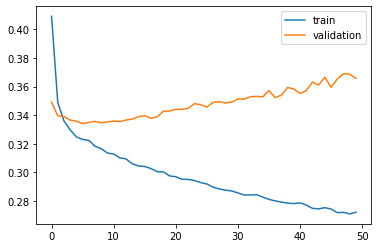

#################################
Number of units: 32
Batch size: 128
Fold: 2
best val loss: 0.33412465655664253
#################################
Time to train MLP:  217.85196733474731
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 32s - loss: 0.4098 - acc: 0.8360 - val_loss: 0.3467 - val_acc: 0.8650

Epoch 00001: val_loss improved from inf to 0.34669, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3482 - acc: 0.8644 - val_loss: 0.3381 - val_acc: 0.8690

Epoch 00002: val_loss improved from 0.34669 to 0.33810, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3358 - acc: 0.8682 - val_loss: 0.3345 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.33810 to 0.33448, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3279 - acc: 0.8701 - val_loss: 0.3367 - val_acc: 0.8687

Epoch 00004: val_loss did not improve from 0.33448
Epoch 5/50
 - 3s - loss: 0.3266 - acc: 0.8719 - val_loss: 0.3335 - val_acc: 0.8699

Epoch 00005: val_l

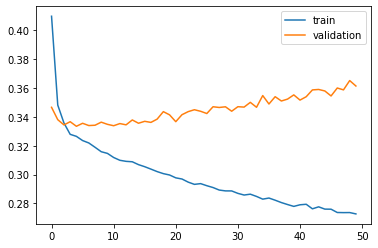

#################################
Number of units: 32
Batch size: 128
Fold: 3
best val loss: 0.3335289220851764
#################################
Time to train MLP:  196.4336175918579
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 68s - loss: 0.4105 - acc: 0.8366 - val_loss: 0.3481 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.34814, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3466 - acc: 0.8653 - val_loss: 0.3406 - val_acc: 0.8602

Epoch 00002: val_loss improved from 0.34814 to 0.34062, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3346 - acc: 0.8695 - val_loss: 0.3376 - val_acc: 0.8612

Epoch 00003: val_loss improved from 0.34062 to 0.33759, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3308 - acc: 0.8704 - val_loss: 0.3367 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.33759 to 0.33666, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3255 - acc: 0.8713 - val_loss: 0.33

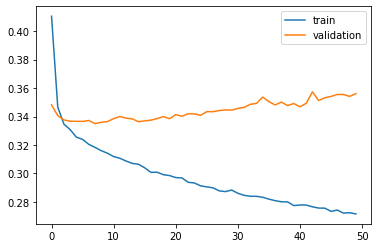

#################################
Number of units: 32
Batch size: 128
Fold: 4
best val loss: 0.33498885980823584
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.


Epoch 00030: val_loss did not improve from 0.33042
Epoch 31/50
 - 2s - loss: 0.2861 - acc: 0.8861 - val_loss: 0.3460 - val_acc: 0.8633

Epoch 00031: val_loss did not improve from 0.33042
Epoch 32/50
 - 2s - loss: 0.2866 - acc: 0.8854 - val_loss: 0.3453 - val_acc: 0.8657

Epoch 00032: val_loss did not improve from 0.33042
Epoch 33/50
 - 2s - loss: 0.2852 - acc: 0.8862 - val_loss: 0.3466 - val_acc: 0.8628

Epoch 00033: val_loss did not improve from 0.33042
Epoch 34/50
 - 2s - loss: 0.2841 - acc: 0.8866 - val_loss: 0.3485 - val_acc: 0.8625

Epoch 00034: val_loss did not improve from 0.33042
Epoch 35/50
 - 2s - loss: 0.2841 - acc: 0.8862 - val_loss: 0.3454 - val_acc: 0.8613

Epoch 00035: val_loss did not improve from 0.33042
Epoch 36/50
 - 2s - loss: 0.2838 - acc: 0.8872 - val_loss: 0.3471 - val_acc: 0.8642

Epoch 00036: val_loss did not improve from 0.33042
Epoch 37/50
 - 2s - loss: 0.2831 - acc: 0.8874 - val_loss: 0.3487 - val_acc: 0.8626

Epoch 00037: val_loss did not improve from 0.33

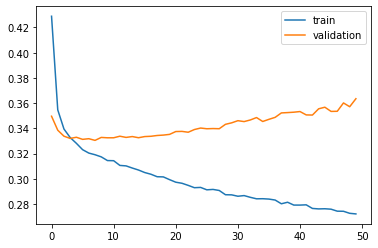

#################################
Number of units: 32
Batch size: 256
Fold: 0
best val loss: 0.330415513459702
#################################
Time to train MLP:  144.3978979587555
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 43s - loss: 0.4300 - acc: 0.8234 - val_loss: 0.3443 - val_acc: 0.8623

Epoch 00001: val_loss improved from inf to 0.34432, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3528 - acc: 0.8617 - val_loss: 0.3362 - val_acc: 0.8660

Epoch 00002: val_loss improved from 0.34432 to 0.33615, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3395 - acc: 0.8665 - val_loss: 0.3316 - val_acc: 0.8690

Epoch 00003: val_loss improved from 0.33615 to 0.33157, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3325 - acc: 0.8696 - val_loss: 0.3303 - val_acc: 0.8698

Epoch 00004: val_loss improved from 0.33157 to 0.33034, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3268 - acc: 0.8706 - val_loss: 0.328

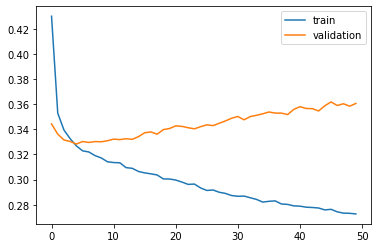

#################################
Number of units: 32
Batch size: 256
Fold: 1
best val loss: 0.32828998161338224
#################################
Time to train MLP:  146.425532579422
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 38s - loss: 0.4275 - acc: 0.8232 - val_loss: 0.3489 - val_acc: 0.8600

Epoch 00001: val_loss improved from inf to 0.34888, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3519 - acc: 0.8629 - val_loss: 0.3417 - val_acc: 0.8628

Epoch 00002: val_loss improved from 0.34888 to 0.34167, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3394 - acc: 0.8671 - val_loss: 0.3391 - val_acc: 0.8623

Epoch 00003: val_loss improved from 0.34167 to 0.33909, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3309 - acc: 0.8706 - val_loss: 0.3380 - val_acc: 0.8640

Epoch 00004: val_loss improved from 0.33909 to 0.33799, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3263 - acc: 0.8718 - val_loss: 0.33

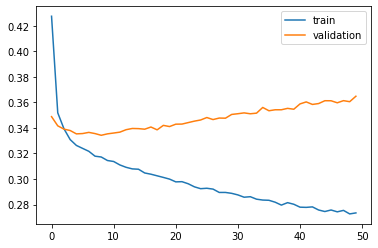

#################################
Number of units: 32
Batch size: 256
Fold: 2
best val loss: 0.33426344069123964
#################################
Time to train MLP:  141.9665083885193
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 43s - loss: 0.4294 - acc: 0.8235 - val_loss: 0.3485 - val_acc: 0.8627

Epoch 00001: val_loss improved from inf to 0.34854, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3548 - acc: 0.8625 - val_loss: 0.3389 - val_acc: 0.8657

Epoch 00002: val_loss improved from 0.34854 to 0.33888, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3398 - acc: 0.8667 - val_loss: 0.3348 - val_acc: 0.8675

Epoch 00003: val_loss improved from 0.33888 to 0.33476, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3307 - acc: 0.8699 - val_loss: 0.3350 - val_acc: 0.8682

Epoch 00004: val_loss did not improve from 0.33476
Epoch 5/50
 - 2s - loss: 0.3273 - acc: 0.8716 - val_loss: 0.3334 - val_acc: 0.8691

Epoch 00005: val_lo

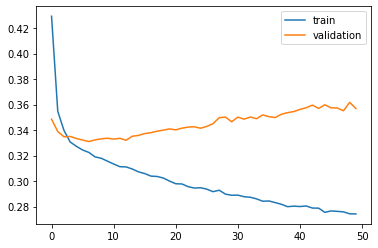

#################################
Number of units: 32
Batch size: 256
Fold: 3
best val loss: 0.3310198726152119
#################################
Time to train MLP:  148.39394807815552
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 44s - loss: 0.4290 - acc: 0.8253 - val_loss: 0.3531 - val_acc: 0.8571

Epoch 00001: val_loss improved from inf to 0.35310, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3518 - acc: 0.8637 - val_loss: 0.3450 - val_acc: 0.8586

Epoch 00002: val_loss improved from 0.35310 to 0.34503, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3394 - acc: 0.8684 - val_loss: 0.3389 - val_acc: 0.8628

Epoch 00003: val_loss improved from 0.34503 to 0.33893, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3319 - acc: 0.8704 - val_loss: 0.3390 - val_acc: 0.8618

Epoch 00004: val_loss did not improve from 0.33893
Epoch 5/50
 - 2s - loss: 0.3279 - acc: 0.8717 - val_loss: 0.3362 - val_acc: 0.8625

Epoch 00005: val_lo

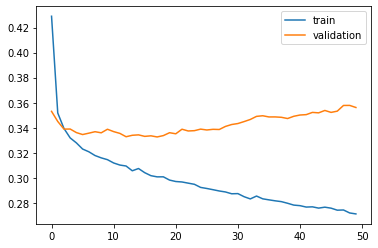

#################################
Number of units: 32
Batch size: 256
Fold: 4
best val loss: 0.3326767843369155
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3


Epoch 00029: val_loss did not improve from 0.32886
Epoch 30/50
 - 1s - loss: 0.2907 - acc: 0.8839 - val_loss: 0.3360 - val_acc: 0.8667

Epoch 00030: val_loss did not improve from 0.32886
Epoch 31/50
 - 1s - loss: 0.2904 - acc: 0.8839 - val_loss: 0.3374 - val_acc: 0.8674

Epoch 00031: val_loss did not improve from 0.32886
Epoch 32/50
 - 1s - loss: 0.2882 - acc: 0.8851 - val_loss: 0.3377 - val_acc: 0.8664

Epoch 00032: val_loss did not improve from 0.32886
Epoch 33/50
 - 1s - loss: 0.2878 - acc: 0.8854 - val_loss: 0.3379 - val_acc: 0.8656

Epoch 00033: val_loss did not improve from 0.32886
Epoch 34/50
 - 1s - loss: 0.2877 - acc: 0.8850 - val_loss: 0.3400 - val_acc: 0.8665

Epoch 00034: val_loss did not improve from 0.32886
Epoch 35/50
 - 1s - loss: 0.2881 - acc: 0.8848 - val_loss: 0.3405 - val_acc: 0.8640

Epoch 00035: val_loss did not improve from 0.32886
Epoch 36/50
 - 1s - loss: 0.2863 - acc: 0.8858 - val_loss: 0.3397 - val_acc: 0.8660

Epoch 00036: val_loss did not improve from 0.32

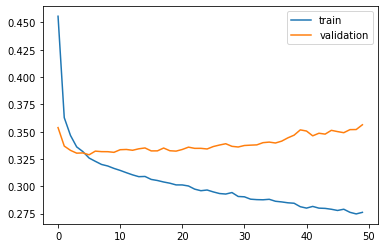

#################################
Number of units: 32
Batch size: 512
Fold: 0
best val loss: 0.32885676301013655
#################################
Time to train MLP:  101.47624921798706
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 33s - loss: 0.4580 - acc: 0.8055 - val_loss: 0.3540 - val_acc: 0.8572

Epoch 00001: val_loss improved from inf to 0.35404, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3629 - acc: 0.8582 - val_loss: 0.3406 - val_acc: 0.8637

Epoch 00002: val_loss improved from 0.35404 to 0.34055, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3459 - acc: 0.8647 - val_loss: 0.3356 - val_acc: 0.8667

Epoch 00003: val_loss improved from 0.34055 to 0.33558, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3360 - acc: 0.8686 - val_loss: 0.3342 - val_acc: 0.8658

Epoch 00004: val_loss improved from 0.33558 to 0.33416, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3306 - acc: 0.8699 - val_loss: 0.

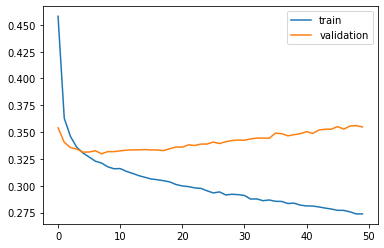

#################################
Number of units: 32
Batch size: 512
Fold: 1
best val loss: 0.32978620206403453
#################################
Time to train MLP:  99.90408039093018
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 54s - loss: 0.4562 - acc: 0.8068 - val_loss: 0.3557 - val_acc: 0.8545

Epoch 00001: val_loss improved from inf to 0.35566, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3624 - acc: 0.8585 - val_loss: 0.3418 - val_acc: 0.8596

Epoch 00002: val_loss improved from 0.35566 to 0.34182, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3454 - acc: 0.8636 - val_loss: 0.3411 - val_acc: 0.8612

Epoch 00003: val_loss improved from 0.34182 to 0.34111, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3368 - acc: 0.8682 - val_loss: 0.3389 - val_acc: 0.8605

Epoch 00004: val_loss improved from 0.34111 to 0.33894, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3282 - acc: 0.8717 - val_loss: 0.3

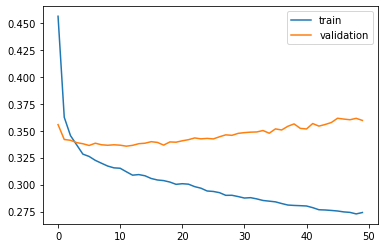

#################################
Number of units: 32
Batch size: 512
Fold: 2
best val loss: 0.3356279024673484
#################################
Time to train MLP:  121.91672587394714
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 53s - loss: 0.4556 - acc: 0.8087 - val_loss: 0.3555 - val_acc: 0.8587

Epoch 00001: val_loss improved from inf to 0.35552, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3643 - acc: 0.8584 - val_loss: 0.3419 - val_acc: 0.8620

Epoch 00002: val_loss improved from 0.35552 to 0.34192, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3456 - acc: 0.8650 - val_loss: 0.3389 - val_acc: 0.8671

Epoch 00003: val_loss improved from 0.34192 to 0.33893, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3359 - acc: 0.8683 - val_loss: 0.3349 - val_acc: 0.8689

Epoch 00004: val_loss improved from 0.33893 to 0.33485, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3301 - acc: 0.8701 - val_loss: 0.3

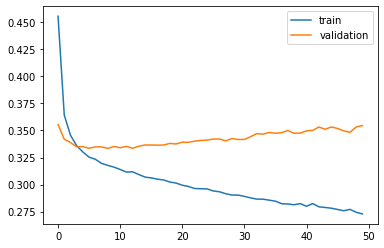

#################################
Number of units: 32
Batch size: 512
Fold: 3
best val loss: 0.3334285903325555
#################################
Time to train MLP:  119.1941990852356
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 37s - loss: 0.4572 - acc: 0.8072 - val_loss: 0.3597 - val_acc: 0.8544

Epoch 00001: val_loss improved from inf to 0.35968, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3633 - acc: 0.8582 - val_loss: 0.3471 - val_acc: 0.8575

Epoch 00002: val_loss improved from 0.35968 to 0.34713, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3465 - acc: 0.8652 - val_loss: 0.3415 - val_acc: 0.8599

Epoch 00003: val_loss improved from 0.34713 to 0.34148, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3367 - acc: 0.8682 - val_loss: 0.3389 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.34148 to 0.33893, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3296 - acc: 0.8709 - val_loss: 0.33

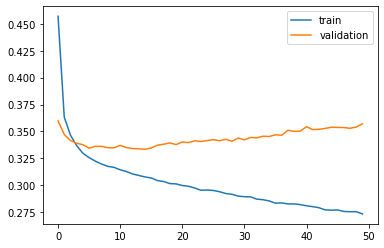

#################################
Number of units: 32
Batch size: 512
Fold: 4
best val loss: 0.3333312379756169
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.3

 - 1s - loss: 0.2955 - acc: 0.8837 - val_loss: 0.3360 - val_acc: 0.8678

Epoch 00028: val_loss did not improve from 0.33124
Epoch 29/50
 - 1s - loss: 0.2949 - acc: 0.8831 - val_loss: 0.3364 - val_acc: 0.8664

Epoch 00029: val_loss did not improve from 0.33124
Epoch 30/50
 - 1s - loss: 0.2928 - acc: 0.8841 - val_loss: 0.3374 - val_acc: 0.8660

Epoch 00030: val_loss did not improve from 0.33124
Epoch 31/50
 - 1s - loss: 0.2924 - acc: 0.8841 - val_loss: 0.3381 - val_acc: 0.8670

Epoch 00031: val_loss did not improve from 0.33124
Epoch 32/50
 - 1s - loss: 0.2908 - acc: 0.8845 - val_loss: 0.3380 - val_acc: 0.8656

Epoch 00032: val_loss did not improve from 0.33124
Epoch 33/50
 - 1s - loss: 0.2898 - acc: 0.8845 - val_loss: 0.3384 - val_acc: 0.8667

Epoch 00033: val_loss did not improve from 0.33124
Epoch 34/50
 - 1s - loss: 0.2909 - acc: 0.8850 - val_loss: 0.3406 - val_acc: 0.8650

Epoch 00034: val_loss did not improve from 0.33124
Epoch 35/50
 - 1s - loss: 0.2874 - acc: 0.8858 - val_loss: 0

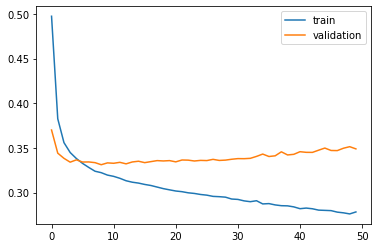

#################################
Number of units: 32
Batch size: 1024
Fold: 0
best val loss: 0.33123654912786876
#################################
Time to train MLP:  89.54498195648193
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 64s - loss: 0.5000 - acc: 0.7774 - val_loss: 0.3694 - val_acc: 0.8515

Epoch 00001: val_loss improved from inf to 0.36943, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3809 - acc: 0.8509 - val_loss: 0.3467 - val_acc: 0.8602

Epoch 00002: val_loss improved from 0.36943 to 0.34672, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3569 - acc: 0.8607 - val_loss: 0.3369 - val_acc: 0.8661

Epoch 00003: val_loss improved from 0.34672 to 0.33694, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3451 - acc: 0.8645 - val_loss: 0.3363 - val_acc: 0.8660

Epoch 00004: val_loss improved from 0.33694 to 0.33635, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3374 - acc: 0.8679 - val_loss: 0.

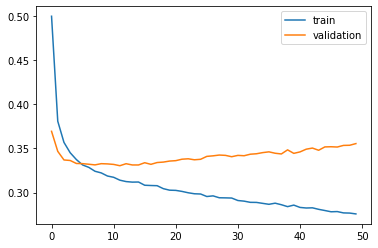

#################################
Number of units: 32
Batch size: 1024
Fold: 1
best val loss: 0.33040513922596537
#################################
Time to train MLP:  112.67748475074768
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 44s - loss: 0.4939 - acc: 0.7795 - val_loss: 0.3737 - val_acc: 0.8453

Epoch 00001: val_loss improved from inf to 0.37366, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3809 - acc: 0.8514 - val_loss: 0.3508 - val_acc: 0.8565

Epoch 00002: val_loss improved from 0.37366 to 0.35075, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3568 - acc: 0.8608 - val_loss: 0.3453 - val_acc: 0.8596

Epoch 00003: val_loss improved from 0.35075 to 0.34532, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3440 - acc: 0.8657 - val_loss: 0.3426 - val_acc: 0.8600

Epoch 00004: val_loss improved from 0.34532 to 0.34265, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3372 - acc: 0.8691 - val_loss: 0

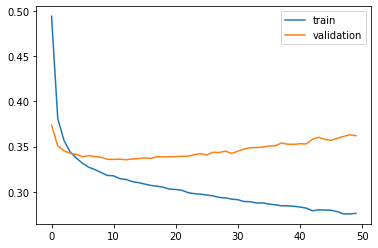

#################################
Number of units: 32
Batch size: 1024
Fold: 2
best val loss: 0.3354415922834162
#################################
Time to train MLP:  93.4370551109314
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 48s - loss: 0.4963 - acc: 0.7793 - val_loss: 0.3704 - val_acc: 0.8535

Epoch 00001: val_loss improved from inf to 0.37038, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3794 - acc: 0.8515 - val_loss: 0.3495 - val_acc: 0.8629

Epoch 00002: val_loss improved from 0.37038 to 0.34954, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3548 - acc: 0.8605 - val_loss: 0.3410 - val_acc: 0.8651

Epoch 00003: val_loss improved from 0.34954 to 0.34100, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3426 - acc: 0.8655 - val_loss: 0.3389 - val_acc: 0.8650

Epoch 00004: val_loss improved from 0.34100 to 0.33885, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3355 - acc: 0.8687 - val_loss: 0.33

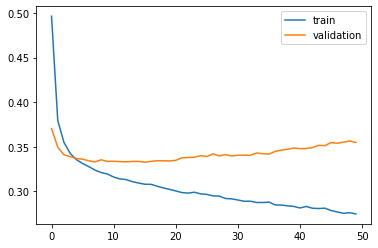

#################################
Number of units: 32
Batch size: 1024
Fold: 3
best val loss: 0.3326378148619892
#################################
Time to train MLP:  97.66684794425964
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 55s - loss: 0.4983 - acc: 0.7785 - val_loss: 0.3755 - val_acc: 0.8504

Epoch 00001: val_loss improved from inf to 0.37555, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 1s - loss: 0.3805 - acc: 0.8505 - val_loss: 0.3566 - val_acc: 0.8553

Epoch 00002: val_loss improved from 0.37555 to 0.35663, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 1s - loss: 0.3576 - acc: 0.8608 - val_loss: 0.3496 - val_acc: 0.8566

Epoch 00003: val_loss improved from 0.35663 to 0.34965, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 1s - loss: 0.3433 - acc: 0.8664 - val_loss: 0.3423 - val_acc: 0.8599

Epoch 00004: val_loss improved from 0.34965 to 0.34227, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 1s - loss: 0.3358 - acc: 0.8687 - val_loss: 0.3

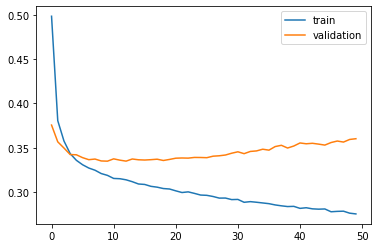

#################################
Number of units: 32
Batch size: 1024
Fold: 4
best val loss: 0.3348320814880014
#################################
[[2, 64, 0, 0.3789040412819176], [2, 64, 1, 0.37687108649845014], [2, 64, 2, 0.38371927933386196], [2, 64, 3, 0.3745232618203637], [2, 64, 4, 0.38033992089723284], [2, 128, 0, 0.37976353998072665], [2, 128, 1, 0.3773087516305042], [2, 128, 2, 0.38381051242002967], [2, 128, 3, 0.37732015612529735], [2, 128, 4, 0.38165430828841806], [2, 256, 0, 0.37918320519882337], [2, 256, 1, 0.3792138594284392], [2, 256, 2, 0.38468724450172737], [2, 256, 3, 0.3787614169525124], [2, 256, 4, 0.3818769124237417], [2, 512, 0, 0.38081676958597194], [2, 512, 1, 0.3784373574159299], [2, 512, 2, 0.3852234473284225], [2, 512, 3, 0.37912433074928864], [2, 512, 4, 0.3840542383221855], [2, 1024, 0, 0.38045362697010154], [2, 1024, 1, 0.379316124762708], [2, 1024, 2, 0.38844973953146683], [2, 1024, 3, 0.38060520439817197], [2, 1024, 4, 0.38482770297959534], [4, 64, 0, 0.

In [15]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [2, 4, 8, 16, 32]# 64, 128] #[4, 8]#[32, 64, 128, 256] # [16, 32, 64, 128, 256] [4, 8]#
batch_size_list = [64, 128, 256, 512, 1024]#, 2048] # [8192]#[4096, 8192]#[2048] #[64, 128, 256, 512, 1024]# [512, 1024]# [1024] # [64, 128, 256, 512, 1024]

start_time = time.time()

exp_record = []

for n_units in units_list:
    for b_size in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_mlp = np.append(train2_y, train1_y, axis=0)
            #######################
            seed(2)
            set_random_seed(2)
            #######################
            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = setup_model(n_units, 0.25, 0.25)
                v_loss = fit_model(model, train_x_mlp,
                                   train_y_mlp, b_size)
                print("#################################")
                print("Number of units:", n_units)
                print("Batch size:", b_size)
                print("Fold:", f)
                print("best val loss:", v_loss)
                exp_record.append([n_units, b_size, f, v_loss])
                print("#################################")
            if (f==4):
                print(exp_record)
            end_time = time.time()
            print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [16]:
#exp_record =[[2, 64, 0, 0.3805714974347611], [2, 64, 1, 0.37713635110018545], [2, 64, 2, 0.38450490257196257], [2, 64, 3, 0.37681334061232225], [2, 64, 4, 0.38180172969026177], [2, 128, 0, 0.3805551729007074], [2, 128, 1, 0.3792484081418891], [2, 128, 2, 0.38440540259344536], [2, 128, 3, 0.3793674092822605], [2, 128, 4, 0.38172311423117655], [2, 256, 0, 0.3811471602721521], [2, 256, 1, 0.3807200987785183], [2, 256, 2, 0.38637947212882906], [2, 256, 3, 0.37995443072235374], [2, 256, 4, 0.3847797769621799], [2, 512, 0, 0.3826005014690042], [2, 512, 1, 0.38004073615659745], [2, 512, 2, 0.38629926663393166], [2, 512, 3, 0.3801400065212919], [2, 512, 4, 0.38362472885533383], [2, 1024, 0, 0.3841845575480433], [2, 1024, 1, 0.38210590794769644], [2, 1024, 2, 0.38816802216552154], [2, 1024, 3, 0.38151062946570546], [2, 1024, 4, 0.384982236093945], [4, 64, 0, 0.34011102898079054], [4, 64, 1, 0.3395743321117602], [4, 64, 2, 0.3516568349746236], [4, 64, 3, 0.3399278988336262], [4, 64, 4, 0.34261419454513237], [4, 128, 0, 0.3537544405181505], [4, 128, 1, 0.3341415904767332], [4, 128, 2, 0.35810505183119523], [4, 128, 3, 0.35154313278477095], [4, 128, 4, 0.3565143811075311], [4, 256, 0, 0.3564607276205431], [4, 256, 1, 0.3520203300526268], [4, 256, 2, 0.3590199663694839], [4, 256, 3, 0.3524410439862145], [4, 256, 4, 0.3578941429219051], [4, 512, 0, 0.35787533953873035], [4, 512, 1, 0.3545308076150236], [4, 512, 2, 0.3600360746411552], [4, 512, 3, 0.35605408386180276], [4, 512, 4, 0.3608552905272322], [4, 1024, 0, 0.3610471957120282], [4, 1024, 1, 0.36177009472372934], [4, 1024, 2, 0.3670368988681258], [4, 1024, 3, 0.3609267498526657], [4, 1024, 4, 0.3638942418600384], [8, 64, 0, 0.33025825927829183], [8, 64, 1, 0.33171438438153406], [8, 64, 2, 0.33604543093700856], [8, 64, 3, 0.3330203350454743], [8, 64, 4, 0.3330786892754293], [8, 128, 0, 0.33095212851351463], [8, 128, 1, 0.3312486913538816], [8, 128, 2, 0.33604832616117264], [8, 128, 3, 0.331559532741357], [8, 128, 4, 0.33709532456091273], [8, 256, 0, 0.33036556802995026], [8, 256, 1, 0.33199291468363756], [8, 256, 2, 0.3367144622091661], [8, 256, 3, 0.3338989831759916], [8, 256, 4, 0.3345775884424734], [8, 512, 0, 0.33208770779838337], [8, 512, 1, 0.3339418989942785], [8, 512, 2, 0.3373102000094297], [8, 512, 3, 0.33349191438384923], [8, 512, 4, 0.3340728425909901], [8, 1024, 0, 0.33552348831940815], [8, 1024, 1, 0.33884003912496286], [8, 1024, 2, 0.33847057235171224], [8, 1024, 3, 0.3356817415234638], [8, 1024, 4, 0.33846600940352994], [16, 64, 0, 0.33203980123090465], [16, 64, 1, 0.33279431033552737], [16, 64, 2, 0.33608935403545], [16, 64, 3, 0.3339356991561533], [16, 64, 4, 0.33462489648172034], [16, 128, 0, 0.3322897011982767], [16, 128, 1, 0.3299702931705274], [16, 128, 2, 0.33564104176404186], [16, 128, 3, 0.3306508758193568], [16, 128, 4, 0.3350914788176442], [16, 256, 0, 0.3313474422588683], [16, 256, 1, 0.33017317977565075], [16, 256, 2, 0.337780749728108], [16, 256, 3, 0.3336062284240946], [16, 256, 4, 0.33418686833297995], [16, 512, 0, 0.33208926208535133], [16, 512, 1, 0.33082931732573706], [16, 512, 2, 0.33906442449803936], [16, 512, 3, 0.3336380563144795], [16, 512, 4, 0.3350881044697343], [16, 1024, 0, 0.33250501077077543], [16, 1024, 1, 0.33401177225057144], [16, 1024, 2, 0.3406865582480068], [16, 1024, 3, 0.335344866332952], [16, 1024, 4, 0.338693222637065], [32, 64, 0, 0.33259440238712823], [32, 64, 1, 0.33569236516952516], [32, 64, 2, 0.3379952735231634], [32, 64, 3, 0.3322841751854322], [32, 64, 4, 0.3381580731255269], [32, 128, 0, 0.3327426665080221], [32, 128, 1, 0.3327343949936984], [32, 128, 2, 0.3367693482121529], [32, 128, 3, 0.3381254015470806], [32, 128, 4, 0.33855715801841335], [32, 256, 0, 0.33102164448353283], [32, 256, 1, 0.3320383996991386], [32, 256, 2, 0.33773408303832453], [32, 256, 3, 0.33356829330237986], [32, 256, 4, 0.33511505092096605], [32, 512, 0, 0.33055235940810535], [32, 512, 1, 0.33326329008180494], [32, 512, 2, 0.3377387299523716], [32, 512, 3, 0.33441723079012153], [32, 512, 4, 0.33405784171227126], [32, 1024, 0, 0.33286815059115316], [32, 1024, 1, 0.33418371421551846], [32, 1024, 2, 0.340121157259969], [32, 1024, 3, 0.3350188407702753], [32, 1024, 4, 0.33843239363871125]]


complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(125, 4)
###############################
Units: 2.0
Batch size: 64.0
Val loss (mean): 0.37887
Val loss (std): 0.00312
###############################
###############################
Units: 2.0
Batch size: 128.0
Val loss (mean): 0.37997
Val loss (std): 0.00252
###############################
###############################
Units: 2.0
Batch size: 256.0
Val loss (mean): 0.38074
Val loss (std): 0.00226
###############################
###############################
Units: 2.0
Batch size: 512.0
Val loss (mean): 0.38153
Val loss (std): 0.00268
###############################
###############################
Units: 2.0
Batch size: 1024.0
Val loss (mean): 0.38273
Val loss (std): 0.00342
###############################
###############################
Units: 4.0
Batch size: 64.0
Val loss (mean): 0.34114
Val loss (std): 0.00684
###############################
###############################
Units: 4.0
Batch size: 128.0
Val loss (mean): 0.34607
Val loss (std): 0.0071
###############################

In [21]:
units = 32
model = setup_model(units, 0, 0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_388 (Dense)            (None, 32)                23232     
_________________________________________________________________
dropout_259 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_389 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_260 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_390 (Dense)            (None, 2)                 66        
Total params: 24,354
Trainable params: 24,354
Non-trainable params: 0
_________________________________________________________________


In [13]:
###########################
# generate random numbers
# for dropout rate
###########################
from numpy.random import seed
seed(24)
#  18 for 16 to 4
#  19 for 4 to 4
# 21 for 12 to 4
# 24 for 8 to 4
# dropout rate for 1st dropout
# layer (between 0.0 and 0.5)
dropout_rate_1_list = []
for i in range(25):
    dropout_rate_1_list.append(np.random.uniform(0.0, 0.5))
# dropout rate for 2nd dropout
# layer (between 0.0 and 0.5)
dropout_rate_2_list = []
for i in range(25):
    dropout_rate_2_list.append(np.random.uniform(0.0, 0.5))
print(min(dropout_rate_1_list))
print(max(dropout_rate_1_list))
print(min(dropout_rate_2_list))
print(max(dropout_rate_2_list))
print(dropout_rate_1_list)
print(dropout_rate_2_list)

0.06827228991176232
0.4999336463119396
0.061399241796639636
0.49772533718312456
[0.48000865166795925, 0.349756024974788, 0.4999336463119396, 0.11003364989142589, 0.180528176982029, 0.3699204951047185, 0.4982278625445485, 0.1581734888953042, 0.06827228991176232, 0.19199000507580005, 0.16025964178259655, 0.18320737654175756, 0.3548257812940637, 0.45007121526168675, 0.26705771959886027, 0.12364688245497257, 0.33590328128853764, 0.2808645536565688, 0.2712799383547549, 0.44672380184745036, 0.4213897747825215, 0.1530062949748115, 0.31558488872759777, 0.34011943022307756, 0.4852137801976603]
[0.4467835759603806, 0.4712129306803903, 0.3211127406113972, 0.3073238169210421, 0.11384162719898794, 0.24301593448318637, 0.40360964969420665, 0.4221100767611815, 0.2673404331149786, 0.37889902492722, 0.2498384430519197, 0.425163948297481, 0.3098483876780359, 0.4308070895250569, 0.11584859832450017, 0.20110920729038556, 0.31218753107994274, 0.07151835294195091, 0.061399241796639636, 0.20841495538125104, 

8550
True
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.5245 - acc: 0.7533 - val_loss: 0.3590 - val_acc: 0.8578

Epoch 00001: val_loss improved from inf to 0.35904, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4358 - acc: 0.8104 - val_loss: 0.3431 - val_acc: 0.8622

Epoch 00002: val_loss improved from 0.35904 to 0.34306, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4174 - acc: 0.8164 - val_loss: 0.3368 - val_acc: 0.8657

Epoch 00003: val_loss improved from 0.34306 to 0.33676, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4129 - acc: 0.8189 - val_loss: 0.3342 - val_acc: 0.8657

Epoch 00004: val_loss improved from 0.33676 to 0.33420, saving model to MLP_val_weights.hdf5
Ep

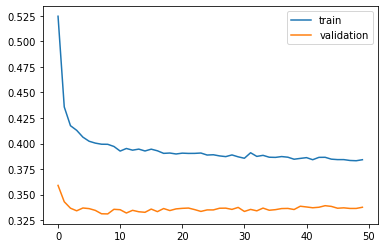

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.48000865166795925
Dropout rate 2: 0.4467835759603806
Fold: 0
Best val loss: 0.3311609453694862
#################################
Time to train MLP:  91.27370023727417
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 2s - loss: 0.5206 - acc: 0.7556 - val_loss: 0.3559 - val_acc: 0.8577

Epoch 00001: val_loss improved from inf to 0.35595, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4345 - acc: 0.8098 - val_loss: 0.3432 - val_acc: 0.8632

Epoch 00002: val_loss improved from 0.35595 to 0.34315, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4179 - acc: 0.8148 - val_loss: 0.3395 - val_acc: 0.8646

Epoch 00003: val_loss improved from 0.34315 to 0.33954, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4094 - acc: 0.8223 - val_loss: 0.3381 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.33954 to 0.33809, saving model to MLP_val_weight

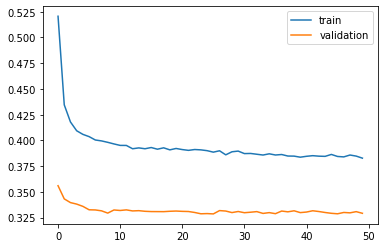

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.48000865166795925
Dropout rate 2: 0.4467835759603806
Fold: 1
Best val loss: 0.328545075390074
#################################
Time to train MLP:  91.01263618469238
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 2s - loss: 0.5263 - acc: 0.7521 - val_loss: 0.3689 - val_acc: 0.8524

Epoch 00001: val_loss improved from inf to 0.36890, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4388 - acc: 0.8070 - val_loss: 0.3528 - val_acc: 0.8579

Epoch 00002: val_loss improved from 0.36890 to 0.35282, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4175 - acc: 0.8160 - val_loss: 0.3475 - val_acc: 0.8612

Epoch 00003: val_loss improved from 0.35282 to 0.34753, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4086 - acc: 0.8236 - val_loss: 0.3418 - val_acc: 0.8625

Epoch 00004: val_loss improved from 0.34753 to 0.34178, saving model to MLP_val_weights

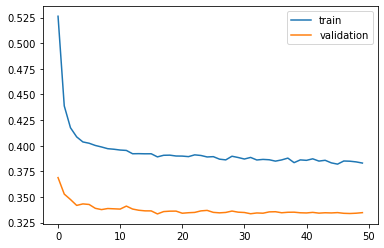

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.48000865166795925
Dropout rate 2: 0.4467835759603806
Fold: 2
Best val loss: 0.3334776935451909
#################################
Time to train MLP:  91.37324237823486
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 2s - loss: 0.5220 - acc: 0.7516 - val_loss: 0.3641 - val_acc: 0.8606

Epoch 00001: val_loss improved from inf to 0.36408, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4394 - acc: 0.7982 - val_loss: 0.3454 - val_acc: 0.8665

Epoch 00002: val_loss improved from 0.36408 to 0.34537, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4190 - acc: 0.8142 - val_loss: 0.3396 - val_acc: 0.8660

Epoch 00003: val_loss improved from 0.34537 to 0.33957, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4129 - acc: 0.8191 - val_loss: 0.3385 - val_acc: 0.8671

Epoch 00004: val_loss improved from 0.33957 to 0.33854, saving model to MLP_val_weight

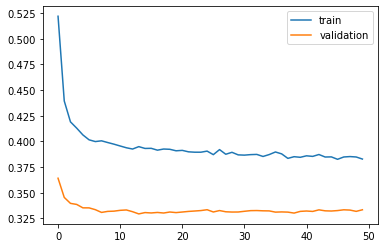

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.48000865166795925
Dropout rate 2: 0.4467835759603806
Fold: 3
Best val loss: 0.3292853852252514
#################################
Time to train MLP:  91.71485424041748
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.5273 - acc: 0.7496 - val_loss: 0.3736 - val_acc: 0.8537

Epoch 00001: val_loss improved from inf to 0.37355, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4437 - acc: 0.7919 - val_loss: 0.3552 - val_acc: 0.8600

Epoch 00002: val_loss improved from 0.37355 to 0.35523, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4252 - acc: 0.7992 - val_loss: 0.3498 - val_acc: 0.8608

Epoch 00003: val_loss improved from 0.35523 to 0.34978, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4166 - acc: 0.8043 - val_loss: 0.3481 - val_acc: 0.8612

Epoch 00004: val_loss improved from 0.34978 to 0.34808, saving model to MLP_val_weight

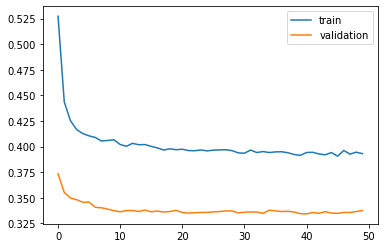

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.48000865166795925
Dropout rate 2: 0.4467835759603806
Fold: 4
Best val loss: 0.3342238294311434
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434]]
Time to train MLP:  93.07030534744263
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.4993 - acc: 0.7710 - val_loss: 0.3512 - val_acc: 0.8608

Epoch 00001: val_loss improved from inf to 0.35124, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4156 - acc: 0.8249 - val_loss: 0.3395 - val_acc: 0.8626

Epoch 00002: val_loss improved from 0.35124 to 0.33947, saving model t

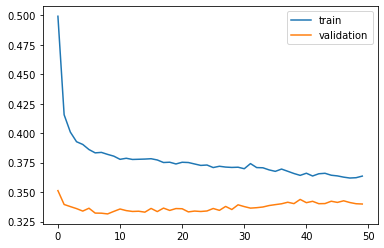

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.349756024974788
Dropout rate 2: 0.4712129306803903
Fold: 0
Best val loss: 0.3314596560266283
#################################
Time to train MLP:  93.75535988807678
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.4980 - acc: 0.7705 - val_loss: 0.3561 - val_acc: 0.8587

Epoch 00001: val_loss improved from inf to 0.35606, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4180 - acc: 0.8236 - val_loss: 0.3428 - val_acc: 0.8627

Epoch 00002: val_loss improved from 0.35606 to 0.34279, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4029 - acc: 0.8293 - val_loss: 0.3344 - val_acc: 0.8648

Epoch 00003: val_loss improved from 0.34279 to 0.33441, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3937 - acc: 0.8331 - val_loss: 0.3341 - val_acc: 0.8649

Epoch 00004: val_loss improved from 0.33441 to 0.33414, saving model to MLP_val_weights.

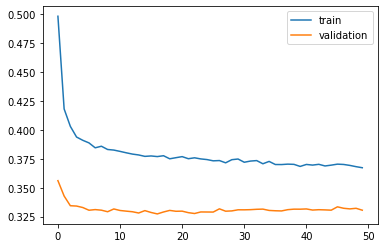

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.349756024974788
Dropout rate 2: 0.4712129306803903
Fold: 1
Best val loss: 0.32734597273737365
#################################
Time to train MLP:  94.10525321960449
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.5022 - acc: 0.7691 - val_loss: 0.3592 - val_acc: 0.8545

Epoch 00001: val_loss improved from inf to 0.35918, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4198 - acc: 0.8227 - val_loss: 0.3462 - val_acc: 0.8596

Epoch 00002: val_loss improved from 0.35918 to 0.34620, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4028 - acc: 0.8289 - val_loss: 0.3413 - val_acc: 0.8595

Epoch 00003: val_loss improved from 0.34620 to 0.34127, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3936 - acc: 0.8381 - val_loss: 0.3388 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.34127 to 0.33880, saving model to MLP_val_weights

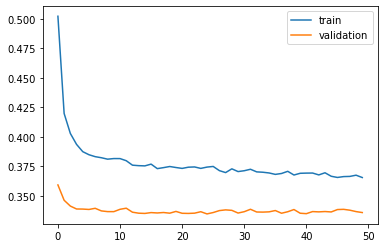

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.349756024974788
Dropout rate 2: 0.4712129306803903
Fold: 2
Best val loss: 0.3346212549307193
#################################
Time to train MLP:  95.54210138320923
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.5028 - acc: 0.7658 - val_loss: 0.3546 - val_acc: 0.8626

Epoch 00001: val_loss improved from inf to 0.35464, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4169 - acc: 0.8219 - val_loss: 0.3398 - val_acc: 0.8660

Epoch 00002: val_loss improved from 0.35464 to 0.33980, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4025 - acc: 0.8292 - val_loss: 0.3361 - val_acc: 0.8673

Epoch 00003: val_loss improved from 0.33980 to 0.33614, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3959 - acc: 0.8326 - val_loss: 0.3333 - val_acc: 0.8688

Epoch 00004: val_loss improved from 0.33614 to 0.33325, saving model to MLP_val_weights.

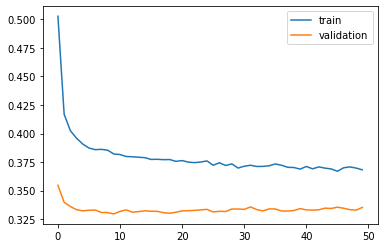

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.349756024974788
Dropout rate 2: 0.4712129306803903
Fold: 3
Best val loss: 0.32959447161496036
#################################
Time to train MLP:  95.81349277496338
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 3s - loss: 0.5030 - acc: 0.7670 - val_loss: 0.3600 - val_acc: 0.8547

Epoch 00001: val_loss improved from inf to 0.36001, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4164 - acc: 0.8232 - val_loss: 0.3462 - val_acc: 0.8598

Epoch 00002: val_loss improved from 0.36001 to 0.34618, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4015 - acc: 0.8289 - val_loss: 0.3424 - val_acc: 0.8614

Epoch 00003: val_loss improved from 0.34618 to 0.34243, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3921 - acc: 0.8343 - val_loss: 0.3395 - val_acc: 0.8626

Epoch 00004: val_loss improved from 0.34243 to 0.33947, saving model to MLP_val_weights

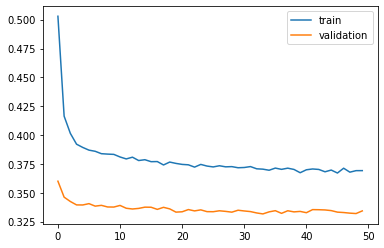

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.349756024974788
Dropout rate 2: 0.4712129306803903
Fold: 4
Best val loss: 0.3316685695397226
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226]]
Time to train MLP:  96.00016736984253
Train on 76950 s

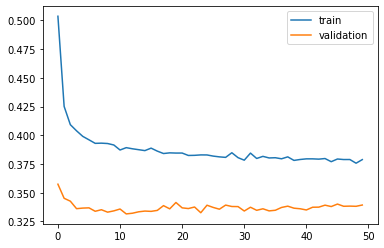

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4999336463119396
Dropout rate 2: 0.3211127406113972
Fold: 0
Best val loss: 0.3314941099791499
#################################
Time to train MLP:  100.65704298019409


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f1028507c18>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f1028507b70>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.4997 - acc: 0.7704 - val_loss: 0.3603 - val_acc: 0.8605

Epoch 00001: val_loss improved from inf to 0.36028, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4242 - acc: 0.8124 - val_loss: 0.3401 - val_acc: 0.8643

Epoch 00002: val_loss improved from 0.36028 to 0.34006, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4072 - acc: 0.8245 - val_loss: 0.3379 - val_acc: 0.8640

Epoch 00003: val_loss improved from 0.34006 to 0.33790, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3980 - acc: 0.8303 - val_loss: 0.3362 - val_acc: 0.8663

Epoch 00004: val_loss improved from 0.33790 to 0.33617, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3942 - acc: 0.8314 - val_loss: 0.3348 - val_acc: 0.8690

Epoch 00005: val_loss improved from 0.33617 to 0.33477, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 2s - loss: 0.3914 - acc: 0.8329 - val_loss: 0.3324 - val

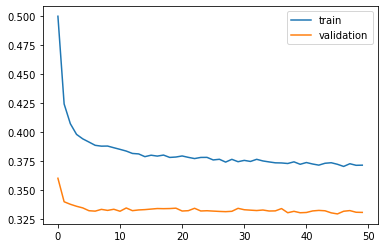

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4999336463119396
Dropout rate 2: 0.3211127406113972
Fold: 1
Best val loss: 0.3296011347171159
#################################
Time to train MLP:  98.67054533958435
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 4s - loss: 0.5042 - acc: 0.7678 - val_loss: 0.3648 - val_acc: 0.8558

Epoch 00001: val_loss improved from inf to 0.36483, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4264 - acc: 0.8086 - val_loss: 0.3504 - val_acc: 0.8591

Epoch 00002: val_loss improved from 0.36483 to 0.35041, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4097 - acc: 0.8167 - val_loss: 0.3486 - val_acc: 0.8620

Epoch 00003: val_loss improved from 0.35041 to 0.34856, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4021 - acc: 0.8233 - val_loss: 0.3448 - val_acc: 0.8606

Epoch 00004: val_loss improved from 0.34856 to 0.34478, saving model to MLP_val_weights

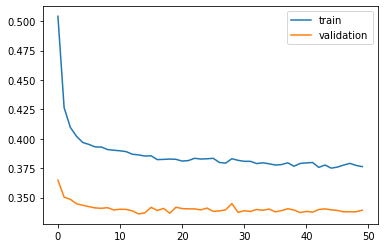

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4999336463119396
Dropout rate 2: 0.3211127406113972
Fold: 2
Best val loss: 0.33616109059916605
#################################
Time to train MLP:  99.09484648704529
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.5041 - acc: 0.7680 - val_loss: 0.3576 - val_acc: 0.8616

Epoch 00001: val_loss improved from inf to 0.35763, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4239 - acc: 0.8079 - val_loss: 0.3444 - val_acc: 0.8623

Epoch 00002: val_loss improved from 0.35763 to 0.34445, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4085 - acc: 0.8188 - val_loss: 0.3386 - val_acc: 0.8660

Epoch 00003: val_loss improved from 0.34445 to 0.33857, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4036 - acc: 0.8242 - val_loss: 0.3361 - val_acc: 0.8650

Epoch 00004: val_loss improved from 0.33857 to 0.33610, saving model to MLP_val_weight

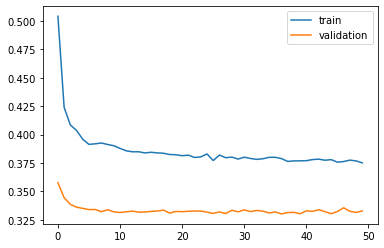

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4999336463119396
Dropout rate 2: 0.3211127406113972
Fold: 3
Best val loss: 0.3301694121346836
#################################
Time to train MLP:  99.45652222633362
Train on 76950 samples, validate on 8550 samples
Epoch 1/50


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0f38101c88>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0f38101dd8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

 - 5s - loss: 0.5040 - acc: 0.7689 - val_loss: 0.3689 - val_acc: 0.8526

Epoch 00001: val_loss improved from inf to 0.36887, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4244 - acc: 0.8091 - val_loss: 0.3525 - val_acc: 0.8601

Epoch 00002: val_loss improved from 0.36887 to 0.35254, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4089 - acc: 0.8171 - val_loss: 0.3491 - val_acc: 0.8594

Epoch 00003: val_loss improved from 0.35254 to 0.34913, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4015 - acc: 0.8204 - val_loss: 0.3457 - val_acc: 0.8611

Epoch 00004: val_loss improved from 0.34913 to 0.34570, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3976 - acc: 0.8225 - val_loss: 0.3416 - val_acc: 0.8626

Epoch 00005: val_loss improved from 0.34570 to 0.34156, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 2s - loss: 0.3957 - acc: 0.8242 - val_loss: 0.3395 - val_acc: 0.8647

Epoch 00006: val_loss improved from 0.34156 to

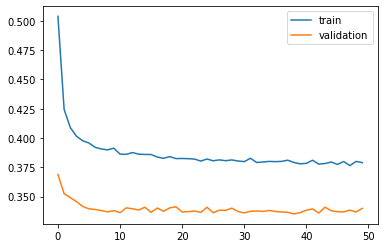

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4999336463119396
Dropout rate 2: 0.3211127406113972
Fold: 4
Best val loss: 0.33523485849475304
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00049: val_loss did not improve from 0.33656
Epoch 50/50
 - 2s - loss: 0.3174 - acc: 0.8733 - val_loss: 0.3486 - val_acc: 0.8644

Epoch 00050: val_loss did not improve from 0.33656


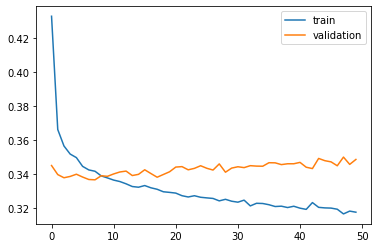

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.11003364989142589
Dropout rate 2: 0.3073238169210421
Fold: 0
Best val loss: 0.3365610728765789
#################################
Time to train MLP:  101.03005290031433
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.4327 - acc: 0.8162 - val_loss: 0.3404 - val_acc: 0.8628

Epoch 00001: val_loss improved from inf to 0.34039, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3672 - acc: 0.8555 - val_loss: 0.3345 - val_acc: 0.8641

Epoch 00002: val_loss improved from 0.34039 to 0.33452, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3573 - acc: 0.8596 - val_loss: 0.3332 - val_acc: 0.8649

Epoch 00003: val_loss improved from 0.33452 to 0.33316, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3510 - acc: 0.8622 - val_loss: 0.3327 - val_acc: 0.8667

Epoch 00004: val_loss improved from 0.33316 to 0.33272, saving model to MLP_val_weigh

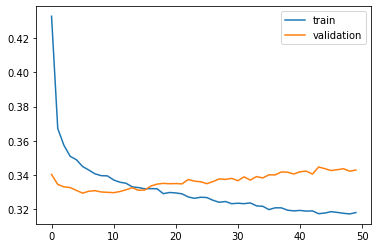

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.11003364989142589
Dropout rate 2: 0.3073238169210421
Fold: 1
Best val loss: 0.32946135788633113
#################################
Time to train MLP:  100.65863418579102
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.4306 - acc: 0.8166 - val_loss: 0.3496 - val_acc: 0.8571

Epoch 00001: val_loss improved from inf to 0.34965, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3667 - acc: 0.8558 - val_loss: 0.3416 - val_acc: 0.8598

Epoch 00002: val_loss improved from 0.34965 to 0.34159, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3551 - acc: 0.8604 - val_loss: 0.3384 - val_acc: 0.8629

Epoch 00003: val_loss improved from 0.34159 to 0.33835, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3502 - acc: 0.8615 - val_loss: 0.3365 - val_acc: 0.8628

Epoch 00004: val_loss improved from 0.33835 to 0.33651, saving model to MLP_val_weig

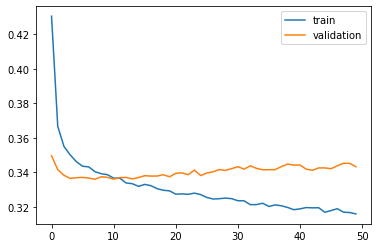

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.11003364989142589
Dropout rate 2: 0.3073238169210421
Fold: 2
Best val loss: 0.33603455296036794
#################################
Time to train MLP:  100.43273615837097
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 5s - loss: 0.4352 - acc: 0.8134 - val_loss: 0.3446 - val_acc: 0.8642

Epoch 00001: val_loss improved from inf to 0.34458, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3681 - acc: 0.8551 - val_loss: 0.3367 - val_acc: 0.8673

Epoch 00002: val_loss improved from 0.34458 to 0.33665, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3568 - acc: 0.8598 - val_loss: 0.3336 - val_acc: 0.8688

Epoch 00003: val_loss improved from 0.33665 to 0.33359, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3526 - acc: 0.8605 - val_loss: 0.3330 - val_acc: 0.8691

Epoch 00004: val_loss improved from 0.33359 to 0.33302, saving model to MLP_val_weig

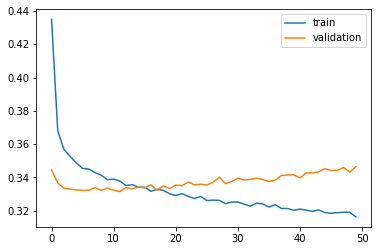

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.11003364989142589
Dropout rate 2: 0.3073238169210421
Fold: 3
Best val loss: 0.3315241533901259
#################################
Time to train MLP:  102.06418800354004
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.4313 - acc: 0.8153 - val_loss: 0.3491 - val_acc: 0.8581

Epoch 00001: val_loss improved from inf to 0.34912, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3656 - acc: 0.8562 - val_loss: 0.3445 - val_acc: 0.8596

Epoch 00002: val_loss improved from 0.34912 to 0.34448, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3558 - acc: 0.8611 - val_loss: 0.3414 - val_acc: 0.8606

Epoch 00003: val_loss improved from 0.34448 to 0.34143, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3507 - acc: 0.8623 - val_loss: 0.3388 - val_acc: 0.8613

Epoch 00004: val_loss improved from 0.34143 to 0.33878, saving model to MLP_val_weigh

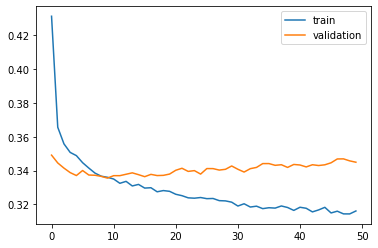

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.11003364989142589
Dropout rate 2: 0.3073238169210421
Fold: 4
Best val loss: 0.3355175270532307
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00046: val_loss did not improve from 0.33403
Epoch 47/50
 - 2s - loss: 0.3095 - acc: 0.8783 - val_loss: 0.3407 - val_acc: 0.8664

Epoch 00047: val_loss did not improve from 0.33403
Epoch 48/50
 - 2s - loss: 0.3074 - acc: 0.8797 - val_loss: 0.3424 - val_acc: 0.8658

Epoch 00048: val_loss did not improve from 0.33403
Epoch 49/50
 - 2s - loss: 0.3098 - acc: 0.8786 - val_loss: 0.3422 - val_acc: 0.8662

Epoch 00049: val_loss did not improve from 0.33403
Epoch 50/50
 - 2s - loss: 0.3083 - acc: 0.8785 - val_loss: 0.3437 - val_acc: 0.8667

Epoch 00050: val_loss did not improve from 0.33403


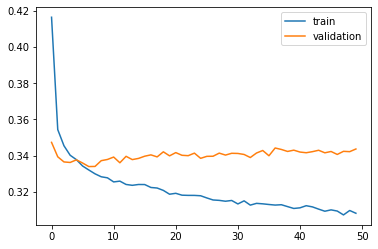

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.180528176982029
Dropout rate 2: 0.11384162719898794
Fold: 0
Best val loss: 0.33402691475132057
#################################
Time to train MLP:  104.52306938171387
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.4152 - acc: 0.8299 - val_loss: 0.3385 - val_acc: 0.8637

Epoch 00001: val_loss improved from inf to 0.33853, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3550 - acc: 0.8595 - val_loss: 0.3336 - val_acc: 0.8641

Epoch 00002: val_loss improved from 0.33853 to 0.33359, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3460 - acc: 0.8639 - val_loss: 0.3322 - val_acc: 0.8661

Epoch 00003: val_loss improved from 0.33359 to 0.33217, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3393 - acc: 0.8682 - val_loss: 0.3303 - val_acc: 0.8662

Epoch 00004: val_loss improved from 0.33217 to 0.33033, saving model to MLP_val_weigh

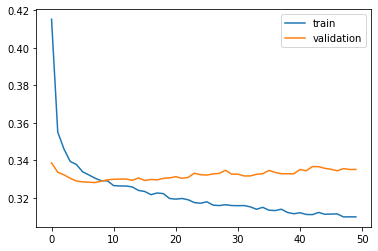

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.180528176982029
Dropout rate 2: 0.11384162719898794
Fold: 1
Best val loss: 0.3280669021118454
#################################
Time to train MLP:  105.8024787902832
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 6s - loss: 0.4127 - acc: 0.8294 - val_loss: 0.3472 - val_acc: 0.8588

Epoch 00001: val_loss improved from inf to 0.34723, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3552 - acc: 0.8602 - val_loss: 0.3418 - val_acc: 0.8630

Epoch 00002: val_loss improved from 0.34723 to 0.34178, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3462 - acc: 0.8654 - val_loss: 0.3386 - val_acc: 0.8642

Epoch 00003: val_loss improved from 0.34178 to 0.33863, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3405 - acc: 0.8682 - val_loss: 0.3371 - val_acc: 0.8646

Epoch 00004: val_loss improved from 0.33863 to 0.33712, saving model to MLP_val_weights

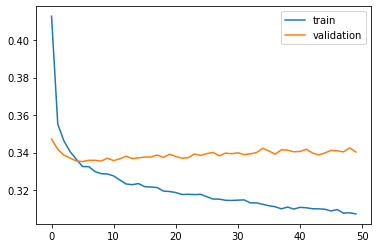

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.180528176982029
Dropout rate 2: 0.11384162719898794
Fold: 2
Best val loss: 0.3352458250906035
#################################
Time to train MLP:  107.09020471572876
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 7s - loss: 0.4142 - acc: 0.8274 - val_loss: 0.3422 - val_acc: 0.8625

Epoch 00001: val_loss improved from inf to 0.34217, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3552 - acc: 0.8593 - val_loss: 0.3356 - val_acc: 0.8657

Epoch 00002: val_loss improved from 0.34217 to 0.33562, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3445 - acc: 0.8639 - val_loss: 0.3318 - val_acc: 0.8678

Epoch 00003: val_loss improved from 0.33562 to 0.33181, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3411 - acc: 0.8670 - val_loss: 0.3311 - val_acc: 0.8692

Epoch 00004: val_loss improved from 0.33181 to 0.33107, saving model to MLP_val_weight

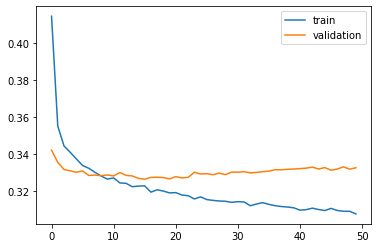

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.180528176982029
Dropout rate 2: 0.11384162719898794
Fold: 3
Best val loss: 0.32659123530164796
#################################
Time to train MLP:  107.27301859855652
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 7s - loss: 0.4141 - acc: 0.8290 - val_loss: 0.3508 - val_acc: 0.8567

Epoch 00001: val_loss improved from inf to 0.35079, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3540 - acc: 0.8609 - val_loss: 0.3434 - val_acc: 0.8627

Epoch 00002: val_loss improved from 0.35079 to 0.34343, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3461 - acc: 0.8644 - val_loss: 0.3421 - val_acc: 0.8616

Epoch 00003: val_loss improved from 0.34343 to 0.34208, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3392 - acc: 0.8670 - val_loss: 0.3374 - val_acc: 0.8619

Epoch 00004: val_loss improved from 0.34208 to 0.33745, saving model to MLP_val_weigh

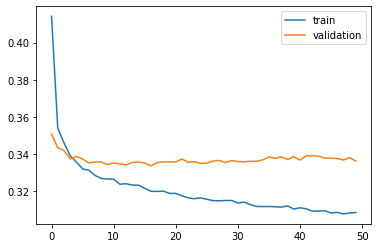

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.180528176982029
Dropout rate 2: 0.11384162719898794
Fold: 4
Best val loss: 0.33374187668164573
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00044: val_loss did not improve from 0.33175
Epoch 45/50
 - 2s - loss: 0.3416 - acc: 0.8640 - val_loss: 0.3382 - val_acc: 0.8680

Epoch 00045: val_loss did not improve from 0.33175
Epoch 46/50
 - 2s - loss: 0.3417 - acc: 0.8655 - val_loss: 0.3362 - val_acc: 0.8696

Epoch 00046: val_loss did not improve from 0.33175
Epoch 47/50
 - 2s - loss: 0.3408 - acc: 0.8650 - val_loss: 0.3383 - val_acc: 0.8685

Epoch 00047: val_loss did not improve from 0.33175
Epoch 48/50
 - 2s - loss: 0.3415 - acc: 0.8640 - val_loss: 0.3377 - val_acc: 0.8682

Epoch 00048: val_loss did not improve from 0.33175
Epoch 49/50
 - 2s - loss: 0.3405 - acc: 0.8644 - val_loss: 0.3375 - val_acc: 0.8691

Epoch 00049: val_loss did not improve from 0.33175
Epoch 50/50
 - 2s - loss: 0.3394 - acc: 0.8656 - val_loss: 0.3398 - val_acc: 0.8695

Epoch 00050: val_loss did not improve from 0.33175


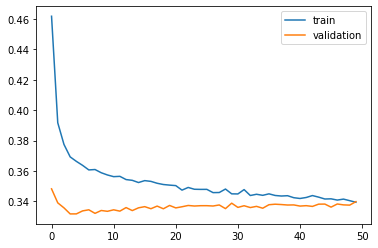

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3699204951047185
Dropout rate 2: 0.24301593448318637
Fold: 0
Best val loss: 0.33174909263326413
#################################
Time to train MLP:  109.17673587799072
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 8s - loss: 0.4589 - acc: 0.8005 - val_loss: 0.3445 - val_acc: 0.8605

Epoch 00001: val_loss improved from inf to 0.34451, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3902 - acc: 0.8376 - val_loss: 0.3340 - val_acc: 0.8653

Epoch 00002: val_loss improved from 0.34451 to 0.33397, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3774 - acc: 0.8482 - val_loss: 0.3328 - val_acc: 0.8665

Epoch 00003: val_loss improved from 0.33397 to 0.33283, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3696 - acc: 0.8512 - val_loss: 0.3313 - val_acc: 0.8665

Epoch 00004: val_loss improved from 0.33283 to 0.33131, saving model to MLP_val_weig

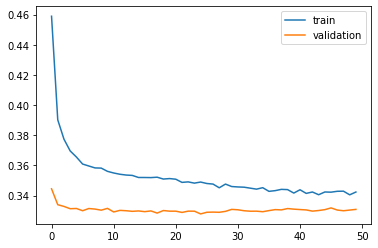

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3699204951047185
Dropout rate 2: 0.24301593448318637
Fold: 1
Best val loss: 0.3278632639514075
#################################
Time to train MLP:  111.15578866004944
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 8s - loss: 0.4636 - acc: 0.7974 - val_loss: 0.3531 - val_acc: 0.8566

Epoch 00001: val_loss improved from inf to 0.35315, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3917 - acc: 0.8381 - val_loss: 0.3440 - val_acc: 0.8604

Epoch 00002: val_loss improved from 0.35315 to 0.34404, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3744 - acc: 0.8488 - val_loss: 0.3440 - val_acc: 0.8612

Epoch 00003: val_loss improved from 0.34404 to 0.34402, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3681 - acc: 0.8552 - val_loss: 0.3401 - val_acc: 0.8636

Epoch 00004: val_loss improved from 0.34402 to 0.34013, saving model to MLP_val_weigh

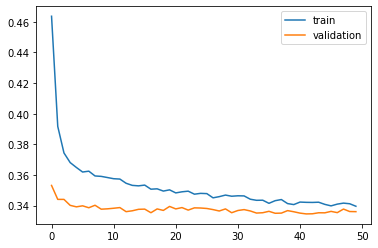

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3699204951047185
Dropout rate 2: 0.24301593448318637
Fold: 2
Best val loss: 0.3345422548613353
#################################
Time to train MLP:  112.19529366493225
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 8s - loss: 0.4623 - acc: 0.7979 - val_loss: 0.3471 - val_acc: 0.8649

Epoch 00001: val_loss improved from inf to 0.34711, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3892 - acc: 0.8376 - val_loss: 0.3378 - val_acc: 0.8650

Epoch 00002: val_loss improved from 0.34711 to 0.33782, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3757 - acc: 0.8478 - val_loss: 0.3351 - val_acc: 0.8676

Epoch 00003: val_loss improved from 0.33782 to 0.33515, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3709 - acc: 0.8535 - val_loss: 0.3327 - val_acc: 0.8674

Epoch 00004: val_loss improved from 0.33515 to 0.33273, saving model to MLP_val_weigh

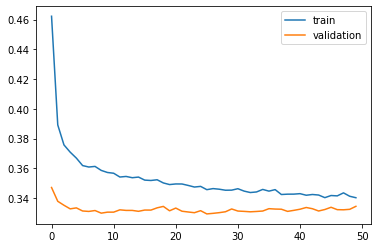

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3699204951047185
Dropout rate 2: 0.24301593448318637
Fold: 3
Best val loss: 0.3293277821345636
#################################
Time to train MLP:  111.2660059928894
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 8s - loss: 0.4626 - acc: 0.7998 - val_loss: 0.3575 - val_acc: 0.8564

Epoch 00001: val_loss improved from inf to 0.35753, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3894 - acc: 0.8385 - val_loss: 0.3445 - val_acc: 0.8616

Epoch 00002: val_loss improved from 0.35753 to 0.34449, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3759 - acc: 0.8488 - val_loss: 0.3402 - val_acc: 0.8620

Epoch 00003: val_loss improved from 0.34449 to 0.34024, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3677 - acc: 0.8536 - val_loss: 0.3393 - val_acc: 0.8627

Epoch 00004: val_loss improved from 0.34024 to 0.33932, saving model to MLP_val_weight

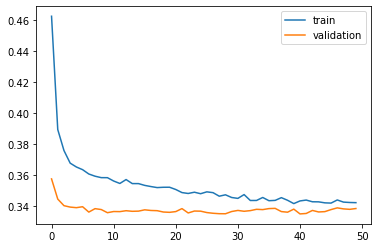

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3699204951047185
Dropout rate 2: 0.24301593448318637
Fold: 4
Best val loss: 0.3349070033831903
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00040: val_loss did not improve from 0.33045
Epoch 41/50
 - 2s - loss: 0.3901 - acc: 0.8241 - val_loss: 0.3339 - val_acc: 0.8676

Epoch 00041: val_loss did not improve from 0.33045
Epoch 42/50
 - 2s - loss: 0.3883 - acc: 0.8245 - val_loss: 0.3345 - val_acc: 0.8690

Epoch 00042: val_loss did not improve from 0.33045
Epoch 43/50
 - 2s - loss: 0.3888 - acc: 0.8244 - val_loss: 0.3332 - val_acc: 0.8684

Epoch 00043: val_loss did not improve from 0.33045
Epoch 44/50
 - 2s - loss: 0.3897 - acc: 0.8235 - val_loss: 0.3348 - val_acc: 0.8671

Epoch 00044: val_loss did not improve from 0.33045
Epoch 45/50
 - 2s - loss: 0.3873 - acc: 0.8226 - val_loss: 0.3343 - val_acc: 0.8668

Epoch 00045: val_loss did not improve from 0.33045
Epoch 46/50
 - 2s - loss: 0.3904 - acc: 0.8243 - val_loss: 0.3347 - val_acc: 0.8677

Epoch 00046: val_loss did not improve from 0.33045
Epoch 47/50
 - 2s - loss: 0.3881 - acc: 0.8240 - val_loss: 0.3351 - val_acc: 0.8667

Epoch 00047: val_loss did not improve from 0.33

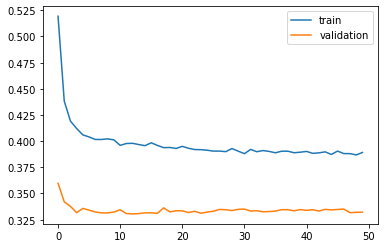

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4982278625445485
Dropout rate 2: 0.40360964969420665
Fold: 0
Best val loss: 0.33044918044965865
#################################
Time to train MLP:  116.3251211643219
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.5142 - acc: 0.7586 - val_loss: 0.3570 - val_acc: 0.8585

Epoch 00001: val_loss improved from inf to 0.35697, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4332 - acc: 0.8087 - val_loss: 0.3434 - val_acc: 0.8626

Epoch 00002: val_loss improved from 0.35697 to 0.34344, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4164 - acc: 0.8167 - val_loss: 0.3396 - val_acc: 0.8642

Epoch 00003: val_loss improved from 0.34344 to 0.33958, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4072 - acc: 0.8212 - val_loss: 0.3381 - val_acc: 0.8654

Epoch 00004: val_loss improved from 0.33958 to 0.33810, saving model to MLP_val_weigh

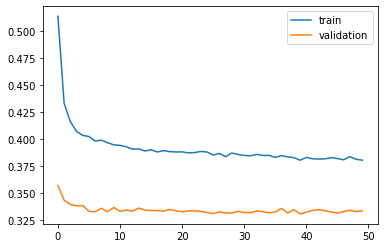

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4982278625445485
Dropout rate 2: 0.40360964969420665
Fold: 1
Best val loss: 0.3306906870024943
#################################
Time to train MLP:  114.28697061538696


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0f08b13f60>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0f08b32c50>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.5202 - acc: 0.7561 - val_loss: 0.3695 - val_acc: 0.8542

Epoch 00001: val_loss improved from inf to 0.36955, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4410 - acc: 0.7960 - val_loss: 0.3541 - val_acc: 0.8574

Epoch 00002: val_loss improved from 0.36955 to 0.35411, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4217 - acc: 0.8041 - val_loss: 0.3510 - val_acc: 0.8618

Epoch 00003: val_loss improved from 0.35411 to 0.35101, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4151 - acc: 0.8100 - val_loss: 0.3436 - val_acc: 0.8630

Epoch 00004: val_loss improved from 0.35101 to 0.34361, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.4097 - acc: 0.8110 - val_loss: 0.3441 - val_acc: 0.8606

Epoch 00005: val_loss did not improve from 0.34361
Epoch 6/50
 - 2s - loss: 0.4076 - acc: 0.8114 - val_loss: 0.3434 - val_acc: 0.8628

Epoch 00006: val_loss impro

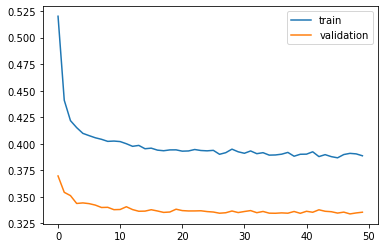

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4982278625445485
Dropout rate 2: 0.40360964969420665
Fold: 2
Best val loss: 0.33375084265630844
#################################
Time to train MLP:  116.46371531486511
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.5181 - acc: 0.7569 - val_loss: 0.3637 - val_acc: 0.8613

Epoch 00001: val_loss improved from inf to 0.36367, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4334 - acc: 0.8059 - val_loss: 0.3450 - val_acc: 0.8642

Epoch 00002: val_loss improved from 0.36367 to 0.34504, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4157 - acc: 0.8171 - val_loss: 0.3410 - val_acc: 0.8660

Epoch 00003: val_loss improved from 0.34504 to 0.34103, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4090 - acc: 0.8244 - val_loss: 0.3398 - val_acc: 0.8658

Epoch 00004: val_loss improved from 0.34103 to 0.33981, saving model to MLP_val_weig

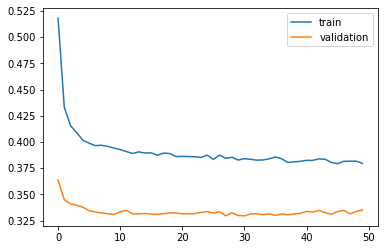

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4982278625445485
Dropout rate 2: 0.40360964969420665
Fold: 3
Best val loss: 0.3295575479457253
#################################
Time to train MLP:  115.52656531333923
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 9s - loss: 0.5223 - acc: 0.7547 - val_loss: 0.3724 - val_acc: 0.8549

Epoch 00001: val_loss improved from inf to 0.37242, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.4373 - acc: 0.7983 - val_loss: 0.3528 - val_acc: 0.8609

Epoch 00002: val_loss improved from 0.37242 to 0.35283, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.4209 - acc: 0.8046 - val_loss: 0.3506 - val_acc: 0.8614

Epoch 00003: val_loss improved from 0.35283 to 0.35057, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4130 - acc: 0.8095 - val_loss: 0.3459 - val_acc: 0.8632

Epoch 00004: val_loss improved from 0.35057 to 0.34586, saving model to MLP_val_weigh

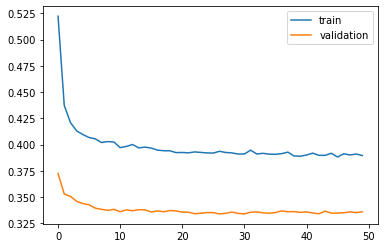

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4982278625445485
Dropout rate 2: 0.40360964969420665
Fold: 4
Best val loss: 0.3338632843578071
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00038: val_loss did not improve from 0.33391
Epoch 39/50
 - 2s - loss: 0.3355 - acc: 0.8683 - val_loss: 0.3438 - val_acc: 0.8684

Epoch 00039: val_loss did not improve from 0.33391
Epoch 40/50
 - 2s - loss: 0.3354 - acc: 0.8677 - val_loss: 0.3447 - val_acc: 0.8667

Epoch 00040: val_loss did not improve from 0.33391
Epoch 41/50
 - 2s - loss: 0.3372 - acc: 0.8678 - val_loss: 0.3444 - val_acc: 0.8678

Epoch 00041: val_loss did not improve from 0.33391
Epoch 42/50
 - 2s - loss: 0.3365 - acc: 0.8669 - val_loss: 0.3429 - val_acc: 0.8668

Epoch 00042: val_loss did not improve from 0.33391
Epoch 43/50
 - 2s - loss: 0.3373 - acc: 0.8675 - val_loss: 0.3419 - val_acc: 0.8676

Epoch 00043: val_loss did not improve from 0.33391
Epoch 44/50
 - 2s - loss: 0.3354 - acc: 0.8679 - val_loss: 0.3445 - val_acc: 0.8680

Epoch 00044: val_loss did not improve from 0.33391
Epoch 45/50
 - 2s - loss: 0.3330 - acc: 0.8683 - val_loss: 0.3462 - val_acc: 0.8669

Epoch 00045: val_loss did not improve from 0.33

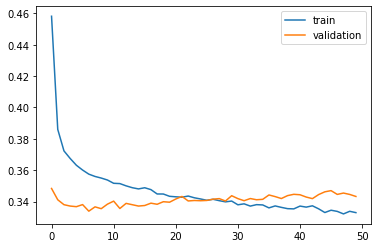

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1581734888953042
Dropout rate 2: 0.4221100767611815
Fold: 0
Best val loss: 0.33391380277990595
#################################
Time to train MLP:  117.31832838058472
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.4597 - acc: 0.7975 - val_loss: 0.3419 - val_acc: 0.8619

Epoch 00001: val_loss improved from inf to 0.34189, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3876 - acc: 0.8430 - val_loss: 0.3365 - val_acc: 0.8634

Epoch 00002: val_loss improved from 0.34189 to 0.33649, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3766 - acc: 0.8473 - val_loss: 0.3331 - val_acc: 0.8675

Epoch 00003: val_loss improved from 0.33649 to 0.33310, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3705 - acc: 0.8493 - val_loss: 0.3327 - val_acc: 0.8673

Epoch 00004: val_loss improved from 0.33310 to 0.33273, saving model to MLP_val_weig

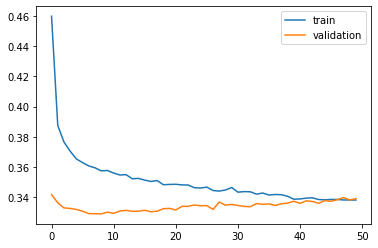

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1581734888953042
Dropout rate 2: 0.4221100767611815
Fold: 1
Best val loss: 0.32912902784626386
#################################
Time to train MLP:  118.98999404907227
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.4580 - acc: 0.7990 - val_loss: 0.3513 - val_acc: 0.8558

Epoch 00001: val_loss improved from inf to 0.35129, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3889 - acc: 0.8410 - val_loss: 0.3409 - val_acc: 0.8606

Epoch 00002: val_loss improved from 0.35129 to 0.34094, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3729 - acc: 0.8529 - val_loss: 0.3411 - val_acc: 0.8612

Epoch 00003: val_loss did not improve from 0.34094
Epoch 4/50
 - 2s - loss: 0.3662 - acc: 0.8556 - val_loss: 0.3399 - val_acc: 0.8630

Epoch 00004: val_loss improved from 0.34094 to 0.33993, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3620 -

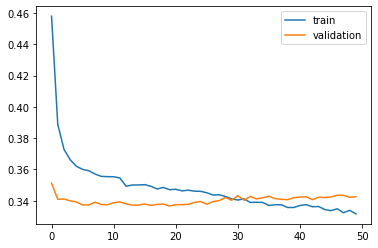

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1581734888953042
Dropout rate 2: 0.4221100767611815
Fold: 2
Best val loss: 0.3366392298295484
#################################
Time to train MLP:  117.53524088859558
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.4629 - acc: 0.7943 - val_loss: 0.3473 - val_acc: 0.8628

Epoch 00001: val_loss improved from inf to 0.34727, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3885 - acc: 0.8415 - val_loss: 0.3399 - val_acc: 0.8637

Epoch 00002: val_loss improved from 0.34727 to 0.33988, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3786 - acc: 0.8455 - val_loss: 0.3353 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.33988 to 0.33525, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3684 - acc: 0.8549 - val_loss: 0.3330 - val_acc: 0.8689

Epoch 00004: val_loss improved from 0.33525 to 0.33305, saving model to MLP_val_weigh

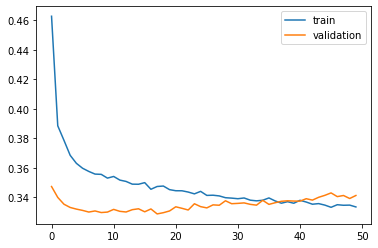

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1581734888953042
Dropout rate 2: 0.4221100767611815
Fold: 3
Best val loss: 0.32866880232130574
#################################
Time to train MLP:  121.091641664505
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 10s - loss: 0.4587 - acc: 0.7962 - val_loss: 0.3517 - val_acc: 0.8567

Epoch 00001: val_loss improved from inf to 0.35172, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3869 - acc: 0.8431 - val_loss: 0.3454 - val_acc: 0.8577

Epoch 00002: val_loss improved from 0.35172 to 0.34538, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3754 - acc: 0.8471 - val_loss: 0.3410 - val_acc: 0.8602

Epoch 00003: val_loss improved from 0.34538 to 0.34102, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3700 - acc: 0.8503 - val_loss: 0.3400 - val_acc: 0.8614

Epoch 00004: val_loss improved from 0.34102 to 0.34005, saving model to MLP_val_weight

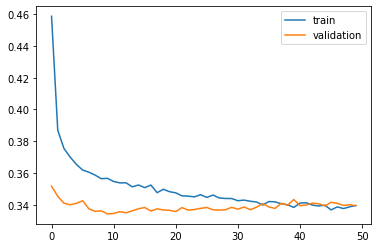

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1581734888953042
Dropout rate 2: 0.4221100767611815
Fold: 4
Best val loss: 0.33428225812856216
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0ec5bfa9b0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f0ec5b96e48>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.4225 - acc: 0.8237 - val_loss: 0.3462 - val_acc: 0.8592

Epoch 00001: val_loss improved from inf to 0.34617, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3589 - acc: 0.8587 - val_loss: 0.3405 - val_acc: 0.8646

Epoch 00002: val_loss improved from 0.34617 to 0.34052, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3493 - acc: 0.8637 - val_loss: 0.3385 - val_acc: 0.8655

Epoch 00003: val_loss improved from 0.34052 to 0.33847, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3451 - acc: 0.8646 - val_loss: 0.3378 - val_acc: 0.8670

Epoch 00004: val_loss improved from 0.33847 to 0.33781, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3422 - acc: 0.8653 - val_loss: 0.3369 - val_acc: 0.8674

Epoch 00005: val_loss improved from 0.33781 to 0.33690, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 2s - loss: 0.3389 - acc: 0.8670 - val_loss: 0.3372 - va

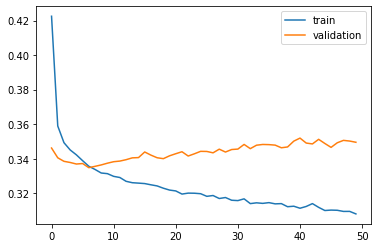

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.06827228991176232
Dropout rate 2: 0.2673404331149786
Fold: 0
Best val loss: 0.33479082530702065
#################################
Time to train MLP:  120.38007283210754
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.4225 - acc: 0.8212 - val_loss: 0.3380 - val_acc: 0.8629

Epoch 00001: val_loss improved from inf to 0.33796, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3591 - acc: 0.8591 - val_loss: 0.3347 - val_acc: 0.8655

Epoch 00002: val_loss improved from 0.33796 to 0.33468, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3492 - acc: 0.8629 - val_loss: 0.3337 - val_acc: 0.8647

Epoch 00003: val_loss improved from 0.33468 to 0.33369, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3443 - acc: 0.8648 - val_loss: 0.3320 - val_acc: 0.8662

Epoch 00004: val_loss improved from 0.33369 to 0.33202, saving model to MLP_val_wei

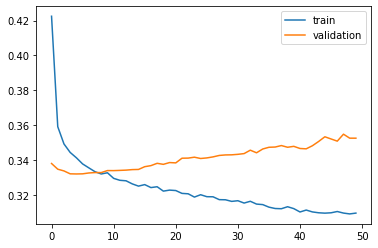

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.06827228991176232
Dropout rate 2: 0.2673404331149786
Fold: 1
Best val loss: 0.33194378963687965
#################################
Time to train MLP:  121.62946605682373
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.4211 - acc: 0.8218 - val_loss: 0.3473 - val_acc: 0.8584

Epoch 00001: val_loss improved from inf to 0.34729, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3591 - acc: 0.8594 - val_loss: 0.3426 - val_acc: 0.8582

Epoch 00002: val_loss improved from 0.34729 to 0.34258, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3489 - acc: 0.8633 - val_loss: 0.3395 - val_acc: 0.8604

Epoch 00003: val_loss improved from 0.34258 to 0.33953, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3445 - acc: 0.8657 - val_loss: 0.3385 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.33953 to 0.33847, saving model to MLP_val_wei

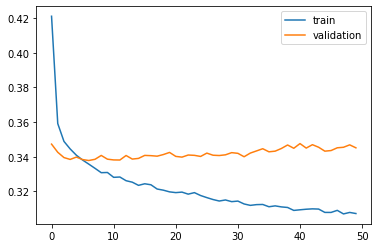

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.06827228991176232
Dropout rate 2: 0.2673404331149786
Fold: 2
Best val loss: 0.3378439161164022
#################################
Time to train MLP:  123.13582921028137
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 11s - loss: 0.4253 - acc: 0.8199 - val_loss: 0.3449 - val_acc: 0.8643

Epoch 00001: val_loss improved from inf to 0.34485, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3590 - acc: 0.8585 - val_loss: 0.3364 - val_acc: 0.8669

Epoch 00002: val_loss improved from 0.34485 to 0.33635, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3493 - acc: 0.8633 - val_loss: 0.3327 - val_acc: 0.8674

Epoch 00003: val_loss improved from 0.33635 to 0.33270, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3445 - acc: 0.8650 - val_loss: 0.3330 - val_acc: 0.8680

Epoch 00004: val_loss did not improve from 0.33270
Epoch 5/50
 - 2s - loss: 0.3412 -

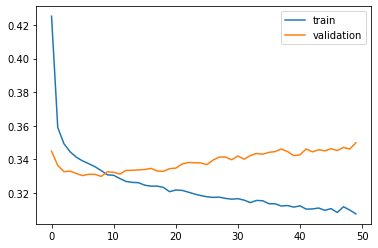

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.06827228991176232
Dropout rate 2: 0.2673404331149786
Fold: 3
Best val loss: 0.32985379499998707
#################################
Time to train MLP:  124.03173732757568
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 13s - loss: 0.4203 - acc: 0.8221 - val_loss: 0.3506 - val_acc: 0.8560

Epoch 00001: val_loss improved from inf to 0.35065, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3570 - acc: 0.8599 - val_loss: 0.3449 - val_acc: 0.8625

Epoch 00002: val_loss improved from 0.35065 to 0.34491, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3487 - acc: 0.8632 - val_loss: 0.3413 - val_acc: 0.8625

Epoch 00003: val_loss improved from 0.34491 to 0.34130, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3433 - acc: 0.8656 - val_loss: 0.3394 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.34130 to 0.33942, saving model to MLP_val_wei

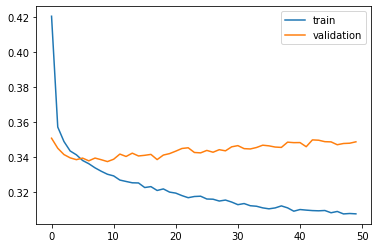

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.06827228991176232
Dropout rate 2: 0.2673404331149786
Fold: 4
Best val loss: 0.3373010672602737
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00032: val_loss did not improve from 0.33256
Epoch 33/50
 - 2s - loss: 0.3353 - acc: 0.8684 - val_loss: 0.3416 - val_acc: 0.8676

Epoch 00033: val_loss did not improve from 0.33256
Epoch 34/50
 - 2s - loss: 0.3365 - acc: 0.8682 - val_loss: 0.3409 - val_acc: 0.8674

Epoch 00034: val_loss did not improve from 0.33256
Epoch 35/50
 - 2s - loss: 0.3345 - acc: 0.8696 - val_loss: 0.3444 - val_acc: 0.8680

Epoch 00035: val_loss did not improve from 0.33256
Epoch 36/50
 - 2s - loss: 0.3335 - acc: 0.8701 - val_loss: 0.3450 - val_acc: 0.8660

Epoch 00036: val_loss did not improve from 0.33256
Epoch 37/50
 - 2s - loss: 0.3350 - acc: 0.8693 - val_loss: 0.3430 - val_acc: 0.8671

Epoch 00037: val_loss did not improve from 0.33256
Epoch 38/50
 - 2s - loss: 0.3341 - acc: 0.8681 - val_loss: 0.3455 - val_acc: 0.8670

Epoch 00038: val_loss did not improve from 0.33256
Epoch 39/50
 - 2s - loss: 0.3346 - acc: 0.8700 - val_loss: 0.3440 - val_acc: 0.8683

Epoch 00039: val_loss did not improve from 0.33

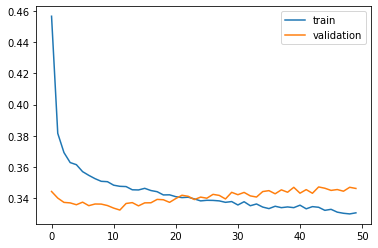

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.19199000507580005
Dropout rate 2: 0.37889902492722
Fold: 0
Best val loss: 0.3325593878999788
#################################
Time to train MLP:  128.36774826049805
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 12s - loss: 0.4546 - acc: 0.8013 - val_loss: 0.3418 - val_acc: 0.8636

Epoch 00001: val_loss improved from inf to 0.34182, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3835 - acc: 0.8467 - val_loss: 0.3353 - val_acc: 0.8647

Epoch 00002: val_loss improved from 0.34182 to 0.33527, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3727 - acc: 0.8507 - val_loss: 0.3339 - val_acc: 0.8660

Epoch 00003: val_loss improved from 0.33527 to 0.33388, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3661 - acc: 0.8530 - val_loss: 0.3321 - val_acc: 0.8661

Epoch 00004: val_loss improved from 0.33388 to 0.33209, saving model to MLP_val_weight

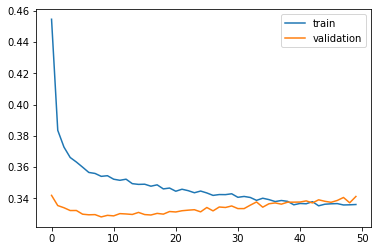

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.19199000507580005
Dropout rate 2: 0.37889902492722
Fold: 1
Best val loss: 0.3280026886686247
#################################
Time to train MLP:  128.62662744522095
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 12s - loss: 0.4540 - acc: 0.8022 - val_loss: 0.3501 - val_acc: 0.8571

Epoch 00001: val_loss improved from inf to 0.35007, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3850 - acc: 0.8448 - val_loss: 0.3428 - val_acc: 0.8596

Epoch 00002: val_loss improved from 0.35007 to 0.34283, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3717 - acc: 0.8503 - val_loss: 0.3398 - val_acc: 0.8614

Epoch 00003: val_loss improved from 0.34283 to 0.33980, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3669 - acc: 0.8534 - val_loss: 0.3375 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.33980 to 0.33755, saving model to MLP_val_weight

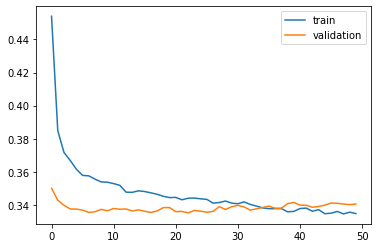

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.19199000507580005
Dropout rate 2: 0.37889902492722
Fold: 2
Best val loss: 0.3351655651533116
#################################
Time to train MLP:  127.28942728042603
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 13s - loss: 0.4586 - acc: 0.7968 - val_loss: 0.3469 - val_acc: 0.8641

Epoch 00001: val_loss improved from inf to 0.34687, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3842 - acc: 0.8465 - val_loss: 0.3371 - val_acc: 0.8675

Epoch 00002: val_loss improved from 0.34687 to 0.33714, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3738 - acc: 0.8500 - val_loss: 0.3340 - val_acc: 0.8683

Epoch 00003: val_loss improved from 0.33714 to 0.33398, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3679 - acc: 0.8531 - val_loss: 0.3342 - val_acc: 0.8677

Epoch 00004: val_loss did not improve from 0.33398
Epoch 5/50
 - 2s - loss: 0.3640 - a

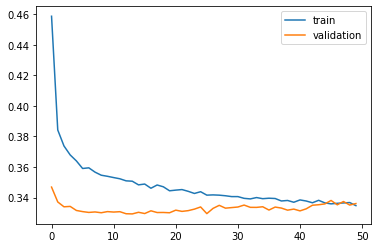

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.19199000507580005
Dropout rate 2: 0.37889902492722
Fold: 3
Best val loss: 0.329321895795956
#################################
Time to train MLP:  131.61687302589417
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 13s - loss: 0.4556 - acc: 0.7992 - val_loss: 0.3539 - val_acc: 0.8563

Epoch 00001: val_loss improved from inf to 0.35385, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3828 - acc: 0.8478 - val_loss: 0.3473 - val_acc: 0.8605

Epoch 00002: val_loss improved from 0.35385 to 0.34735, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3716 - acc: 0.8506 - val_loss: 0.3410 - val_acc: 0.8605

Epoch 00003: val_loss improved from 0.34735 to 0.34099, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3661 - acc: 0.8533 - val_loss: 0.3393 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.34099 to 0.33927, saving model to MLP_val_weights

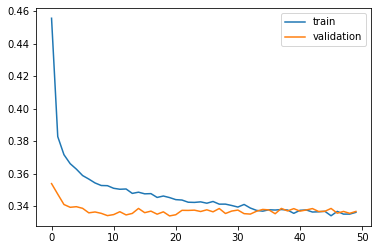

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.19199000507580005
Dropout rate 2: 0.37889902492722
Fold: 4
Best val loss: 0.3339618885029129
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 0.

 - 2s - loss: 0.3232 - acc: 0.8737 - val_loss: 0.3404 - val_acc: 0.8667

Epoch 00030: val_loss did not improve from 0.33410
Epoch 31/50
 - 2s - loss: 0.3224 - acc: 0.8738 - val_loss: 0.3397 - val_acc: 0.8671

Epoch 00031: val_loss did not improve from 0.33410
Epoch 32/50
 - 2s - loss: 0.3249 - acc: 0.8730 - val_loss: 0.3396 - val_acc: 0.8663

Epoch 00032: val_loss did not improve from 0.33410
Epoch 33/50
 - 2s - loss: 0.3202 - acc: 0.8738 - val_loss: 0.3396 - val_acc: 0.8687

Epoch 00033: val_loss did not improve from 0.33410
Epoch 34/50
 - 2s - loss: 0.3215 - acc: 0.8740 - val_loss: 0.3413 - val_acc: 0.8683

Epoch 00034: val_loss did not improve from 0.33410
Epoch 35/50
 - 2s - loss: 0.3220 - acc: 0.8735 - val_loss: 0.3411 - val_acc: 0.8673

Epoch 00035: val_loss did not improve from 0.33410
Epoch 36/50
 - 2s - loss: 0.3208 - acc: 0.8741 - val_loss: 0.3402 - val_acc: 0.8655

Epoch 00036: val_loss did not improve from 0.33410
Epoch 37/50
 - 2s - loss: 0.3210 - acc: 0.8747 - val_loss: 0

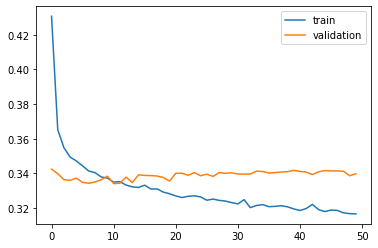

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.16025964178259655
Dropout rate 2: 0.2498384430519197
Fold: 0
Best val loss: 0.3340996918343661
#################################
Time to train MLP:  131.82610607147217
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 13s - loss: 0.4300 - acc: 0.8173 - val_loss: 0.3387 - val_acc: 0.8637

Epoch 00001: val_loss improved from inf to 0.33871, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3656 - acc: 0.8571 - val_loss: 0.3330 - val_acc: 0.8676

Epoch 00002: val_loss improved from 0.33871 to 0.33297, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3539 - acc: 0.8625 - val_loss: 0.3341 - val_acc: 0.8660

Epoch 00003: val_loss did not improve from 0.33297
Epoch 4/50
 - 2s - loss: 0.3495 - acc: 0.8637 - val_loss: 0.3304 - val_acc: 0.8668

Epoch 00004: val_loss improved from 0.33297 to 0.33039, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 2s - loss: 0.3463 -

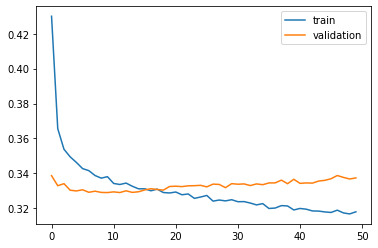

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.16025964178259655
Dropout rate 2: 0.2498384430519197
Fold: 1
Best val loss: 0.3290508132998706
#################################
Time to train MLP:  131.64405512809753
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 14s - loss: 0.4287 - acc: 0.8175 - val_loss: 0.3501 - val_acc: 0.8587

Epoch 00001: val_loss improved from inf to 0.35012, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3656 - acc: 0.8578 - val_loss: 0.3418 - val_acc: 0.8614

Epoch 00002: val_loss improved from 0.35012 to 0.34181, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3535 - acc: 0.8615 - val_loss: 0.3382 - val_acc: 0.8630

Epoch 00003: val_loss improved from 0.34181 to 0.33824, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3493 - acc: 0.8644 - val_loss: 0.3401 - val_acc: 0.8616

Epoch 00004: val_loss did not improve from 0.33824
Epoch 5/50
 - 2s - loss: 0.3445 -

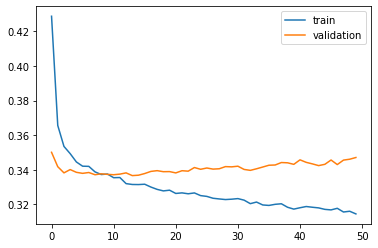

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.16025964178259655
Dropout rate 2: 0.2498384430519197
Fold: 2
Best val loss: 0.33665729152180296
#################################
Time to train MLP:  133.57930850982666
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 13s - loss: 0.4316 - acc: 0.8154 - val_loss: 0.3442 - val_acc: 0.8643

Epoch 00001: val_loss improved from inf to 0.34417, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3658 - acc: 0.8572 - val_loss: 0.3364 - val_acc: 0.8669

Epoch 00002: val_loss improved from 0.34417 to 0.33640, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3544 - acc: 0.8621 - val_loss: 0.3344 - val_acc: 0.8674

Epoch 00003: val_loss improved from 0.33640 to 0.33436, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3503 - acc: 0.8633 - val_loss: 0.3320 - val_acc: 0.8684

Epoch 00004: val_loss improved from 0.33436 to 0.33202, saving model to MLP_val_wei

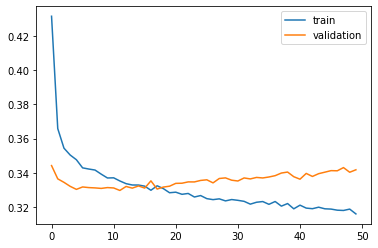

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.16025964178259655
Dropout rate 2: 0.2498384430519197
Fold: 3
Best val loss: 0.3296067860391405
#################################
Time to train MLP:  134.6808910369873
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 14s - loss: 0.4304 - acc: 0.8168 - val_loss: 0.3521 - val_acc: 0.8561

Epoch 00001: val_loss improved from inf to 0.35213, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3646 - acc: 0.8588 - val_loss: 0.3460 - val_acc: 0.8598

Epoch 00002: val_loss improved from 0.35213 to 0.34598, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3545 - acc: 0.8626 - val_loss: 0.3408 - val_acc: 0.8606

Epoch 00003: val_loss improved from 0.34598 to 0.34075, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3483 - acc: 0.8645 - val_loss: 0.3393 - val_acc: 0.8628

Epoch 00004: val_loss improved from 0.34075 to 0.33928, saving model to MLP_val_weigh

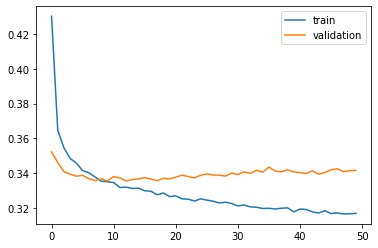

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.16025964178259655
Dropout rate 2: 0.2498384430519197
Fold: 4
Best val loss: 0.33535707321083336
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

 - 2s - loss: 0.3434 - acc: 0.8647 - val_loss: 0.3426 - val_acc: 0.8671

Epoch 00028: val_loss did not improve from 0.33454
Epoch 29/50
 - 2s - loss: 0.3428 - acc: 0.8653 - val_loss: 0.3403 - val_acc: 0.8680

Epoch 00029: val_loss did not improve from 0.33454
Epoch 30/50
 - 2s - loss: 0.3434 - acc: 0.8645 - val_loss: 0.3438 - val_acc: 0.8674

Epoch 00030: val_loss did not improve from 0.33454
Epoch 31/50
 - 2s - loss: 0.3404 - acc: 0.8647 - val_loss: 0.3417 - val_acc: 0.8673

Epoch 00031: val_loss did not improve from 0.33454
Epoch 32/50
 - 2s - loss: 0.3425 - acc: 0.8657 - val_loss: 0.3412 - val_acc: 0.8681

Epoch 00032: val_loss did not improve from 0.33454
Epoch 33/50
 - 2s - loss: 0.3405 - acc: 0.8660 - val_loss: 0.3405 - val_acc: 0.8684

Epoch 00033: val_loss did not improve from 0.33454
Epoch 34/50
 - 2s - loss: 0.3421 - acc: 0.8641 - val_loss: 0.3378 - val_acc: 0.8675

Epoch 00034: val_loss did not improve from 0.33454
Epoch 35/50
 - 2s - loss: 0.3409 - acc: 0.8653 - val_loss: 0

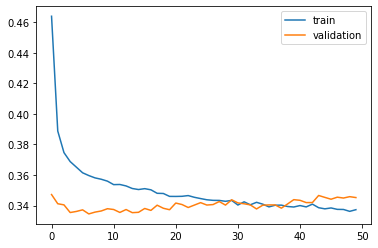

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.18320737654175756
Dropout rate 2: 0.425163948297481
Fold: 0
Best val loss: 0.33453726192663985
#################################
Time to train MLP:  136.41146779060364
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4630 - acc: 0.7949 - val_loss: 0.3450 - val_acc: 0.8619

Epoch 00001: val_loss improved from inf to 0.34496, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3912 - acc: 0.8408 - val_loss: 0.3355 - val_acc: 0.8641

Epoch 00002: val_loss improved from 0.34496 to 0.33553, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3787 - acc: 0.8457 - val_loss: 0.3336 - val_acc: 0.8639

Epoch 00003: val_loss improved from 0.33553 to 0.33356, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3681 - acc: 0.8551 - val_loss: 0.3328 - val_acc: 0.8663

Epoch 00004: val_loss improved from 0.33356 to 0.33283, saving model to MLP_val_weig

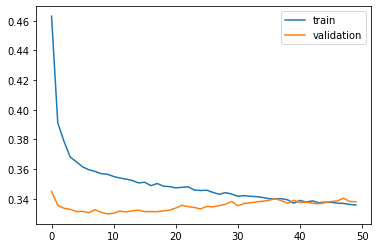

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.18320737654175756
Dropout rate 2: 0.425163948297481
Fold: 1
Best val loss: 0.329742306930977
#################################
Time to train MLP:  137.6171522140503
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4626 - acc: 0.7957 - val_loss: 0.3524 - val_acc: 0.8553

Epoch 00001: val_loss improved from inf to 0.35243, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3919 - acc: 0.8401 - val_loss: 0.3418 - val_acc: 0.8605

Epoch 00002: val_loss improved from 0.35243 to 0.34184, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3766 - acc: 0.8493 - val_loss: 0.3402 - val_acc: 0.8621

Epoch 00003: val_loss improved from 0.34184 to 0.34020, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3700 - acc: 0.8545 - val_loss: 0.3388 - val_acc: 0.8640

Epoch 00004: val_loss improved from 0.34020 to 0.33878, saving model to MLP_val_weights

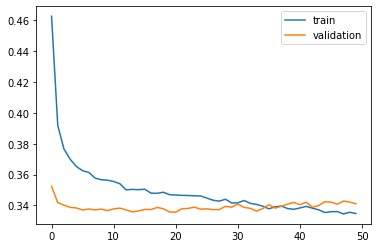

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.18320737654175756
Dropout rate 2: 0.425163948297481
Fold: 2
Best val loss: 0.33566340912503806
#################################
Time to train MLP:  136.32255339622498
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4643 - acc: 0.7930 - val_loss: 0.3455 - val_acc: 0.8639

Epoch 00001: val_loss improved from inf to 0.34547, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3913 - acc: 0.8409 - val_loss: 0.3383 - val_acc: 0.8687

Epoch 00002: val_loss improved from 0.34547 to 0.33829, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3807 - acc: 0.8442 - val_loss: 0.3372 - val_acc: 0.8660

Epoch 00003: val_loss improved from 0.33829 to 0.33718, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3694 - acc: 0.8548 - val_loss: 0.3345 - val_acc: 0.8685

Epoch 00004: val_loss improved from 0.33718 to 0.33446, saving model to MLP_val_weig

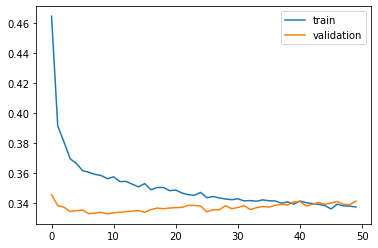

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.18320737654175756
Dropout rate 2: 0.425163948297481
Fold: 3
Best val loss: 0.3327791696542885
#################################
Time to train MLP:  139.2558786869049
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 15s - loss: 0.4622 - acc: 0.7938 - val_loss: 0.3529 - val_acc: 0.8578

Epoch 00001: val_loss improved from inf to 0.35286, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3894 - acc: 0.8419 - val_loss: 0.3477 - val_acc: 0.8587

Epoch 00002: val_loss improved from 0.35286 to 0.34773, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3775 - acc: 0.8462 - val_loss: 0.3431 - val_acc: 0.8621

Epoch 00003: val_loss improved from 0.34773 to 0.34311, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3715 - acc: 0.8491 - val_loss: 0.3393 - val_acc: 0.8625

Epoch 00004: val_loss improved from 0.34311 to 0.33933, saving model to MLP_val_weight

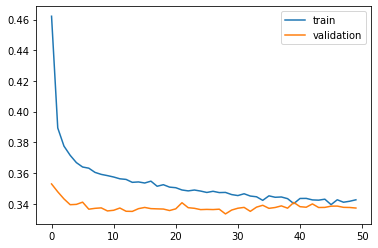

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.18320737654175756
Dropout rate 2: 0.425163948297481
Fold: 4
Best val loss: 0.33331566179704947
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00024: val_loss did not improve from 0.33251
Epoch 25/50
 - 2s - loss: 0.3518 - acc: 0.8586 - val_loss: 0.3363 - val_acc: 0.8684

Epoch 00025: val_loss did not improve from 0.33251
Epoch 26/50
 - 2s - loss: 0.3527 - acc: 0.8578 - val_loss: 0.3371 - val_acc: 0.8676

Epoch 00026: val_loss did not improve from 0.33251
Epoch 27/50
 - 2s - loss: 0.3507 - acc: 0.8587 - val_loss: 0.3370 - val_acc: 0.8677

Epoch 00027: val_loss did not improve from 0.33251
Epoch 28/50
 - 2s - loss: 0.3504 - acc: 0.8585 - val_loss: 0.3381 - val_acc: 0.8658

Epoch 00028: val_loss did not improve from 0.33251
Epoch 29/50
 - 2s - loss: 0.3523 - acc: 0.8580 - val_loss: 0.3360 - val_acc: 0.8675

Epoch 00029: val_loss did not improve from 0.33251
Epoch 30/50
 - 2s - loss: 0.3494 - acc: 0.8592 - val_loss: 0.3385 - val_acc: 0.8683

Epoch 00030: val_loss did not improve from 0.33251
Epoch 31/50
 - 2s - loss: 0.3490 - acc: 0.8600 - val_loss: 0.3349 - val_acc: 0.8683

Epoch 00031: val_loss did not improve from 0.33

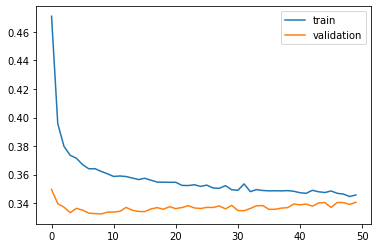

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3548257812940637
Dropout rate 2: 0.3098483876780359
Fold: 0
Best val loss: 0.3325098757367385
#################################
Time to train MLP:  140.6740849018097
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.4651 - acc: 0.7948 - val_loss: 0.3420 - val_acc: 0.8618

Epoch 00001: val_loss improved from inf to 0.34196, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3949 - acc: 0.8385 - val_loss: 0.3367 - val_acc: 0.8630

Epoch 00002: val_loss improved from 0.34196 to 0.33672, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3808 - acc: 0.8456 - val_loss: 0.3325 - val_acc: 0.8653

Epoch 00003: val_loss improved from 0.33672 to 0.33247, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3739 - acc: 0.8490 - val_loss: 0.3339 - val_acc: 0.8670

Epoch 00004: val_loss did not improve from 0.33247
Epoch 5/50
 - 2s - loss: 0.3704 - a

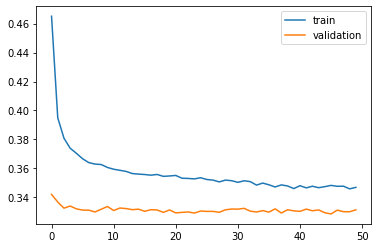

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3548257812940637
Dropout rate 2: 0.3098483876780359
Fold: 1
Best val loss: 0.32848720545657195
#################################
Time to train MLP:  142.83140873908997
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 16s - loss: 0.4693 - acc: 0.7915 - val_loss: 0.3546 - val_acc: 0.8560

Epoch 00001: val_loss improved from inf to 0.35459, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3950 - acc: 0.8398 - val_loss: 0.3434 - val_acc: 0.8619

Epoch 00002: val_loss improved from 0.35459 to 0.34338, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3793 - acc: 0.8461 - val_loss: 0.3408 - val_acc: 0.8627

Epoch 00003: val_loss improved from 0.34338 to 0.34081, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3729 - acc: 0.8509 - val_loss: 0.3396 - val_acc: 0.8649

Epoch 00004: val_loss improved from 0.34081 to 0.33960, saving model to MLP_val_weig

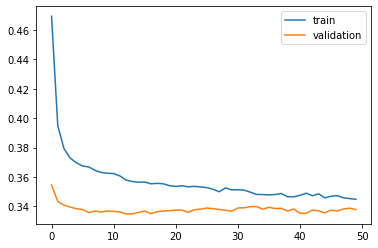

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3548257812940637
Dropout rate 2: 0.3098483876780359
Fold: 2
Best val loss: 0.33490752531771073
#################################
Time to train MLP:  140.57026982307434
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.4720 - acc: 0.7914 - val_loss: 0.3490 - val_acc: 0.8625

Epoch 00001: val_loss improved from inf to 0.34903, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3952 - acc: 0.8361 - val_loss: 0.3347 - val_acc: 0.8665

Epoch 00002: val_loss improved from 0.34903 to 0.33469, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3793 - acc: 0.8465 - val_loss: 0.3344 - val_acc: 0.8675

Epoch 00003: val_loss improved from 0.33469 to 0.33440, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3748 - acc: 0.8496 - val_loss: 0.3318 - val_acc: 0.8680

Epoch 00004: val_loss improved from 0.33440 to 0.33178, saving model to MLP_val_weig

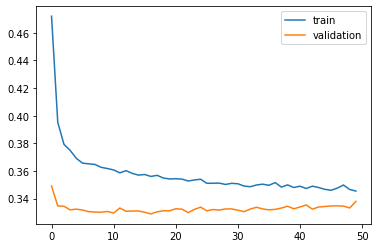

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3548257812940637
Dropout rate 2: 0.3098483876780359
Fold: 3
Best val loss: 0.32885255455970763
#################################
Time to train MLP:  144.35188388824463
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.4698 - acc: 0.7909 - val_loss: 0.3579 - val_acc: 0.8549

Epoch 00001: val_loss improved from inf to 0.35787, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3933 - acc: 0.8393 - val_loss: 0.3461 - val_acc: 0.8606

Epoch 00002: val_loss improved from 0.35787 to 0.34611, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3791 - acc: 0.8467 - val_loss: 0.3398 - val_acc: 0.8621

Epoch 00003: val_loss improved from 0.34611 to 0.33981, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.3720 - acc: 0.8495 - val_loss: 0.3392 - val_acc: 0.8615

Epoch 00004: val_loss improved from 0.33981 to 0.33920, saving model to MLP_val_weig

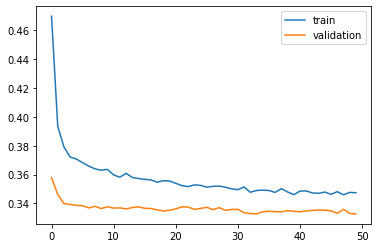

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.3548257812940637
Dropout rate 2: 0.3098483876780359
Fold: 4
Best val loss: 0.33265518306988723
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00021: val_loss did not improve from 0.33005
Epoch 22/50
 - 3s - loss: 0.3823 - acc: 0.8363 - val_loss: 0.3328 - val_acc: 0.8683

Epoch 00022: val_loss did not improve from 0.33005
Epoch 23/50
 - 3s - loss: 0.3824 - acc: 0.8353 - val_loss: 0.3344 - val_acc: 0.8677

Epoch 00023: val_loss did not improve from 0.33005
Epoch 24/50
 - 3s - loss: 0.3815 - acc: 0.8353 - val_loss: 0.3318 - val_acc: 0.8703

Epoch 00024: val_loss did not improve from 0.33005
Epoch 25/50
 - 3s - loss: 0.3806 - acc: 0.8376 - val_loss: 0.3333 - val_acc: 0.8682

Epoch 00025: val_loss did not improve from 0.33005
Epoch 26/50
 - 3s - loss: 0.3815 - acc: 0.8362 - val_loss: 0.3341 - val_acc: 0.8673

Epoch 00026: val_loss did not improve from 0.33005
Epoch 27/50
 - 3s - loss: 0.3790 - acc: 0.8358 - val_loss: 0.3356 - val_acc: 0.8687

Epoch 00027: val_loss did not improve from 0.33005
Epoch 28/50
 - 3s - loss: 0.3785 - acc: 0.8369 - val_loss: 0.3360 - val_acc: 0.8677

Epoch 00028: val_loss did not improve from 0.33

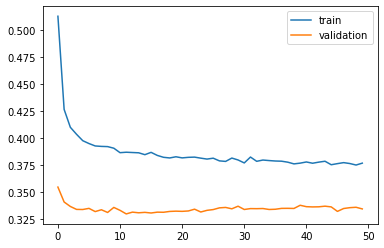

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.45007121526168675
Dropout rate 2: 0.4308070895250569
Fold: 0
Best val loss: 0.3300469226237626
#################################
Time to train MLP:  145.42877531051636
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.5079 - acc: 0.7634 - val_loss: 0.3516 - val_acc: 0.8601

Epoch 00001: val_loss improved from inf to 0.35164, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4254 - acc: 0.8165 - val_loss: 0.3413 - val_acc: 0.8629

Epoch 00002: val_loss improved from 0.35164 to 0.34131, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4114 - acc: 0.8227 - val_loss: 0.3351 - val_acc: 0.8650

Epoch 00003: val_loss improved from 0.34131 to 0.33506, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4012 - acc: 0.8286 - val_loss: 0.3365 - val_acc: 0.8643

Epoch 00004: val_loss did not improve from 0.33506
Epoch 5/50
 - 3s - loss: 0.3978 -

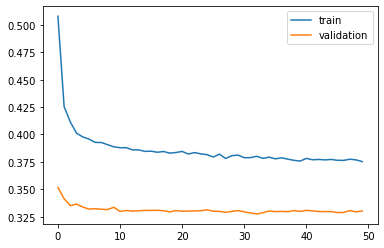

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.45007121526168675
Dropout rate 2: 0.4308070895250569
Fold: 1
Best val loss: 0.32750765206521015
#################################
Time to train MLP:  146.02755165100098
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 17s - loss: 0.5139 - acc: 0.7604 - val_loss: 0.3646 - val_acc: 0.8540

Epoch 00001: val_loss improved from inf to 0.36463, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4286 - acc: 0.8144 - val_loss: 0.3479 - val_acc: 0.8587

Epoch 00002: val_loss improved from 0.36463 to 0.34794, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4096 - acc: 0.8236 - val_loss: 0.3457 - val_acc: 0.8602

Epoch 00003: val_loss improved from 0.34794 to 0.34573, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 2s - loss: 0.4015 - acc: 0.8326 - val_loss: 0.3395 - val_acc: 0.8614

Epoch 00004: val_loss improved from 0.34573 to 0.33947, saving model to MLP_val_wei

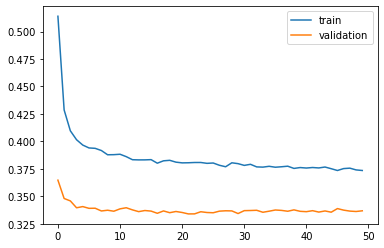

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.45007121526168675
Dropout rate 2: 0.4308070895250569
Fold: 2
Best val loss: 0.33388420545915415
#################################
Time to train MLP:  147.1184470653534
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 18s - loss: 0.5128 - acc: 0.7579 - val_loss: 0.3583 - val_acc: 0.8615

Epoch 00001: val_loss improved from inf to 0.35825, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4295 - acc: 0.8084 - val_loss: 0.3435 - val_acc: 0.8648

Epoch 00002: val_loss improved from 0.35825 to 0.34347, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4102 - acc: 0.8215 - val_loss: 0.3395 - val_acc: 0.8671

Epoch 00003: val_loss improved from 0.34347 to 0.33950, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4036 - acc: 0.8284 - val_loss: 0.3357 - val_acc: 0.8656

Epoch 00004: val_loss improved from 0.33950 to 0.33572, saving model to MLP_val_weig

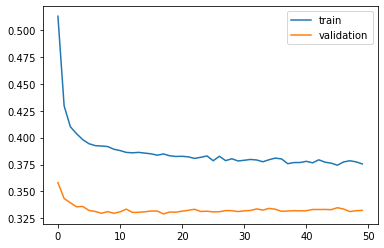

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.45007121526168675
Dropout rate 2: 0.4308070895250569
Fold: 3
Best val loss: 0.3291150565244998
#################################
Time to train MLP:  148.6680908203125
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 20s - loss: 0.5159 - acc: 0.7577 - val_loss: 0.3706 - val_acc: 0.8526

Epoch 00001: val_loss improved from inf to 0.37064, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4331 - acc: 0.7993 - val_loss: 0.3486 - val_acc: 0.8618

Epoch 00002: val_loss improved from 0.37064 to 0.34865, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4165 - acc: 0.8056 - val_loss: 0.3479 - val_acc: 0.8616

Epoch 00003: val_loss improved from 0.34865 to 0.34793, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4084 - acc: 0.8117 - val_loss: 0.3448 - val_acc: 0.8633

Epoch 00004: val_loss improved from 0.34793 to 0.34477, saving model to MLP_val_weigh

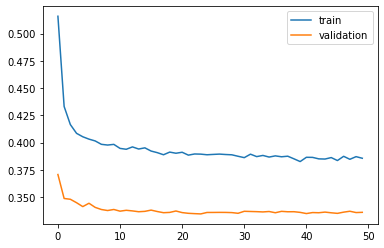

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.45007121526168675
Dropout rate 2: 0.4308070895250569
Fold: 4
Best val loss: 0.3344803640438102
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 


Epoch 00019: val_loss did not improve from 0.33103
Epoch 20/50
 - 3s - loss: 0.3258 - acc: 0.8712 - val_loss: 0.3354 - val_acc: 0.8674

Epoch 00020: val_loss did not improve from 0.33103
Epoch 21/50
 - 3s - loss: 0.3251 - acc: 0.8710 - val_loss: 0.3343 - val_acc: 0.8683

Epoch 00021: val_loss did not improve from 0.33103
Epoch 22/50
 - 3s - loss: 0.3257 - acc: 0.8713 - val_loss: 0.3346 - val_acc: 0.8683

Epoch 00022: val_loss did not improve from 0.33103
Epoch 23/50
 - 2s - loss: 0.3256 - acc: 0.8716 - val_loss: 0.3326 - val_acc: 0.8696

Epoch 00023: val_loss did not improve from 0.33103
Epoch 24/50
 - 2s - loss: 0.3255 - acc: 0.8721 - val_loss: 0.3337 - val_acc: 0.8702

Epoch 00024: val_loss did not improve from 0.33103
Epoch 25/50
 - 3s - loss: 0.3248 - acc: 0.8712 - val_loss: 0.3341 - val_acc: 0.8698

Epoch 00025: val_loss did not improve from 0.33103
Epoch 26/50
 - 3s - loss: 0.3243 - acc: 0.8723 - val_loss: 0.3340 - val_acc: 0.8677

Epoch 00026: val_loss did not improve from 0.33

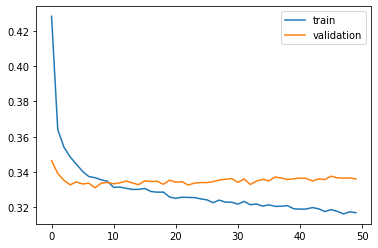

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.26705771959886027
Dropout rate 2: 0.11584859832450017
Fold: 0
Best val loss: 0.3310344221508294
#################################
Time to train MLP:  149.05471658706665
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 18s - loss: 0.4260 - acc: 0.8238 - val_loss: 0.3418 - val_acc: 0.8622

Epoch 00001: val_loss improved from inf to 0.34183, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3627 - acc: 0.8555 - val_loss: 0.3333 - val_acc: 0.8651

Epoch 00002: val_loss improved from 0.34183 to 0.33329, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3542 - acc: 0.8593 - val_loss: 0.3315 - val_acc: 0.8667

Epoch 00003: val_loss improved from 0.33329 to 0.33145, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3479 - acc: 0.8622 - val_loss: 0.3312 - val_acc: 0.8669

Epoch 00004: val_loss improved from 0.33145 to 0.33121, saving model to MLP_val_wei

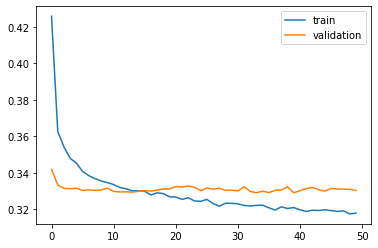

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.26705771959886027
Dropout rate 2: 0.11584859832450017
Fold: 1
Best val loss: 0.3289630368648217
#################################
Time to train MLP:  150.05208706855774
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 18s - loss: 0.4258 - acc: 0.8237 - val_loss: 0.3478 - val_acc: 0.8560

Epoch 00001: val_loss improved from inf to 0.34784, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3636 - acc: 0.8544 - val_loss: 0.3424 - val_acc: 0.8622

Epoch 00002: val_loss improved from 0.34784 to 0.34237, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3531 - acc: 0.8606 - val_loss: 0.3407 - val_acc: 0.8619

Epoch 00003: val_loss improved from 0.34237 to 0.34070, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3471 - acc: 0.8632 - val_loss: 0.3387 - val_acc: 0.8640

Epoch 00004: val_loss improved from 0.34070 to 0.33867, saving model to MLP_val_wei

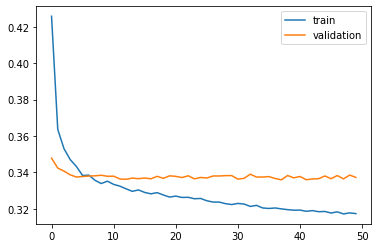

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.26705771959886027
Dropout rate 2: 0.11584859832450017
Fold: 2
Best val loss: 0.33590424138203
#################################
Time to train MLP:  150.0868637561798
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 18s - loss: 0.4252 - acc: 0.8222 - val_loss: 0.3444 - val_acc: 0.8630

Epoch 00001: val_loss improved from inf to 0.34440, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3622 - acc: 0.8553 - val_loss: 0.3363 - val_acc: 0.8660

Epoch 00002: val_loss improved from 0.34440 to 0.33630, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3529 - acc: 0.8604 - val_loss: 0.3338 - val_acc: 0.8668

Epoch 00003: val_loss improved from 0.33630 to 0.33380, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3486 - acc: 0.8622 - val_loss: 0.3324 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.33380 to 0.33236, saving model to MLP_val_weight

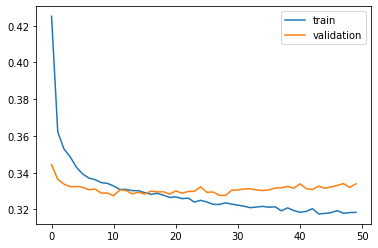

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.26705771959886027
Dropout rate 2: 0.11584859832450017
Fold: 3
Best val loss: 0.3274567783157728
#################################
Time to train MLP:  154.84719967842102
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 19s - loss: 0.4250 - acc: 0.8240 - val_loss: 0.3505 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.35046, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3608 - acc: 0.8572 - val_loss: 0.3440 - val_acc: 0.8604

Epoch 00002: val_loss improved from 0.35046 to 0.34397, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3541 - acc: 0.8593 - val_loss: 0.3399 - val_acc: 0.8625

Epoch 00003: val_loss improved from 0.34397 to 0.33988, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3467 - acc: 0.8631 - val_loss: 0.3377 - val_acc: 0.8633

Epoch 00004: val_loss improved from 0.33988 to 0.33773, saving model to MLP_val_wei

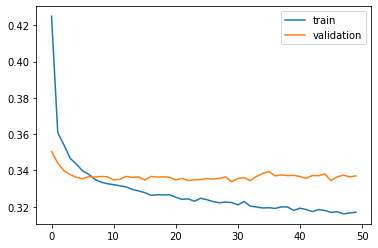

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.26705771959886027
Dropout rate 2: 0.11584859832450017
Fold: 4
Best val loss: 0.3338313941300264
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

 - 3s - loss: 0.3238 - acc: 0.8743 - val_loss: 0.3389 - val_acc: 0.8682

Epoch 00017: val_loss did not improve from 0.33485
Epoch 18/50
 - 3s - loss: 0.3244 - acc: 0.8736 - val_loss: 0.3373 - val_acc: 0.8678

Epoch 00018: val_loss did not improve from 0.33485
Epoch 19/50
 - 3s - loss: 0.3227 - acc: 0.8746 - val_loss: 0.3379 - val_acc: 0.8702

Epoch 00019: val_loss did not improve from 0.33485
Epoch 20/50
 - 3s - loss: 0.3207 - acc: 0.8754 - val_loss: 0.3384 - val_acc: 0.8689

Epoch 00020: val_loss did not improve from 0.33485
Epoch 21/50
 - 3s - loss: 0.3205 - acc: 0.8750 - val_loss: 0.3408 - val_acc: 0.8677

Epoch 00021: val_loss did not improve from 0.33485
Epoch 22/50
 - 3s - loss: 0.3189 - acc: 0.8747 - val_loss: 0.3414 - val_acc: 0.8687

Epoch 00022: val_loss did not improve from 0.33485
Epoch 23/50
 - 3s - loss: 0.3204 - acc: 0.8753 - val_loss: 0.3387 - val_acc: 0.8676

Epoch 00023: val_loss did not improve from 0.33485
Epoch 24/50
 - 3s - loss: 0.3194 - acc: 0.8759 - val_loss: 0

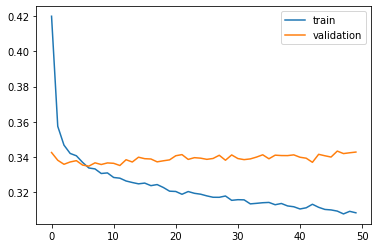

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.12364688245497257
Dropout rate 2: 0.20110920729038556
Fold: 0
Best val loss: 0.33485345868339317
#################################
Time to train MLP:  154.36755895614624
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 19s - loss: 0.4187 - acc: 0.8240 - val_loss: 0.3387 - val_acc: 0.8634

Epoch 00001: val_loss improved from inf to 0.33875, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3582 - acc: 0.8595 - val_loss: 0.3325 - val_acc: 0.8667

Epoch 00002: val_loss improved from 0.33875 to 0.33252, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3471 - acc: 0.8652 - val_loss: 0.3321 - val_acc: 0.8664

Epoch 00003: val_loss improved from 0.33252 to 0.33211, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3415 - acc: 0.8669 - val_loss: 0.3299 - val_acc: 0.8651

Epoch 00004: val_loss improved from 0.33211 to 0.32992, saving model to MLP_val_we

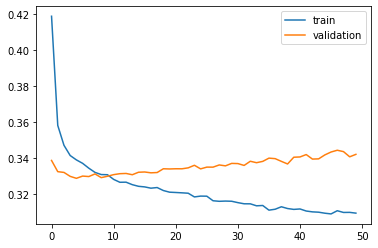

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.12364688245497257
Dropout rate 2: 0.20110920729038556
Fold: 1
Best val loss: 0.3288298809388925
#################################
Time to train MLP:  155.00213265419006
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 20s - loss: 0.4172 - acc: 0.8246 - val_loss: 0.3474 - val_acc: 0.8581

Epoch 00001: val_loss improved from inf to 0.34735, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3579 - acc: 0.8612 - val_loss: 0.3413 - val_acc: 0.8612

Epoch 00002: val_loss improved from 0.34735 to 0.34125, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3469 - acc: 0.8658 - val_loss: 0.3381 - val_acc: 0.8634

Epoch 00003: val_loss improved from 0.34125 to 0.33812, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3415 - acc: 0.8676 - val_loss: 0.3389 - val_acc: 0.8622

Epoch 00004: val_loss did not improve from 0.33812
Epoch 5/50
 - 3s - loss: 0.3382 

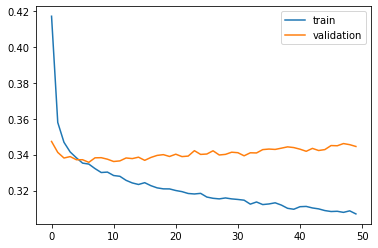

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.12364688245497257
Dropout rate 2: 0.20110920729038556
Fold: 2
Best val loss: 0.33570468249376756
#################################
Time to train MLP:  154.3326756954193
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4205 - acc: 0.8227 - val_loss: 0.3438 - val_acc: 0.8643

Epoch 00001: val_loss improved from inf to 0.34384, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3592 - acc: 0.8593 - val_loss: 0.3387 - val_acc: 0.8654

Epoch 00002: val_loss improved from 0.34384 to 0.33873, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3477 - acc: 0.8647 - val_loss: 0.3333 - val_acc: 0.8680

Epoch 00003: val_loss improved from 0.33873 to 0.33328, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3424 - acc: 0.8661 - val_loss: 0.3327 - val_acc: 0.8702

Epoch 00004: val_loss improved from 0.33328 to 0.33266, saving model to MLP_val_wei

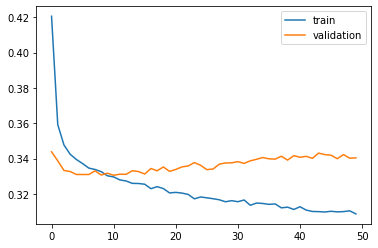

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.12364688245497257
Dropout rate 2: 0.20110920729038556
Fold: 3
Best val loss: 0.33054461969966775
#################################
Time to train MLP:  160.4650468826294
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 20s - loss: 0.4172 - acc: 0.8255 - val_loss: 0.3484 - val_acc: 0.8596

Epoch 00001: val_loss improved from inf to 0.34840, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 2s - loss: 0.3565 - acc: 0.8594 - val_loss: 0.3429 - val_acc: 0.8612

Epoch 00002: val_loss improved from 0.34840 to 0.34294, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 2s - loss: 0.3477 - acc: 0.8663 - val_loss: 0.3402 - val_acc: 0.8612

Epoch 00003: val_loss improved from 0.34294 to 0.34015, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3418 - acc: 0.8671 - val_loss: 0.3382 - val_acc: 0.8620

Epoch 00004: val_loss improved from 0.34015 to 0.33817, saving model to MLP_val_wei

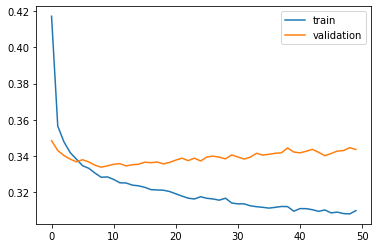

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.12364688245497257
Dropout rate 2: 0.20110920729038556
Fold: 4
Best val loss: 0.3337119105893966
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

 - 3s - loss: 0.3558 - acc: 0.8579 - val_loss: 0.3323 - val_acc: 0.8704

Epoch 00014: val_loss did not improve from 0.33175
Epoch 15/50
 - 3s - loss: 0.3546 - acc: 0.8598 - val_loss: 0.3325 - val_acc: 0.8697

Epoch 00015: val_loss did not improve from 0.33175
Epoch 16/50
 - 3s - loss: 0.3552 - acc: 0.8605 - val_loss: 0.3343 - val_acc: 0.8691

Epoch 00016: val_loss did not improve from 0.33175
Epoch 17/50
 - 3s - loss: 0.3550 - acc: 0.8586 - val_loss: 0.3342 - val_acc: 0.8685

Epoch 00017: val_loss did not improve from 0.33175
Epoch 18/50
 - 3s - loss: 0.3537 - acc: 0.8593 - val_loss: 0.3349 - val_acc: 0.8687

Epoch 00018: val_loss did not improve from 0.33175
Epoch 19/50
 - 3s - loss: 0.3524 - acc: 0.8598 - val_loss: 0.3347 - val_acc: 0.8705

Epoch 00019: val_loss did not improve from 0.33175
Epoch 20/50
 - 3s - loss: 0.3529 - acc: 0.8594 - val_loss: 0.3349 - val_acc: 0.8691

Epoch 00020: val_loss did not improve from 0.33175
Epoch 21/50
 - 3s - loss: 0.3527 - acc: 0.8589 - val_loss: 0

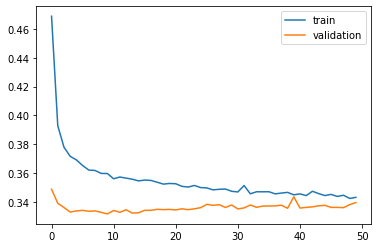

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.33590328128853764
Dropout rate 2: 0.31218753107994274
Fold: 0
Best val loss: 0.3317480894069225
#################################
Time to train MLP:  161.57080817222595
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 21s - loss: 0.4637 - acc: 0.7961 - val_loss: 0.3440 - val_acc: 0.8621

Epoch 00001: val_loss improved from inf to 0.34404, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3916 - acc: 0.8408 - val_loss: 0.3341 - val_acc: 0.8650

Epoch 00002: val_loss improved from 0.34404 to 0.33405, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3783 - acc: 0.8485 - val_loss: 0.3339 - val_acc: 0.8661

Epoch 00003: val_loss improved from 0.33405 to 0.33393, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3710 - acc: 0.8506 - val_loss: 0.3330 - val_acc: 0.8682

Epoch 00004: val_loss improved from 0.33393 to 0.33301, saving model to MLP_val_wei

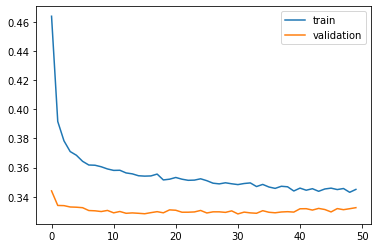

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.33590328128853764
Dropout rate 2: 0.31218753107994274
Fold: 1
Best val loss: 0.3282565510203267
#################################
Time to train MLP:  167.8630223274231
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 21s - loss: 0.4667 - acc: 0.7935 - val_loss: 0.3524 - val_acc: 0.8574

Epoch 00001: val_loss improved from inf to 0.35240, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3916 - acc: 0.8421 - val_loss: 0.3446 - val_acc: 0.8611

Epoch 00002: val_loss improved from 0.35240 to 0.34457, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3766 - acc: 0.8483 - val_loss: 0.3418 - val_acc: 0.8639

Epoch 00003: val_loss improved from 0.34457 to 0.34176, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3716 - acc: 0.8527 - val_loss: 0.3388 - val_acc: 0.8648

Epoch 00004: val_loss improved from 0.34176 to 0.33879, saving model to MLP_val_weig

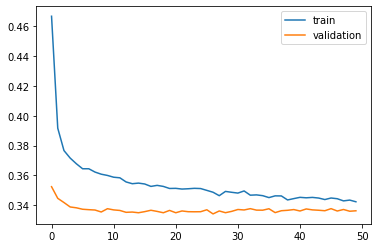

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.33590328128853764
Dropout rate 2: 0.31218753107994274
Fold: 2
Best val loss: 0.33412769495743755
#################################
Time to train MLP:  161.99867343902588
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4681 - acc: 0.7935 - val_loss: 0.3465 - val_acc: 0.8640

Epoch 00001: val_loss improved from inf to 0.34654, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3933 - acc: 0.8372 - val_loss: 0.3374 - val_acc: 0.8670

Epoch 00002: val_loss improved from 0.34654 to 0.33735, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3778 - acc: 0.8480 - val_loss: 0.3334 - val_acc: 0.8702

Epoch 00003: val_loss improved from 0.33735 to 0.33341, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3728 - acc: 0.8500 - val_loss: 0.3328 - val_acc: 0.8676

Epoch 00004: val_loss improved from 0.33341 to 0.33280, saving model to MLP_val_we

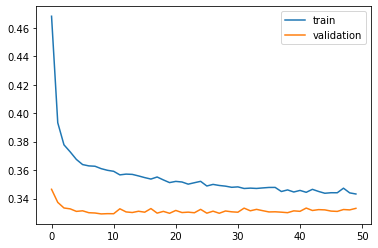

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.33590328128853764
Dropout rate 2: 0.31218753107994274
Fold: 3
Best val loss: 0.3292425613375435
#################################
Time to train MLP:  164.00955963134766
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 21s - loss: 0.4678 - acc: 0.7933 - val_loss: 0.3581 - val_acc: 0.8549

Epoch 00001: val_loss improved from inf to 0.35810, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3910 - acc: 0.8429 - val_loss: 0.3445 - val_acc: 0.8598

Epoch 00002: val_loss improved from 0.35810 to 0.34447, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3768 - acc: 0.8480 - val_loss: 0.3416 - val_acc: 0.8615

Epoch 00003: val_loss improved from 0.34447 to 0.34155, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3703 - acc: 0.8516 - val_loss: 0.3380 - val_acc: 0.8622

Epoch 00004: val_loss improved from 0.34155 to 0.33802, saving model to MLP_val_wei

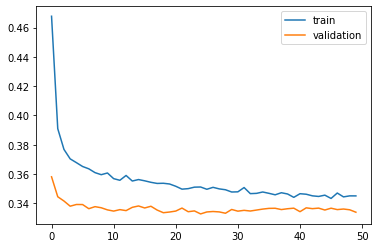

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.33590328128853764
Dropout rate 2: 0.31218753107994274
Fold: 4
Best val loss: 0.3327408924925397
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,


Epoch 00011: val_loss did not improve from 0.33261
Epoch 12/50
 - 3s - loss: 0.3276 - acc: 0.8705 - val_loss: 0.3345 - val_acc: 0.8685

Epoch 00012: val_loss did not improve from 0.33261
Epoch 13/50
 - 3s - loss: 0.3271 - acc: 0.8698 - val_loss: 0.3357 - val_acc: 0.8680

Epoch 00013: val_loss did not improve from 0.33261
Epoch 14/50
 - 3s - loss: 0.3267 - acc: 0.8702 - val_loss: 0.3344 - val_acc: 0.8682

Epoch 00014: val_loss did not improve from 0.33261
Epoch 15/50
 - 3s - loss: 0.3258 - acc: 0.8709 - val_loss: 0.3355 - val_acc: 0.8676

Epoch 00015: val_loss did not improve from 0.33261
Epoch 16/50
 - 3s - loss: 0.3265 - acc: 0.8712 - val_loss: 0.3366 - val_acc: 0.8675

Epoch 00016: val_loss did not improve from 0.33261
Epoch 17/50
 - 3s - loss: 0.3241 - acc: 0.8716 - val_loss: 0.3353 - val_acc: 0.8683

Epoch 00017: val_loss did not improve from 0.33261
Epoch 18/50
 - 3s - loss: 0.3248 - acc: 0.8718 - val_loss: 0.3352 - val_acc: 0.8676

Epoch 00018: val_loss did not improve from 0.33

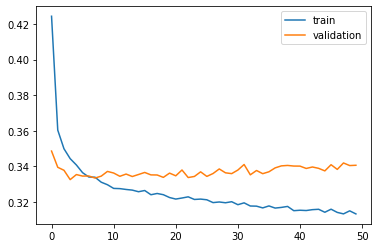

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2808645536565688
Dropout rate 2: 0.07151835294195091
Fold: 0
Best val loss: 0.3326149352391561
#################################
Time to train MLP:  165.79346251487732
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4215 - acc: 0.8272 - val_loss: 0.3406 - val_acc: 0.8628

Epoch 00001: val_loss improved from inf to 0.34061, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3608 - acc: 0.8565 - val_loss: 0.3339 - val_acc: 0.8657

Epoch 00002: val_loss improved from 0.34061 to 0.33394, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3505 - acc: 0.8605 - val_loss: 0.3331 - val_acc: 0.8668

Epoch 00003: val_loss improved from 0.33394 to 0.33313, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3444 - acc: 0.8638 - val_loss: 0.3329 - val_acc: 0.8670

Epoch 00004: val_loss improved from 0.33313 to 0.33286, saving model to MLP_val_weig

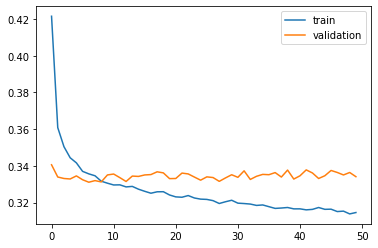

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2808645536565688
Dropout rate 2: 0.07151835294195091
Fold: 1
Best val loss: 0.3310967580477397
#################################
Time to train MLP:  165.73990058898926
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4226 - acc: 0.8251 - val_loss: 0.3481 - val_acc: 0.8584

Epoch 00001: val_loss improved from inf to 0.34813, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3603 - acc: 0.8566 - val_loss: 0.3404 - val_acc: 0.8636

Epoch 00002: val_loss improved from 0.34813 to 0.34042, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3497 - acc: 0.8612 - val_loss: 0.3416 - val_acc: 0.8621

Epoch 00003: val_loss did not improve from 0.34042
Epoch 4/50
 - 3s - loss: 0.3436 - acc: 0.8651 - val_loss: 0.3406 - val_acc: 0.8618

Epoch 00004: val_loss did not improve from 0.34042
Epoch 5/50
 - 3s - loss: 0.3393 - acc: 0.8656 - val_loss: 0.3408 - val_acc:

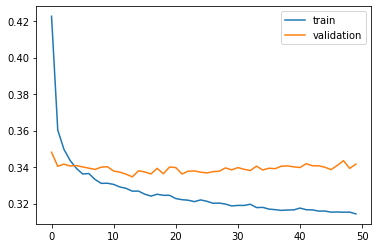

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2808645536565688
Dropout rate 2: 0.07151835294195091
Fold: 2
Best val loss: 0.33462170384780704
#################################
Time to train MLP:  165.38590288162231
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 22s - loss: 0.4220 - acc: 0.8243 - val_loss: 0.3446 - val_acc: 0.8623

Epoch 00001: val_loss improved from inf to 0.34457, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3599 - acc: 0.8563 - val_loss: 0.3370 - val_acc: 0.8648

Epoch 00002: val_loss improved from 0.34457 to 0.33704, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3504 - acc: 0.8598 - val_loss: 0.3332 - val_acc: 0.8678

Epoch 00003: val_loss improved from 0.33704 to 0.33318, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3463 - acc: 0.8627 - val_loss: 0.3302 - val_acc: 0.8705

Epoch 00004: val_loss improved from 0.33318 to 0.33024, saving model to MLP_val_wei

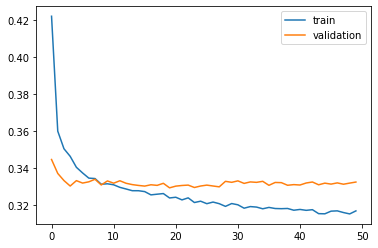

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2808645536565688
Dropout rate 2: 0.07151835294195091
Fold: 3
Best val loss: 0.3292605942034582
#################################
Time to train MLP:  166.6713650226593
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 23s - loss: 0.4224 - acc: 0.8253 - val_loss: 0.3534 - val_acc: 0.8561

Epoch 00001: val_loss improved from inf to 0.35340, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3582 - acc: 0.8578 - val_loss: 0.3443 - val_acc: 0.8613

Epoch 00002: val_loss improved from 0.35340 to 0.34428, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3501 - acc: 0.8612 - val_loss: 0.3400 - val_acc: 0.8636

Epoch 00003: val_loss improved from 0.34428 to 0.34001, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3436 - acc: 0.8622 - val_loss: 0.3380 - val_acc: 0.8630

Epoch 00004: val_loss improved from 0.34001 to 0.33799, saving model to MLP_val_weigh

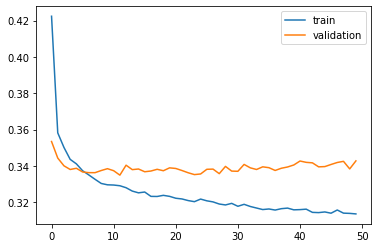

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2808645536565688
Dropout rate 2: 0.07151835294195091
Fold: 4
Best val loss: 0.33487165387610945
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

 - 3s - loss: 0.3297 - acc: 0.8703 - val_loss: 0.3347 - val_acc: 0.8685

Epoch 00009: val_loss did not improve from 0.33310
Epoch 10/50
 - 3s - loss: 0.3289 - acc: 0.8700 - val_loss: 0.3368 - val_acc: 0.8677

Epoch 00010: val_loss did not improve from 0.33310
Epoch 11/50
 - 3s - loss: 0.3260 - acc: 0.8706 - val_loss: 0.3362 - val_acc: 0.8675

Epoch 00011: val_loss did not improve from 0.33310
Epoch 12/50
 - 3s - loss: 0.3267 - acc: 0.8716 - val_loss: 0.3355 - val_acc: 0.8691

Epoch 00012: val_loss did not improve from 0.33310
Epoch 13/50
 - 3s - loss: 0.3256 - acc: 0.8714 - val_loss: 0.3355 - val_acc: 0.8674

Epoch 00013: val_loss did not improve from 0.33310
Epoch 14/50
 - 3s - loss: 0.3248 - acc: 0.8711 - val_loss: 0.3361 - val_acc: 0.8682

Epoch 00014: val_loss did not improve from 0.33310
Epoch 15/50
 - 3s - loss: 0.3240 - acc: 0.8715 - val_loss: 0.3344 - val_acc: 0.8669

Epoch 00015: val_loss did not improve from 0.33310
Epoch 16/50
 - 3s - loss: 0.3240 - acc: 0.8723 - val_loss: 0

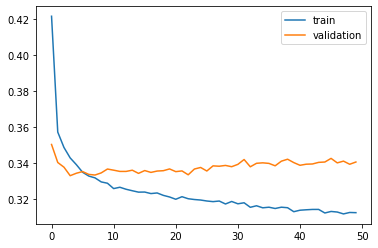

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2712799383547549
Dropout rate 2: 0.061399241796639636
Fold: 0
Best val loss: 0.3330984628339957
#################################
Time to train MLP:  173.64579343795776
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4191 - acc: 0.8280 - val_loss: 0.3397 - val_acc: 0.8626

Epoch 00001: val_loss improved from inf to 0.33967, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3585 - acc: 0.8575 - val_loss: 0.3336 - val_acc: 0.8648

Epoch 00002: val_loss improved from 0.33967 to 0.33360, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3488 - acc: 0.8617 - val_loss: 0.3334 - val_acc: 0.8685

Epoch 00003: val_loss improved from 0.33360 to 0.33343, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3426 - acc: 0.8648 - val_loss: 0.3331 - val_acc: 0.8662

Epoch 00004: val_loss improved from 0.33343 to 0.33311, saving model to MLP_val_wei

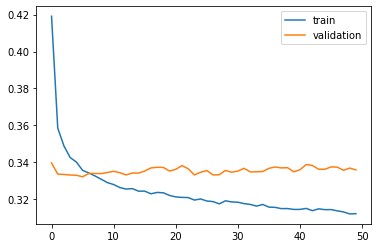

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2712799383547549
Dropout rate 2: 0.061399241796639636
Fold: 1
Best val loss: 0.33215112214897113
#################################
Time to train MLP:  174.20141911506653
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 23s - loss: 0.4197 - acc: 0.8270 - val_loss: 0.3464 - val_acc: 0.8585

Epoch 00001: val_loss improved from inf to 0.34644, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3579 - acc: 0.8577 - val_loss: 0.3418 - val_acc: 0.8625

Epoch 00002: val_loss improved from 0.34644 to 0.34179, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3476 - acc: 0.8622 - val_loss: 0.3407 - val_acc: 0.8625

Epoch 00003: val_loss improved from 0.34179 to 0.34070, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3413 - acc: 0.8658 - val_loss: 0.3402 - val_acc: 0.8635

Epoch 00004: val_loss improved from 0.34070 to 0.34021, saving model to MLP_val_we

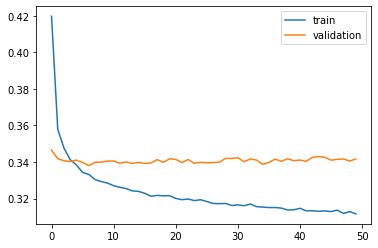

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2712799383547549
Dropout rate 2: 0.061399241796639636
Fold: 2
Best val loss: 0.33797226798813246
#################################
Time to train MLP:  169.27094292640686
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 24s - loss: 0.4194 - acc: 0.8254 - val_loss: 0.3440 - val_acc: 0.8651

Epoch 00001: val_loss improved from inf to 0.34395, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3574 - acc: 0.8575 - val_loss: 0.3349 - val_acc: 0.8678

Epoch 00002: val_loss improved from 0.34395 to 0.33487, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3481 - acc: 0.8615 - val_loss: 0.3337 - val_acc: 0.8677

Epoch 00003: val_loss improved from 0.33487 to 0.33368, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3441 - acc: 0.8642 - val_loss: 0.3312 - val_acc: 0.8687

Epoch 00004: val_loss improved from 0.33368 to 0.33116, saving model to MLP_val_we

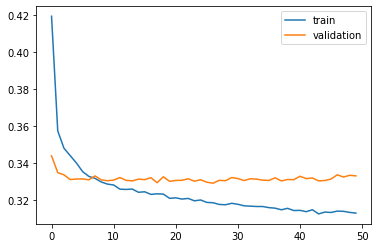

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2712799383547549
Dropout rate 2: 0.061399241796639636
Fold: 3
Best val loss: 0.32917099920629755
#################################
Time to train MLP:  171.47846746444702
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 24s - loss: 0.4198 - acc: 0.8264 - val_loss: 0.3501 - val_acc: 0.8582

Epoch 00001: val_loss improved from inf to 0.35008, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3563 - acc: 0.8590 - val_loss: 0.3444 - val_acc: 0.8621

Epoch 00002: val_loss improved from 0.35008 to 0.34444, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3483 - acc: 0.8617 - val_loss: 0.3392 - val_acc: 0.8627

Epoch 00003: val_loss improved from 0.34444 to 0.33919, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3412 - acc: 0.8640 - val_loss: 0.3380 - val_acc: 0.8620

Epoch 00004: val_loss improved from 0.33919 to 0.33799, saving model to MLP_val_we

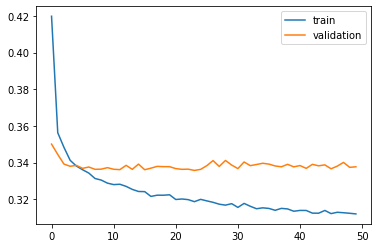

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.2712799383547549
Dropout rate 2: 0.061399241796639636
Fold: 4
Best val loss: 0.3357235808958087
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

 - 3s - loss: 0.3713 - acc: 0.8466 - val_loss: 0.3374 - val_acc: 0.8668

Epoch 00006: val_loss did not improve from 0.33427
Epoch 7/50
 - 3s - loss: 0.3695 - acc: 0.8473 - val_loss: 0.3331 - val_acc: 0.8685

Epoch 00007: val_loss improved from 0.33427 to 0.33306, saving model to MLP_val_weights.hdf5
Epoch 8/50
 - 3s - loss: 0.3696 - acc: 0.8479 - val_loss: 0.3394 - val_acc: 0.8669

Epoch 00008: val_loss did not improve from 0.33306
Epoch 9/50
 - 3s - loss: 0.3694 - acc: 0.8466 - val_loss: 0.3413 - val_acc: 0.8658

Epoch 00009: val_loss did not improve from 0.33306
Epoch 10/50
 - 3s - loss: 0.3670 - acc: 0.8491 - val_loss: 0.3376 - val_acc: 0.8683

Epoch 00010: val_loss did not improve from 0.33306
Epoch 11/50
 - 3s - loss: 0.3632 - acc: 0.8500 - val_loss: 0.3417 - val_acc: 0.8676

Epoch 00011: val_loss did not improve from 0.33306
Epoch 12/50
 - 3s - loss: 0.3639 - acc: 0.8498 - val_loss: 0.3426 - val_acc: 0.8667

Epoch 00012: val_loss did not improve from 0.33306
Epoch 13/50
 - 3s - l

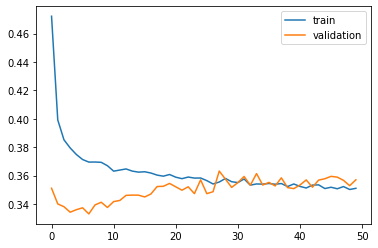

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.44672380184745036
Dropout rate 2: 0.20841495538125104
Fold: 0
Best val loss: 0.33306248139219674
#################################
Time to train MLP:  174.18428325653076
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 25s - loss: 0.4686 - acc: 0.7941 - val_loss: 0.3488 - val_acc: 0.8629

Epoch 00001: val_loss improved from inf to 0.34875, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3989 - acc: 0.8306 - val_loss: 0.3383 - val_acc: 0.8640

Epoch 00002: val_loss improved from 0.34875 to 0.33829, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3854 - acc: 0.8398 - val_loss: 0.3350 - val_acc: 0.8662

Epoch 00003: val_loss improved from 0.33829 to 0.33500, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3781 - acc: 0.8430 - val_loss: 0.3350 - val_acc: 0.8648

Epoch 00004: val_loss improved from 0.33500 to 0.33496, saving model to MLP_val_we

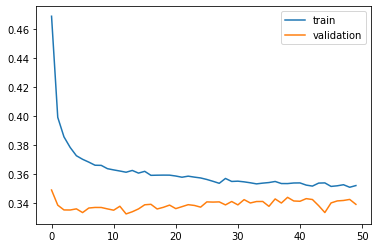

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.44672380184745036
Dropout rate 2: 0.20841495538125104
Fold: 1
Best val loss: 0.33225670843793637
#################################
Time to train MLP:  177.73992800712585
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.4736 - acc: 0.7907 - val_loss: 0.3562 - val_acc: 0.8582

Epoch 00001: val_loss improved from inf to 0.35619, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3997 - acc: 0.8306 - val_loss: 0.3469 - val_acc: 0.8595

Epoch 00002: val_loss improved from 0.35619 to 0.34686, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3854 - acc: 0.8389 - val_loss: 0.3455 - val_acc: 0.8602

Epoch 00003: val_loss improved from 0.34686 to 0.34554, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3786 - acc: 0.8438 - val_loss: 0.3413 - val_acc: 0.8618

Epoch 00004: val_loss improved from 0.34554 to 0.34129, saving model to MLP_val_we

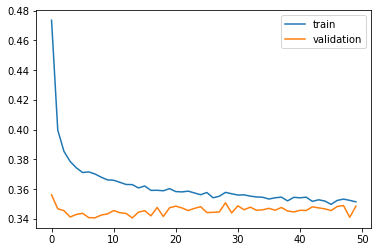

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.44672380184745036
Dropout rate 2: 0.20841495538125104
Fold: 2
Best val loss: 0.34067515770245715
#################################
Time to train MLP:  178.5278034210205
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.4703 - acc: 0.7926 - val_loss: 0.3510 - val_acc: 0.8630

Epoch 00001: val_loss improved from inf to 0.35099, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3976 - acc: 0.8297 - val_loss: 0.3408 - val_acc: 0.8649

Epoch 00002: val_loss improved from 0.35099 to 0.34082, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3848 - acc: 0.8406 - val_loss: 0.3396 - val_acc: 0.8669

Epoch 00003: val_loss improved from 0.34082 to 0.33960, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3783 - acc: 0.8432 - val_loss: 0.3359 - val_acc: 0.8670

Epoch 00004: val_loss improved from 0.33960 to 0.33587, saving model to MLP_val_wei

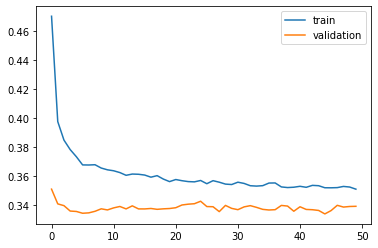

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.44672380184745036
Dropout rate 2: 0.20841495538125104
Fold: 3
Best val loss: 0.33389259774782504
#################################
Time to train MLP:  176.12447357177734
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 25s - loss: 0.4717 - acc: 0.7935 - val_loss: 0.3641 - val_acc: 0.8551

Epoch 00001: val_loss improved from inf to 0.36414, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3957 - acc: 0.8316 - val_loss: 0.3475 - val_acc: 0.8619

Epoch 00002: val_loss improved from 0.36414 to 0.34749, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3844 - acc: 0.8393 - val_loss: 0.3467 - val_acc: 0.8621

Epoch 00003: val_loss improved from 0.34749 to 0.34668, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3793 - acc: 0.8428 - val_loss: 0.3451 - val_acc: 0.8636

Epoch 00004: val_loss improved from 0.34668 to 0.34511, saving model to MLP_val_we

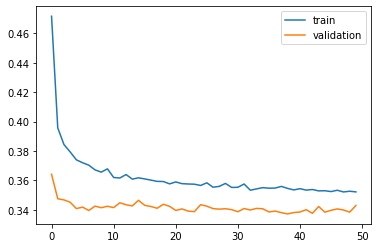

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.44672380184745036
Dropout rate 2: 0.20841495538125104
Fold: 4
Best val loss: 0.3371513671345181
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

 - 3s - loss: 0.3810 - acc: 0.8421 - val_loss: 0.3336 - val_acc: 0.8667

Epoch 00004: val_loss improved from 0.33491 to 0.33365, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3766 - acc: 0.8437 - val_loss: 0.3351 - val_acc: 0.8664

Epoch 00005: val_loss did not improve from 0.33365
Epoch 6/50
 - 3s - loss: 0.3746 - acc: 0.8465 - val_loss: 0.3327 - val_acc: 0.8678

Epoch 00006: val_loss improved from 0.33365 to 0.33272, saving model to MLP_val_weights.hdf5
Epoch 7/50
 - 3s - loss: 0.3726 - acc: 0.8449 - val_loss: 0.3323 - val_acc: 0.8680

Epoch 00007: val_loss improved from 0.33272 to 0.33228, saving model to MLP_val_weights.hdf5
Epoch 8/50
 - 3s - loss: 0.3722 - acc: 0.8467 - val_loss: 0.3318 - val_acc: 0.8671

Epoch 00008: val_loss improved from 0.33228 to 0.33177, saving model to MLP_val_weights.hdf5
Epoch 9/50
 - 3s - loss: 0.3724 - acc: 0.8460 - val_loss: 0.3326 - val_acc: 0.8669

Epoch 00009: val_loss did not improve from 0.33177
Epoch 10/50
 - 3s - loss: 0.3691 

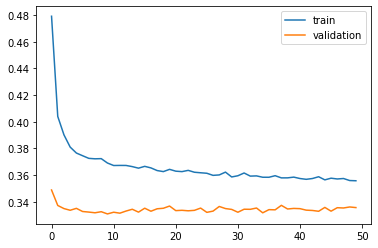

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4213897747825215
Dropout rate 2: 0.27844149102598
Fold: 0
Best val loss: 0.33090902631742913
#################################
Time to train MLP:  181.71537947654724
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 25s - loss: 0.4732 - acc: 0.7895 - val_loss: 0.3463 - val_acc: 0.8625

Epoch 00001: val_loss improved from inf to 0.34631, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4031 - acc: 0.8295 - val_loss: 0.3364 - val_acc: 0.8669

Epoch 00002: val_loss improved from 0.34631 to 0.33644, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3864 - acc: 0.8405 - val_loss: 0.3364 - val_acc: 0.8667

Epoch 00003: val_loss improved from 0.33644 to 0.33636, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3789 - acc: 0.8442 - val_loss: 0.3318 - val_acc: 0.8660

Epoch 00004: val_loss improved from 0.33636 to 0.33176, saving model to MLP_val_weight

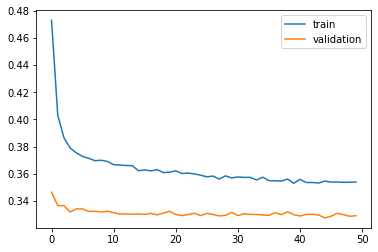

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4213897747825215
Dropout rate 2: 0.27844149102598
Fold: 1
Best val loss: 0.32731917147050826
#################################
Time to train MLP:  181.3105707168579
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.4777 - acc: 0.7865 - val_loss: 0.3564 - val_acc: 0.8558

Epoch 00001: val_loss improved from inf to 0.35640, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4036 - acc: 0.8301 - val_loss: 0.3461 - val_acc: 0.8586

Epoch 00002: val_loss improved from 0.35640 to 0.34610, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3857 - acc: 0.8405 - val_loss: 0.3428 - val_acc: 0.8612

Epoch 00003: val_loss improved from 0.34610 to 0.34281, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3794 - acc: 0.8474 - val_loss: 0.3405 - val_acc: 0.8636

Epoch 00004: val_loss improved from 0.34281 to 0.34050, saving model to MLP_val_weights

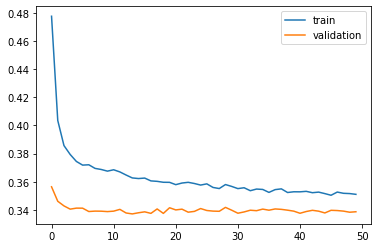

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4213897747825215
Dropout rate 2: 0.27844149102598
Fold: 2
Best val loss: 0.33710071505161754
#################################
Time to train MLP:  183.8639039993286
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.4775 - acc: 0.7873 - val_loss: 0.3519 - val_acc: 0.8621

Epoch 00001: val_loss improved from inf to 0.35190, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4040 - acc: 0.8252 - val_loss: 0.3390 - val_acc: 0.8655

Epoch 00002: val_loss improved from 0.35190 to 0.33897, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3902 - acc: 0.8345 - val_loss: 0.3354 - val_acc: 0.8671

Epoch 00003: val_loss improved from 0.33897 to 0.33541, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3857 - acc: 0.8355 - val_loss: 0.3325 - val_acc: 0.8658

Epoch 00004: val_loss improved from 0.33541 to 0.33248, saving model to MLP_val_weights

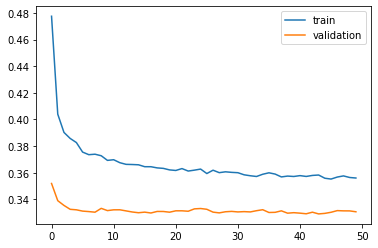

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4213897747825215
Dropout rate 2: 0.27844149102598
Fold: 3
Best val loss: 0.32902806838353477
#################################
Time to train MLP:  182.87043356895447
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 26s - loss: 0.4777 - acc: 0.7870 - val_loss: 0.3617 - val_acc: 0.8545

Epoch 00001: val_loss improved from inf to 0.36172, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4020 - acc: 0.8297 - val_loss: 0.3474 - val_acc: 0.8608

Epoch 00002: val_loss improved from 0.36172 to 0.34744, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3860 - acc: 0.8411 - val_loss: 0.3430 - val_acc: 0.8620

Epoch 00003: val_loss improved from 0.34744 to 0.34303, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3783 - acc: 0.8469 - val_loss: 0.3412 - val_acc: 0.8634

Epoch 00004: val_loss improved from 0.34303 to 0.34120, saving model to MLP_val_weight

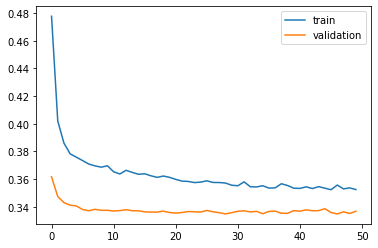

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4213897747825215
Dropout rate 2: 0.27844149102598
Fold: 4
Best val loss: 0.334887128594326
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 0.33

Epoch 2/50
 - 3s - loss: 0.3944 - acc: 0.8375 - val_loss: 0.3396 - val_acc: 0.8618

Epoch 00002: val_loss improved from 0.34777 to 0.33961, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3789 - acc: 0.8481 - val_loss: 0.3370 - val_acc: 0.8644

Epoch 00003: val_loss improved from 0.33961 to 0.33702, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3741 - acc: 0.8499 - val_loss: 0.3374 - val_acc: 0.8646

Epoch 00004: val_loss did not improve from 0.33702
Epoch 5/50
 - 3s - loss: 0.3726 - acc: 0.8501 - val_loss: 0.3386 - val_acc: 0.8641

Epoch 00005: val_loss did not improve from 0.33702
Epoch 6/50
 - 3s - loss: 0.3684 - acc: 0.8513 - val_loss: 0.3384 - val_acc: 0.8646

Epoch 00006: val_loss did not improve from 0.33702
Epoch 7/50
 - 3s - loss: 0.3673 - acc: 0.8523 - val_loss: 0.3354 - val_acc: 0.8683

Epoch 00007: val_loss improved from 0.33702 to 0.33537, saving model to MLP_val_weights.hdf5
Epoch 8/50
 - 3s - loss: 0.3656 - acc: 0.8540 - val_loss: 0.3364

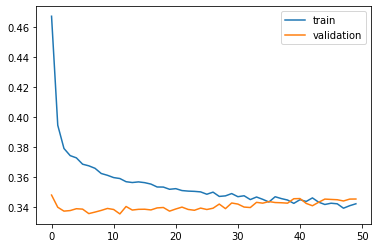

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1530062949748115
Dropout rate 2: 0.4707095877197112
Fold: 0
Best val loss: 0.3351608703986943
#################################
Time to train MLP:  185.831152677536
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4694 - acc: 0.7905 - val_loss: 0.3442 - val_acc: 0.8616

Epoch 00001: val_loss improved from inf to 0.34422, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3959 - acc: 0.8367 - val_loss: 0.3400 - val_acc: 0.8642

Epoch 00002: val_loss improved from 0.34422 to 0.34000, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3789 - acc: 0.8490 - val_loss: 0.3367 - val_acc: 0.8656

Epoch 00003: val_loss improved from 0.34000 to 0.33673, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3713 - acc: 0.8519 - val_loss: 0.3343 - val_acc: 0.8647

Epoch 00004: val_loss improved from 0.33673 to 0.33426, saving model to MLP_val_weights

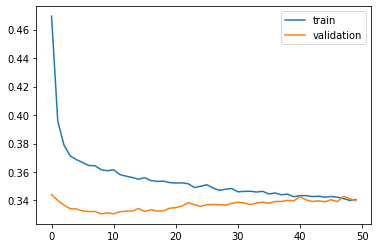

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1530062949748115
Dropout rate 2: 0.4707095877197112
Fold: 1
Best val loss: 0.3305628225329327
#################################
Time to train MLP:  189.56400799751282
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4675 - acc: 0.7917 - val_loss: 0.3521 - val_acc: 0.8547

Epoch 00001: val_loss improved from inf to 0.35207, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3976 - acc: 0.8356 - val_loss: 0.3433 - val_acc: 0.8585

Epoch 00002: val_loss improved from 0.35207 to 0.34334, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3778 - acc: 0.8495 - val_loss: 0.3405 - val_acc: 0.8619

Epoch 00003: val_loss improved from 0.34334 to 0.34047, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3736 - acc: 0.8510 - val_loss: 0.3390 - val_acc: 0.8639

Epoch 00004: val_loss improved from 0.34047 to 0.33902, saving model to MLP_val_weigh

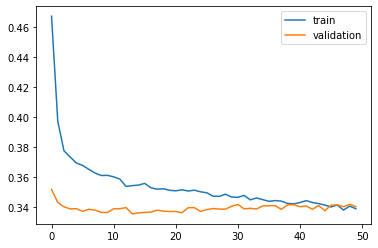

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1530062949748115
Dropout rate 2: 0.4707095877197112
Fold: 2
Best val loss: 0.33569574427883525
#################################
Time to train MLP:  189.45670771598816
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 27s - loss: 0.4711 - acc: 0.7878 - val_loss: 0.3478 - val_acc: 0.8633

Epoch 00001: val_loss improved from inf to 0.34779, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3961 - acc: 0.8355 - val_loss: 0.3376 - val_acc: 0.8665

Epoch 00002: val_loss improved from 0.34779 to 0.33761, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3867 - acc: 0.8384 - val_loss: 0.3358 - val_acc: 0.8664

Epoch 00003: val_loss improved from 0.33761 to 0.33584, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3814 - acc: 0.8415 - val_loss: 0.3329 - val_acc: 0.8673

Epoch 00004: val_loss improved from 0.33584 to 0.33288, saving model to MLP_val_weig

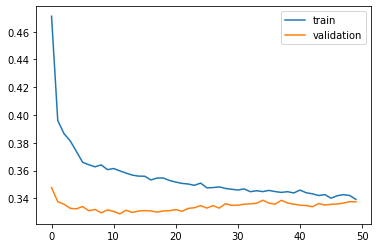

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1530062949748115
Dropout rate 2: 0.4707095877197112
Fold: 3
Best val loss: 0.3288377374794051
#################################
Time to train MLP:  190.28542065620422
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 28s - loss: 0.4684 - acc: 0.7902 - val_loss: 0.3517 - val_acc: 0.8551

Epoch 00001: val_loss improved from inf to 0.35168, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3956 - acc: 0.8355 - val_loss: 0.3476 - val_acc: 0.8591

Epoch 00002: val_loss improved from 0.35168 to 0.34763, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3822 - acc: 0.8455 - val_loss: 0.3440 - val_acc: 0.8605

Epoch 00003: val_loss improved from 0.34763 to 0.34404, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3724 - acc: 0.8520 - val_loss: 0.3417 - val_acc: 0.8594

Epoch 00004: val_loss improved from 0.34404 to 0.34175, saving model to MLP_val_weigh

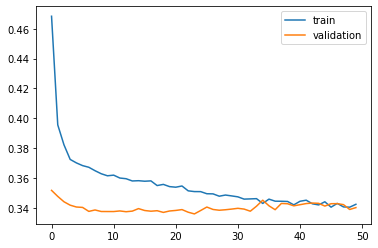

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.1530062949748115
Dropout rate 2: 0.4707095877197112
Fold: 4
Best val loss: 0.3358903530954617
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 0

Time to train MLP:  192.17727065086365
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 28s - loss: 0.4475 - acc: 0.8102 - val_loss: 0.3459 - val_acc: 0.8612

Epoch 00001: val_loss improved from inf to 0.34591, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3795 - acc: 0.8470 - val_loss: 0.3368 - val_acc: 0.8667

Epoch 00002: val_loss improved from 0.34591 to 0.33675, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3666 - acc: 0.8544 - val_loss: 0.3369 - val_acc: 0.8664

Epoch 00003: val_loss did not improve from 0.33675
Epoch 4/50
 - 3s - loss: 0.3602 - acc: 0.8573 - val_loss: 0.3326 - val_acc: 0.8675

Epoch 00004: val_loss improved from 0.33675 to 0.33257, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3572 - acc: 0.8575 - val_loss: 0.3348 - val_acc: 0.8662

Epoch 00005: val_loss did not improve from 0.33257
Epoch 6/50
 - 3s - loss: 0.3531 - acc: 0.8600 - val_loss: 0.3348 - val_acc: 0.8682

Epoch 00006: val_loss did not 

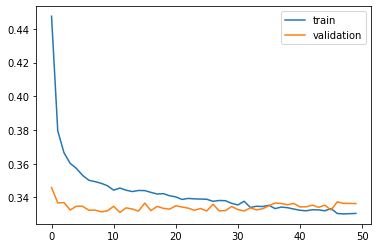

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.31558488872759777
Dropout rate 2: 0.20462951125161527
Fold: 0
Best val loss: 0.3311130746763352
#################################
Time to train MLP:  188.90302634239197
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 31s - loss: 0.4426 - acc: 0.8115 - val_loss: 0.3412 - val_acc: 0.8625

Epoch 00001: val_loss improved from inf to 0.34119, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3786 - acc: 0.8449 - val_loss: 0.3326 - val_acc: 0.8656

Epoch 00002: val_loss improved from 0.34119 to 0.33257, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3677 - acc: 0.8531 - val_loss: 0.3312 - val_acc: 0.8665

Epoch 00003: val_loss improved from 0.33257 to 0.33124, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3606 - acc: 0.8569 - val_loss: 0.3310 - val_acc: 0.8669

Epoch 00004: val_loss improved from 0.33124 to 0.33104, saving model to MLP_val_wei

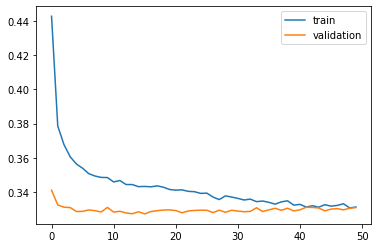

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.31558488872759777
Dropout rate 2: 0.20462951125161527
Fold: 1
Best val loss: 0.3273365899833322
#################################
Time to train MLP:  197.03110766410828
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 28s - loss: 0.4467 - acc: 0.8096 - val_loss: 0.3509 - val_acc: 0.8573

Epoch 00001: val_loss improved from inf to 0.35093, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3793 - acc: 0.8452 - val_loss: 0.3431 - val_acc: 0.8609

Epoch 00002: val_loss improved from 0.35093 to 0.34310, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3651 - acc: 0.8556 - val_loss: 0.3416 - val_acc: 0.8606

Epoch 00003: val_loss improved from 0.34310 to 0.34157, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3583 - acc: 0.8590 - val_loss: 0.3398 - val_acc: 0.8622

Epoch 00004: val_loss improved from 0.34157 to 0.33977, saving model to MLP_val_wei

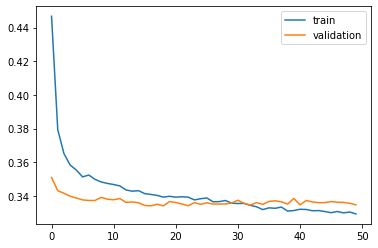

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.31558488872759777
Dropout rate 2: 0.20462951125161527
Fold: 2
Best val loss: 0.33409440210688185
#################################
Time to train MLP:  193.26045107841492
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 29s - loss: 0.4466 - acc: 0.8085 - val_loss: 0.3452 - val_acc: 0.8654

Epoch 00001: val_loss improved from inf to 0.34519, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3778 - acc: 0.8453 - val_loss: 0.3365 - val_acc: 0.8648

Epoch 00002: val_loss improved from 0.34519 to 0.33649, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3670 - acc: 0.8540 - val_loss: 0.3342 - val_acc: 0.8676

Epoch 00003: val_loss improved from 0.33649 to 0.33423, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3604 - acc: 0.8564 - val_loss: 0.3314 - val_acc: 0.8677

Epoch 00004: val_loss improved from 0.33423 to 0.33137, saving model to MLP_val_we

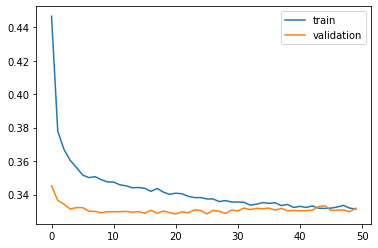

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.31558488872759777
Dropout rate 2: 0.20462951125161527
Fold: 3
Best val loss: 0.32842955744754504
#################################
Time to train MLP:  195.3114309310913
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 29s - loss: 0.4459 - acc: 0.8098 - val_loss: 0.3540 - val_acc: 0.8552

Epoch 00001: val_loss improved from inf to 0.35396, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3763 - acc: 0.8469 - val_loss: 0.3434 - val_acc: 0.8601

Epoch 00002: val_loss improved from 0.35396 to 0.34340, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3644 - acc: 0.8554 - val_loss: 0.3410 - val_acc: 0.8602

Epoch 00003: val_loss improved from 0.34340 to 0.34102, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3584 - acc: 0.8574 - val_loss: 0.3381 - val_acc: 0.8628

Epoch 00004: val_loss improved from 0.34102 to 0.33810, saving model to MLP_val_wei

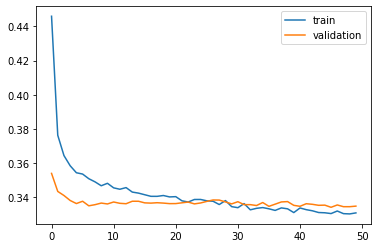

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.31558488872759777
Dropout rate 2: 0.20462951125161527
Fold: 4
Best val loss: 0.3341169006224961
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0,

Time to train MLP:  195.09275937080383
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 29s - loss: 0.4784 - acc: 0.7864 - val_loss: 0.3488 - val_acc: 0.8598

Epoch 00001: val_loss improved from inf to 0.34884, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3982 - acc: 0.8386 - val_loss: 0.3400 - val_acc: 0.8632

Epoch 00002: val_loss improved from 0.34884 to 0.34001, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3861 - acc: 0.8436 - val_loss: 0.3375 - val_acc: 0.8656

Epoch 00003: val_loss improved from 0.34001 to 0.33753, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3797 - acc: 0.8451 - val_loss: 0.3331 - val_acc: 0.8660

Epoch 00004: val_loss improved from 0.33753 to 0.33308, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.3774 - acc: 0.8472 - val_loss: 0.3319 - val_acc: 0.8665

Epoch 00005: val_loss improved from 0.33308 to 0.33190, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 3s - loss: 0.371

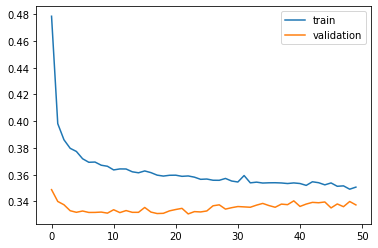

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.34011943022307756
Dropout rate 2: 0.3683757246914701
Fold: 0
Best val loss: 0.33069393896220023
#################################
Time to train MLP:  195.32412457466125
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 29s - loss: 0.4734 - acc: 0.7876 - val_loss: 0.3446 - val_acc: 0.8619

Epoch 00001: val_loss improved from inf to 0.34457, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3984 - acc: 0.8370 - val_loss: 0.3368 - val_acc: 0.8633

Epoch 00002: val_loss improved from 0.34457 to 0.33683, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3863 - acc: 0.8423 - val_loss: 0.3336 - val_acc: 0.8663

Epoch 00003: val_loss improved from 0.33683 to 0.33358, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3791 - acc: 0.8445 - val_loss: 0.3335 - val_acc: 0.8665

Epoch 00004: val_loss improved from 0.33358 to 0.33354, saving model to MLP_val_wei

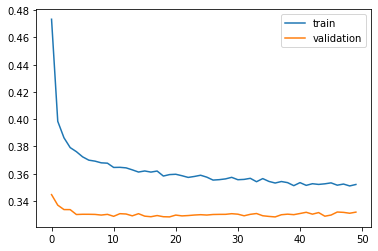

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.34011943022307756
Dropout rate 2: 0.3683757246914701
Fold: 1
Best val loss: 0.3281875437672375
#################################
Time to train MLP:  199.11275720596313
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 30s - loss: 0.4781 - acc: 0.7858 - val_loss: 0.3552 - val_acc: 0.8550

Epoch 00001: val_loss improved from inf to 0.35525, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4001 - acc: 0.8365 - val_loss: 0.3439 - val_acc: 0.8608

Epoch 00002: val_loss improved from 0.35525 to 0.34392, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3855 - acc: 0.8419 - val_loss: 0.3415 - val_acc: 0.8637

Epoch 00003: val_loss improved from 0.34392 to 0.34145, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3794 - acc: 0.8459 - val_loss: 0.3389 - val_acc: 0.8620

Epoch 00004: val_loss improved from 0.34145 to 0.33892, saving model to MLP_val_weig

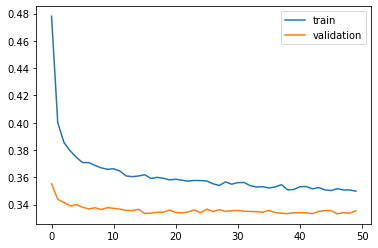

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.34011943022307756
Dropout rate 2: 0.3683757246914701
Fold: 2
Best val loss: 0.33314914594616807
#################################
Time to train MLP:  203.06303691864014
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 30s - loss: 0.4787 - acc: 0.7848 - val_loss: 0.3484 - val_acc: 0.8627

Epoch 00001: val_loss improved from inf to 0.34836, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3987 - acc: 0.8358 - val_loss: 0.3372 - val_acc: 0.8664

Epoch 00002: val_loss improved from 0.34836 to 0.33717, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3856 - acc: 0.8424 - val_loss: 0.3348 - val_acc: 0.8670

Epoch 00003: val_loss improved from 0.33717 to 0.33483, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3798 - acc: 0.8466 - val_loss: 0.3352 - val_acc: 0.8681

Epoch 00004: val_loss did not improve from 0.33483
Epoch 5/50
 - 3s - loss: 0.3752 

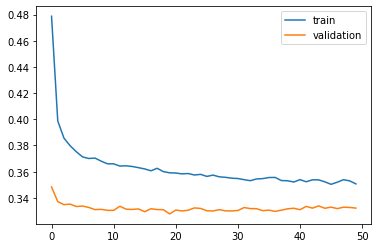

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.34011943022307756
Dropout rate 2: 0.3683757246914701
Fold: 3
Best val loss: 0.32775736267106576
#################################
Time to train MLP:  202.49682211875916
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 30s - loss: 0.4773 - acc: 0.7849 - val_loss: 0.3598 - val_acc: 0.8560

Epoch 00001: val_loss improved from inf to 0.35975, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3988 - acc: 0.8379 - val_loss: 0.3446 - val_acc: 0.8614

Epoch 00002: val_loss improved from 0.35975 to 0.34456, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3836 - acc: 0.8419 - val_loss: 0.3395 - val_acc: 0.8615

Epoch 00003: val_loss improved from 0.34456 to 0.33953, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.3773 - acc: 0.8470 - val_loss: 0.3399 - val_acc: 0.8602

Epoch 00004: val_loss did not improve from 0.33953
Epoch 5/50
 - 3s - loss: 0.3748 

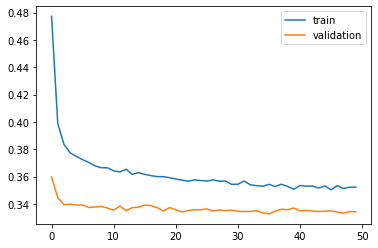

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.34011943022307756
Dropout rate 2: 0.3683757246914701
Fold: 4
Best val loss: 0.3327333666497504
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 

Time to train MLP:  200.43880534172058
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 31s - loss: 0.5372 - acc: 0.7420 - val_loss: 0.3627 - val_acc: 0.8561

Epoch 00001: val_loss improved from inf to 0.36275, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4465 - acc: 0.8010 - val_loss: 0.3442 - val_acc: 0.8627

Epoch 00002: val_loss improved from 0.36275 to 0.34419, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4264 - acc: 0.8107 - val_loss: 0.3394 - val_acc: 0.8642

Epoch 00003: val_loss improved from 0.34419 to 0.33944, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4211 - acc: 0.8163 - val_loss: 0.3372 - val_acc: 0.8653

Epoch 00004: val_loss improved from 0.33944 to 0.33715, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 3s - loss: 0.4125 - acc: 0.8209 - val_loss: 0.3360 - val_acc: 0.8653

Epoch 00005: val_loss improved from 0.33715 to 0.33605, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 3s - loss: 0.408

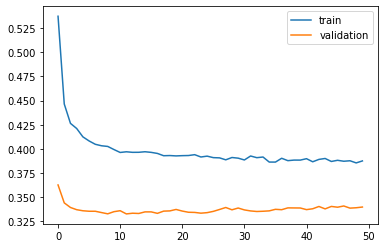

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4852137801976603
Dropout rate 2: 0.49772533718312456
Fold: 0
Best val loss: 0.3327863985753199
#################################
Time to train MLP:  203.28058457374573
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 30s - loss: 0.5337 - acc: 0.7468 - val_loss: 0.3642 - val_acc: 0.8551

Epoch 00001: val_loss improved from inf to 0.36417, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4465 - acc: 0.8007 - val_loss: 0.3474 - val_acc: 0.8630

Epoch 00002: val_loss improved from 0.36417 to 0.34740, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4276 - acc: 0.8082 - val_loss: 0.3387 - val_acc: 0.8644

Epoch 00003: val_loss improved from 0.34740 to 0.33872, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4179 - acc: 0.8132 - val_loss: 0.3372 - val_acc: 0.8641

Epoch 00004: val_loss improved from 0.33872 to 0.33715, saving model to MLP_val_weig

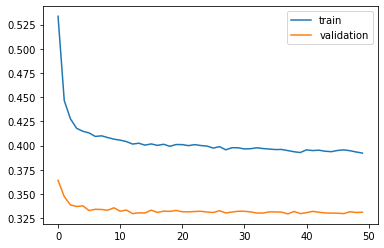

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4852137801976603
Dropout rate 2: 0.49772533718312456
Fold: 1
Best val loss: 0.329478746534091
#################################
Time to train MLP:  203.20511031150818
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 31s - loss: 0.5392 - acc: 0.7405 - val_loss: 0.3770 - val_acc: 0.8527

Epoch 00001: val_loss improved from inf to 0.37698, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4542 - acc: 0.7924 - val_loss: 0.3525 - val_acc: 0.8568

Epoch 00002: val_loss improved from 0.37698 to 0.35255, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4264 - acc: 0.8125 - val_loss: 0.3486 - val_acc: 0.8585

Epoch 00003: val_loss improved from 0.35255 to 0.34864, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4156 - acc: 0.8208 - val_loss: 0.3420 - val_acc: 0.8621

Epoch 00004: val_loss improved from 0.34864 to 0.34205, saving model to MLP_val_weigh

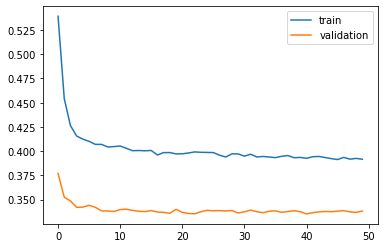

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4852137801976603
Dropout rate 2: 0.49772533718312456
Fold: 2
Best val loss: 0.33527830272738696
#################################
Time to train MLP:  197.53197121620178
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 32s - loss: 0.5372 - acc: 0.7407 - val_loss: 0.3689 - val_acc: 0.8612

Epoch 00001: val_loss improved from inf to 0.36892, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.4481 - acc: 0.7971 - val_loss: 0.3474 - val_acc: 0.8628

Epoch 00002: val_loss improved from 0.36892 to 0.34743, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.4288 - acc: 0.8054 - val_loss: 0.3425 - val_acc: 0.8660

Epoch 00003: val_loss improved from 0.34743 to 0.34251, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 3s - loss: 0.4206 - acc: 0.8136 - val_loss: 0.3385 - val_acc: 0.8664

Epoch 00004: val_loss improved from 0.34251 to 0.33852, saving model to MLP_val_wei

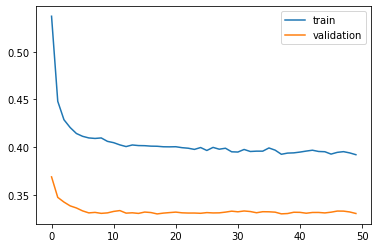

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4852137801976603
Dropout rate 2: 0.49772533718312456
Fold: 3
Best val loss: 0.3301074986708792
#################################
Time to train MLP:  204.0097942352295
Train on 76950 samples, validate on 8550 samples
Epoch 1/50
 - 32s - loss: 0.5424 - acc: 0.7379 - val_loss: 0.3773 - val_acc: 0.8517

Epoch 00001: val_loss improved from inf to 0.37732, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.4504 - acc: 0.7939 - val_loss: 0.3571 - val_acc: 0.8587

Epoch 00002: val_loss improved from 0.37732 to 0.35706, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.4268 - acc: 0.8077 - val_loss: 0.3484 - val_acc: 0.8595

Epoch 00003: val_loss improved from 0.35706 to 0.34839, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.4171 - acc: 0.8133 - val_loss: 0.3452 - val_acc: 0.8605

Epoch 00004: val_loss improved from 0.34839 to 0.34519, saving model to MLP_val_weigh

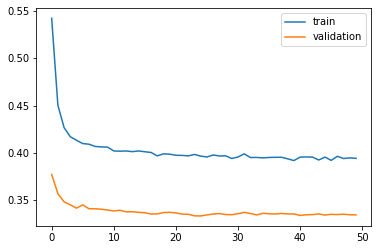

#################################
Number of units: 8
Batch size: 128
Dropout rate 1: 0.4852137801976603
Dropout rate 2: 0.49772533718312456
Fold: 4
Best val loss: 0.3334766427885022
#################################
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 

Time to train MLP:  211.09039616584778
Entire process took:  18071.062317848206
Experiment record:
[[8, 128, 0.48000865166795925, 0.4467835759603806, 0, 0.3311609453694862], [8, 128, 0.48000865166795925, 0.4467835759603806, 1, 0.328545075390074], [8, 128, 0.48000865166795925, 0.4467835759603806, 2, 0.3334776935451909], [8, 128, 0.48000865166795925, 0.4467835759603806, 3, 0.3292853852252514], [8, 128, 0.48000865166795925, 0.4467835759603806, 4, 0.3342238294311434], [8, 128, 0.349756024974788, 0.4712129306803903, 0, 0.3314596560266283], [8, 128, 0.349756024974788, 0.4712129306803903, 1, 0.32734597273737365], [8, 128, 0.349756024974788, 0.4712129306803903, 2, 0.3346212549307193], [8, 128, 0.349756024974788, 0.4712129306803903, 3, 0.32959447161496036], [8, 128, 0.349756024974788, 0.4712129306803903, 4, 0.3316685695397226], [8, 128, 0.4999336463119396, 0.3211127406113972, 0, 0.3314941099791499], [8, 128, 0.4999336463119396, 0.3211127406113972, 1, 0.3296011347171159], [8, 128, 0.499933646311

In [14]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

print(len(dropout_rate_1_list) == len(dropout_rate_2_list))

n_units = 8
b_size = 128

exp_record = []

for i in range(25):
    dropout_rate_1 = dropout_rate_1_list[i]
    dropout_rate_2 = dropout_rate_2_list[i]

    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_mlp = np.append(train2_y, train1_y, axis=0)
        ###########################
        seed(1)
        set_random_seed(1)
        ###########################
        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = setup_model(n_units, 
                                 dropout_rate_1, 
                                 dropout_rate_2)
            v_loss = fit_model(model, train_x_mlp, 
                               train_y_mlp, b_size)
            print("#################################")
            print("Number of units:", n_units)
            print("Batch size:", b_size)
            print("Dropout rate 1:", dropout_rate_1)
            print("Dropout rate 2:", dropout_rate_2)
            print("Fold:", f)
            print("Best val loss:", v_loss)
            exp_record.append([n_units, b_size, 
                               dropout_rate_1, 
                               dropout_rate_2, 
                               f, v_loss])
            print("#################################")
            if(f==4):
                print(exp_record)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [15]:
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []

for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    print("Dropout rate 1:", h_params[0, 2])
    print("Dropout rate 2:", h_params[0, 3])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 5]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 5]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 5]))
print("Min val loss:", min(val_loss_list))
print("Min dropout rate 1:", min(complete_v[:, 2]))
print("Min dropout rate 2:", min(complete_v[:, 3]))
print("Max dropout rate 1:", max(complete_v[:, 2]))
print("Max dropout rate 2:", max(complete_v[:, 3]))

(125, 6)
###############################
Units: 8.0
Batch size: 128.0
Dropout rate 1: 0.48000865166795925
Dropout rate 2: 0.4467835759603806
Val loss (mean): 0.33134
Val loss (std): 0.00223
###############################
###############################
Units: 8.0
Batch size: 128.0
Dropout rate 1: 0.349756024974788
Dropout rate 2: 0.4712129306803903
Val loss (mean): 0.33094
Val loss (std): 0.00241
###############################
###############################
Units: 8.0
Batch size: 128.0
Dropout rate 1: 0.4999336463119396
Dropout rate 2: 0.3211127406113972
Val loss (mean): 0.33253
Val loss (std): 0.00267
###############################
###############################
Units: 8.0
Batch size: 128.0
Dropout rate 1: 0.11003364989142589
Dropout rate 2: 0.3073238169210421
Val loss (mean): 0.33382
Val loss (std): 0.00281
###############################
###############################
Units: 8.0
Batch size: 128.0
Dropout rate 1: 0.180528176982029
Dropout rate 2: 0.11384162719898794
Val loss (m